# Making NMDS plots of Bray-Curtis values for each simulation

* simulations from atomIncorp_taxaIncorp
* plotting centroids of each replicate
  * gradient fraction samples between replicates are groups by uniform BD-range bins

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
inFileDir = os.path.join(workDir, 'atomIncorp_taxaIncorp')
buildDir = os.path.join(workDir, 'atomIncorp_taxaIncorp_NMDS')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [2]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image, display

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)
library(vegan)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0


In [112]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)

# Loading phyloseq objects

In [113]:
%%R -i inFileDir

files = list.files(inFileDir, pattern='OTU_n2_abs1e9_sub-norm_filt.physeq', recursive=T)
dirs = gsub('/[0-9]+/[^/]+$','', files) %>% unique %>% as.data.frame
colnames(dirs) = c('dirs')


percTaxa.to.keep = c(1,10,25,50)

tbl = dirs %>%
    separate(dirs, c('percIncorp','percTaxa'), sep='/', remove=F) %>%
    filter(percTaxa %in% percTaxa.to.keep)

tbl %>% nrow %>% print
tbl %>% head

[1] 16
    dirs percIncorp percTaxa
1   0/10          0       10
2    0/1          0        1
3   0/25          0       25
4   0/50          0       50
5 100/10        100       10
6  100/1        100        1


## functions 

* loading files
* joining OTU tables

In [165]:
%%R -i inFileDir

get.files = function(dir, base.path, pattern){
    dir = as.character(dir)
    p = paste(c(base.path, dir), collapse='/')
    files = list.files(p, pattern=pattern, recursive=T)
    p = gsub('$', '/', p)
    files = gsub('^', p, files)
    return(files)
    }


get.otu.tbls = function(files){
    tbl.l = list()    
    for(f in files){
        physeq = readRDS(f)
    
        id = gsub('/[^/]+$', '', f)
        id = gsub('.+atomIncorp_taxaIncorp/', '', id)
        id = paste(c(id,'__'), collapse='')
        otu.tbl = physeq %>% otu_table %>% as.data.frame
        colnames(otu.tbl) = gsub('^', id, colnames(otu.tbl))
        otu.tbl$taxon = rownames(otu.tbl)
        tbl.l[[f]] = otu.tbl
        }
    return(tbl.l)
    }


join.otu.tbls = function(tbl.l){
    n = names(tbl.l)

    tbl = tbl.l[[n[1]]]
    for (i in seq(2:length(n))){
        n.i = n[i]
        tbl = left_join(tbl, tbl.l[[n.i]], c('taxon'='taxon'))
        }
    
    # edit table
    tbl[is.na(tbl)] = 0
    rownames(tbl) = tbl$taxon
    tbl$taxon = NULL
    
    # return
    return(tbl)
    }


make.meta = function(tbl, BD.range = seq(1.6, 1.9, 0.004)){
    meta = tbl %>% colnames %>% as.data.frame 
    colnames(meta) = c('X')
    meta = filter(meta, X != 'taxon')

    # midpoint function
    mid = function(x, y){ (x + y)/2 }

    # making fixed BD-range
    #BD.range = seq(1.6, 1.9, 0.004)

    #print(meta); break
    
    # edit metadata
    meta = meta %>%
        #separate(X, c('percIncorp','percTaxa','rep','library','BD_range'), sep='__', remove=F) %>%
        separate(X, c('tmp1', 'library', 'tmp2'), sep='__', remove=F) %>%
        separate(tmp1, c('percIncorp','percTaxa', 'rep'), sep='/') %>%
        mutate(tmp2 = gsub('.[xy]$', '', tmp2)) %>%
        separate(tmp2, c('BD.min', 'BD.max'), sep='-') %>%
        mutate(BD.min = as.numeric(BD.min),
               BD.max = as.numeric(BD.max),
               BD.mid = mapply(mid, BD.min, BD.max),   
               BD.bin = cut(BD.mid, breaks=BD.range)) %>%
        unite(groups, library, BD.bin, sep='__')
    return(meta)
    }
    

edit.ellipse = function(elps){
    # midpoint function
    mid = function(x, y){ (x + y)/2 }

    elps.tbl = elps %>% summary %>% t %>% as.data.frame
    elps.tbl$meta = rownames(elps.tbl)
    elps.tbl = elps.tbl %>%
        separate(meta, c('library','BD.range'), sep='__') %>%
        mutate(BD.range = gsub('^.', '', BD.range),
               BD.range = gsub('.$', '', BD.range)) %>%
        separate(BD.range, c('BD.min','BD.max'), sep=',', remove=F) %>%
        mutate(
            BD.min = as.numeric(BD.min),
            BD.max = as.numeric(BD.max),
            BD.mid = mapply(mid, BD.min, BD.max))
    }

In [166]:
%%R

# wrapper function
get.ellipses = function(x){
    dir = x['dirs']
    
    # test run of functions
    files = get.files(dir, base.path=inFileDir, pattern='OTU_n2_abs1e9_sub-norm_filt.physeq')
    otu.tbls = get.otu.tbls(files)
    otu.tbl = join.otu.tbls(otu.tbls)
    # making metadata
    meta = make.meta(otu.tbl, BD.range=seq(1.6, 2, 0.002))
    ord = metaMDS(otu.tbl %>% t)
    # getting ellipse
    plot(ord, type = "p", display='sites')
    elps = ordiellipse(ord, groups=meta$groups, kind="se", conf=0.95, lwd=2, col="blue")
    # edit ellipse file
    elps.tbl = edit.ellipse(elps)
    elps.tbl$percIncorp = x['percIncorp'] %>% as.vector
    elps.tbl$percTaxa = x['percTaxa'] %>% as.vector
    
    return(elps.tbl)
    }

## Applying functions to all replicates of each set of params

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1790159 
Run 1 stress 0.1826813 
Run 2 stress 0.1905444 
Run 3 stress 0.1857775 
Run 4 stress 0.1870961 
Run 5 stress 0.1816663 
Run 6 stress 0.1859556 
Run 7 stress 0.1891756 
Run 8 stress 0.1913628 
Run 9 stress 0.1852682 
Run 10 stress 0.1815447 
Run 11 stress 0.1896646 
Run 12 stress 0.1829106 
Run 13 stress 0.1845297 
Run 14 stress 0.1881721 
Run 15 stress 0.1872477 
Run 16 stress 0.1833416 
Run 17 stress 0.1833737 
Run 18 stress 0.1809264 
Run 19 stress 0.1880924 
Run 20 stress 0.1904182 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.1926144 
Run 1 stress 0.4189866 
Run 2 stress 0.199258 
Run 3 stress 0.1968785 
Run 4 stress 0.1984816 
Run 5 stress 0.2010789 
Run 6 stress 0.1961535 
Run 7 stress 0.1987694 
Run 8 stress 0.1971745 
Run 9 stress 0.1940195 
Run 10 stress 0.2007577 
Run 11 stress 0.1949308 
Run 12 stress 0.19829 
Run 13 stress 0.1951333 
Run 14 stress 0.1945277 
Run

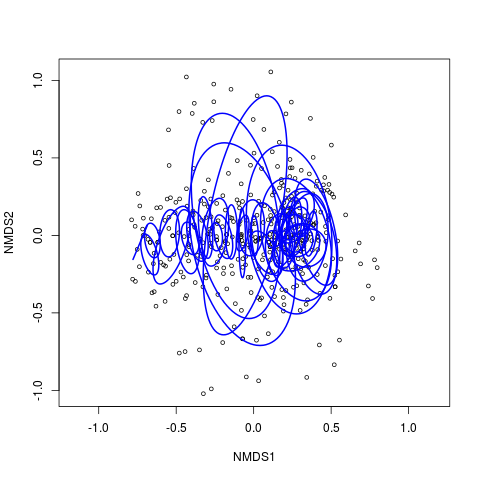

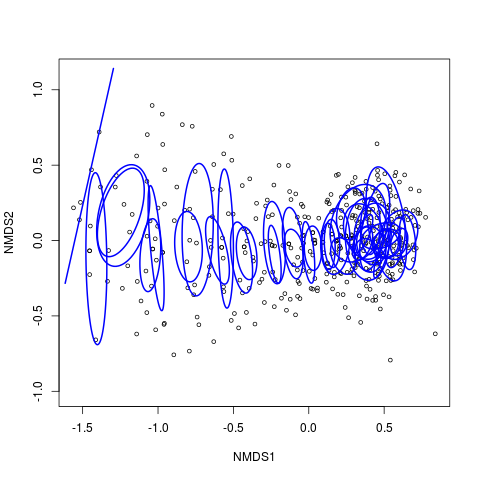

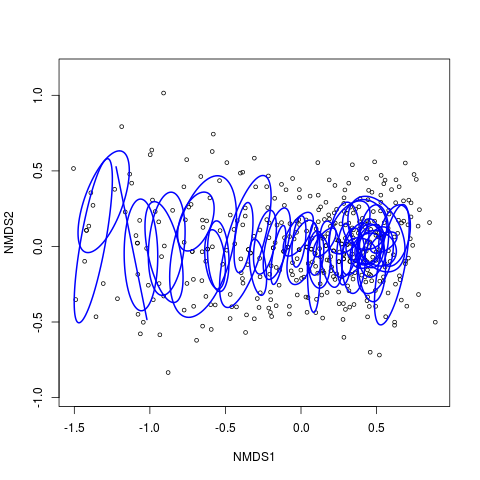

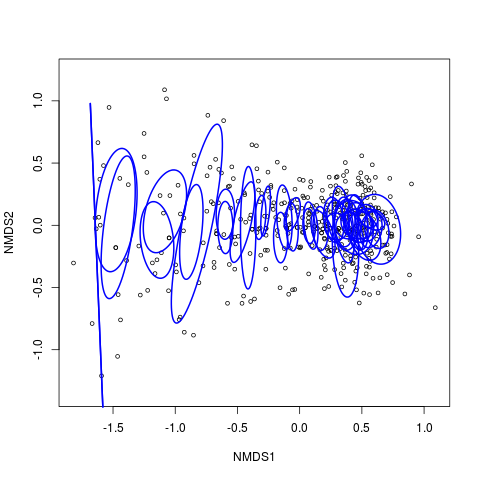

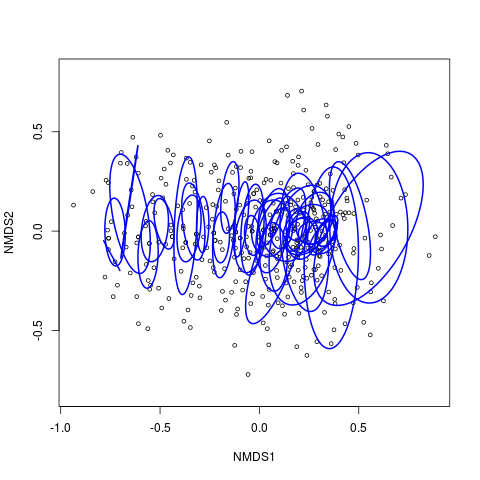

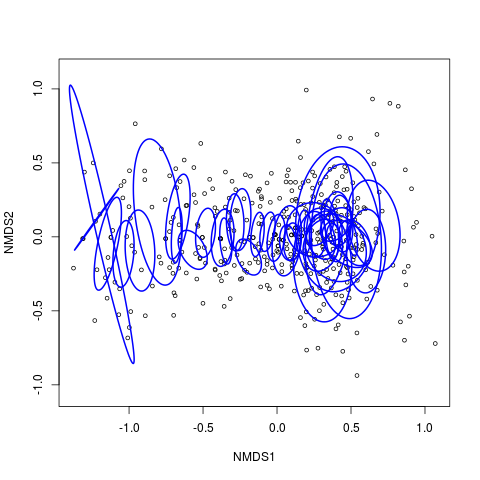

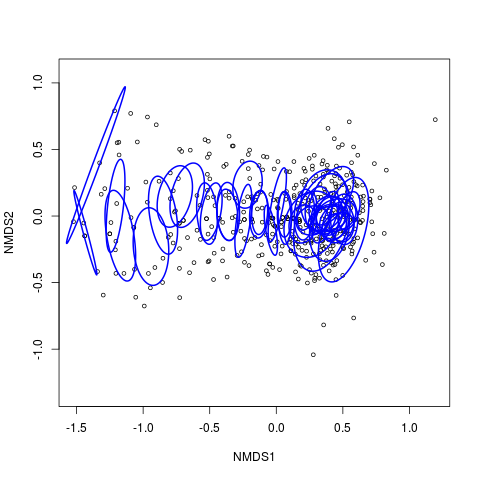

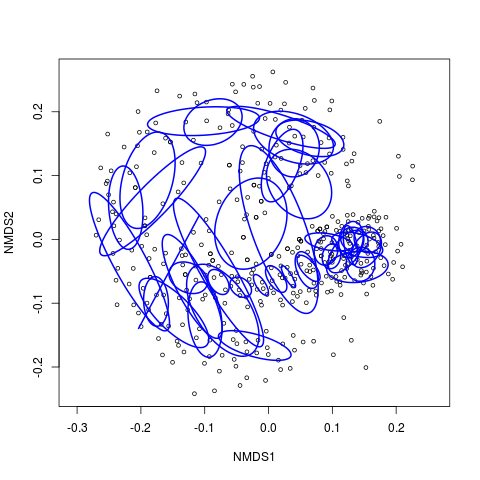

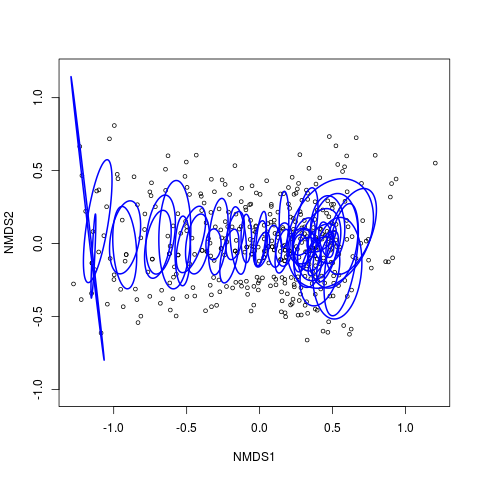

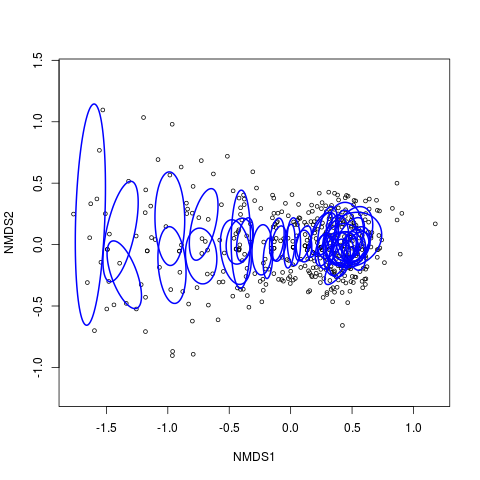

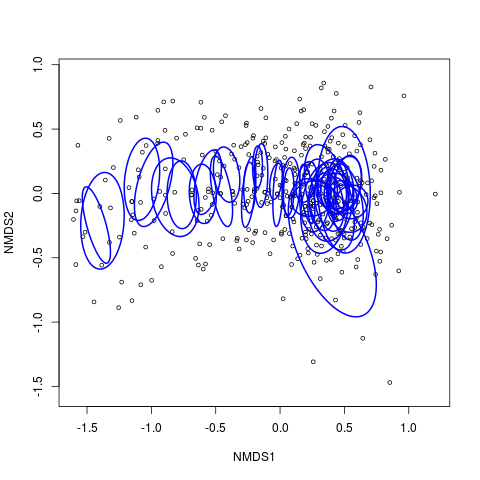

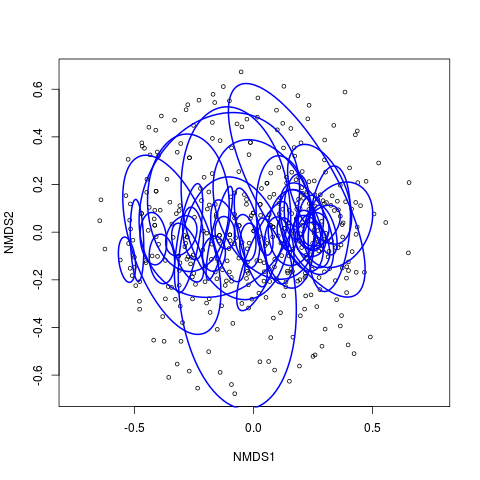

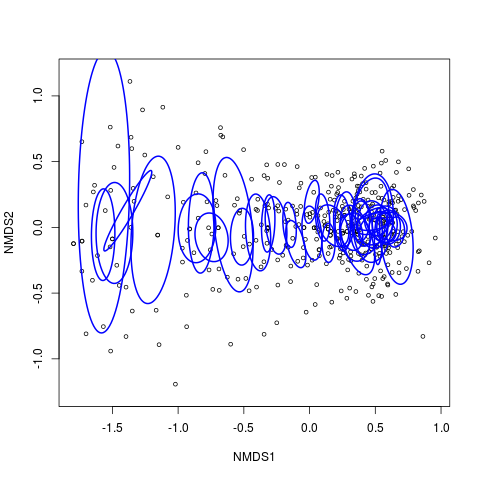

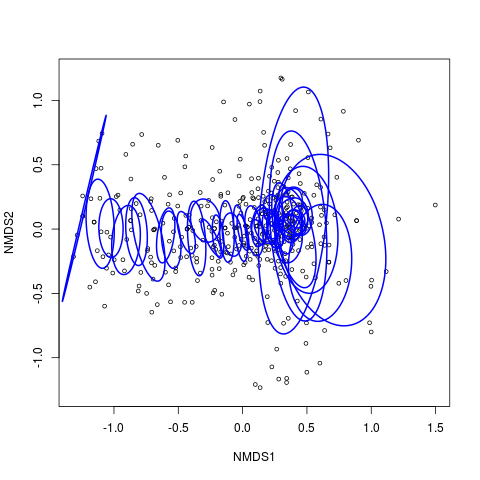

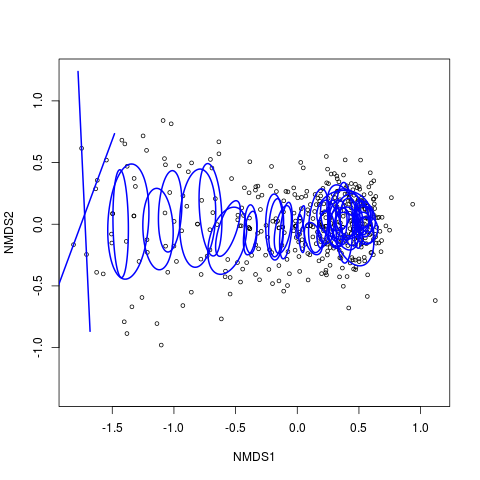

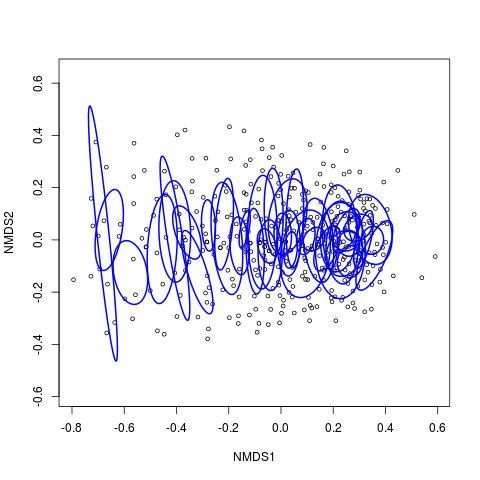

In [167]:
%%R
elps.tbls = apply(tbl, 1, get.ellipses)

In [168]:
%%R

tbl.c = do.call(rbind, elps.tbls)
tbl.c$percIncorp = factor(tbl.c$percIncorp, levels=sort(unique(as.numeric(tbl.c$percIncorp))))
tbl.c$percTaxa = factor(tbl.c$percTaxa, levels=sort(unique(as.numeric(tbl.c$percTaxa))))
tbl.c %>% head

       NMDS1       NMDS2       Area library    BD.range BD.min BD.max BD.mid
1 -1.5641348  0.27275313 0.65747769       1  1.708,1.71  1.708  1.710  1.709
2 -1.4843924 -0.04233845 0.16861984       1  1.71,1.712  1.710  1.712  1.711
3 -1.3825058  0.12660595 0.04950627       1 1.712,1.714  1.712  1.714  1.713
4 -0.8233783  0.03392720 0.11764136       1 1.714,1.716  1.714  1.716  1.715
5 -0.7456088 -0.07559484 0.07260848       1 1.716,1.718  1.716  1.718  1.717
6 -0.3917073 -0.03839674 0.08640746       1  1.718,1.72  1.718  1.720  1.719
  percIncorp percTaxa
1          0       10
2          0       10
3          0       10
4          0       10
5          0       10
6          0       10


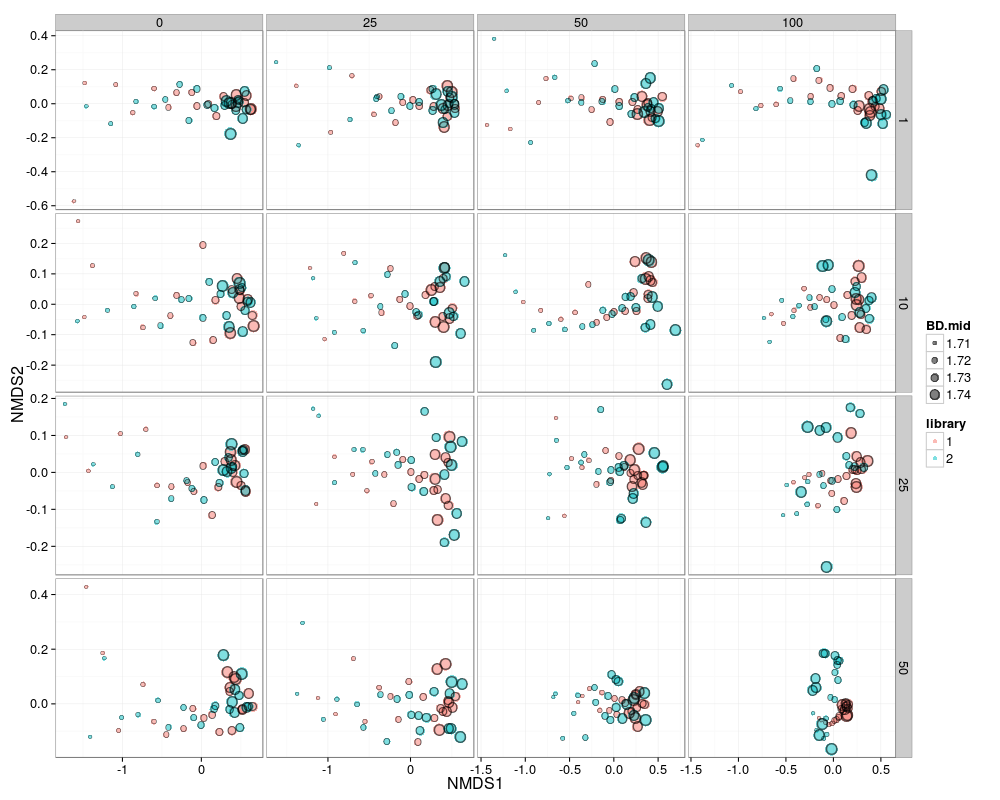

In [169]:
%%R -w 1000 -h 800

ggplot(tbl.c, aes(NMDS1, NMDS2, color=library, size=BD.mid)) +
    geom_point(alpha=0.5) +
    geom_point(color='black', shape='O', alpha=0.6) +
    scale_size_continuous(range=c(2,6)) +
    facet_grid(percTaxa ~ percIncorp, scales='free') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

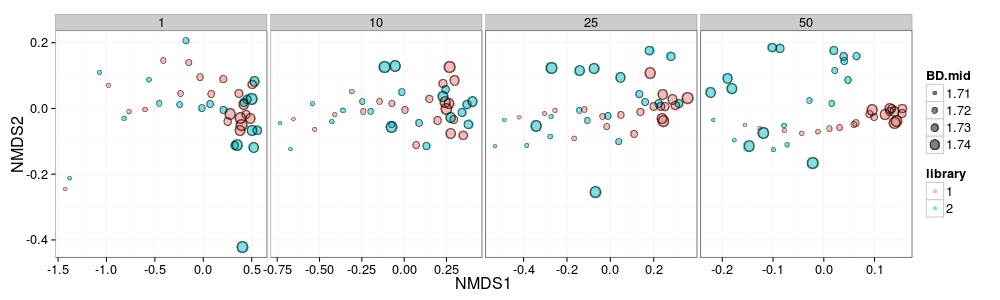

In [170]:
%%R -w 1000 -h 300

tbl.c.f = tbl.c %>%
    filter(percIncorp == 100)

ggplot(tbl.c.f, aes(NMDS1, NMDS2, color=library, size=BD.mid)) +
    geom_point(alpha=0.5) +
    geom_point(color='black', shape='O', alpha=0.6) +
    scale_size_continuous(range=c(2,6)) +
    facet_grid(. ~ percTaxa, scales='free') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

# Indepedent plots

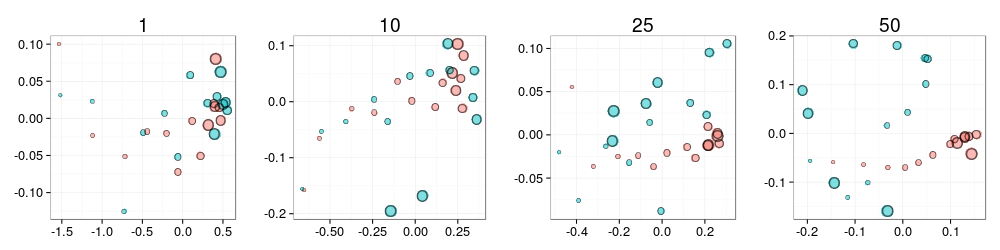

In [164]:
%%R -w 1000 -h 250

tbl.c.f = tbl.c %>%
    filter(percIncorp == 100)

percTaxa.u = tbl.c.f$percTaxa %>% unique %>% sort


make_plot = function(tbl, percTaxa.cut, title=''){
    tbl.f = filter(tbl, percTaxa == percTaxa.cut)
    
    p = ggplot(tbl.f, aes(NMDS1, NMDS2, color=library, size=BD.mid)) +
        geom_point(alpha=0.5) +
        geom_point(color='black', shape='O', alpha=0.6) +
        scale_size_continuous(range=c(2,6)) +
        labs(title=title) +
        theme_bw() +
        theme(
            text = element_text(size=16),
            axis.title.x = element_blank(),
            axis.title.y = element_blank(),
            legend.position = 'none'
            
            )
    return(p)
    }


p1 = make_plot(tbl.c.f, percTaxa.u[1], title=percTaxa.u[1])
p2 = make_plot(tbl.c.f, percTaxa.u[2], title=percTaxa.u[2])
p3 = make_plot(tbl.c.f, percTaxa.u[3], title=percTaxa.u[3])
p4 = make_plot(tbl.c.f, percTaxa.u[4], title=percTaxa.u[4])

grid.arrange(p1,p2,p3,p4,nrow=1)

***

***
# OLD

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2778789 
Run 1 stress 0.2682116 
... New best solution
... procrustes: rmse 0.03657902  max resid 0.1814301 
Run 2 stress 0.2737173 
Run 3 stress 0.2729629 
Run 4 stress 0.2663702 
... New best solution
... procrustes: rmse 0.03717252  max resid 0.1773461 
Run 5 stress 0.2716407 
Run 6 stress 0.2736374 
Run 7 stress 0.270208 
Run 8 stress 0.2658811 
... New best solution
... procrustes: rmse 0.03336031  max resid 0.1934285 
Run 9 stress 0.2722786 
Run 10 stress 0.2743965 
Run 11 stress 0.2713463 
Run 12 stress 0.2723356 
Run 13 stress 0.2720634 
Run 14 stress 0.2739934 
Run 15 stress 0.2687192 
Run 16 stress 0.2745111 
Run 17 stress 0.2683134 
Run 18 stress 0.2704547 
Run 19 stress 0.2659728 
... procrustes: rmse 0.03626291  max resid 0.1879366 
Run 20 stress 0.2688132 


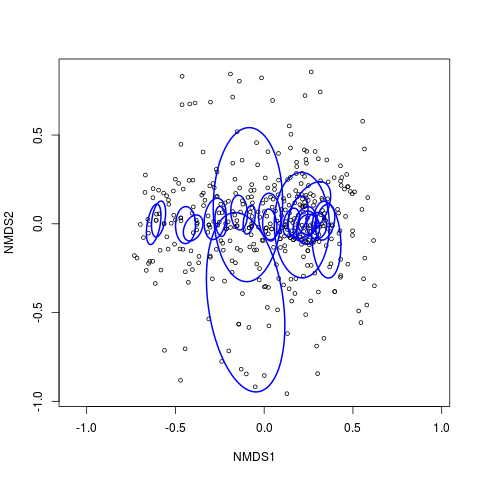

In [52]:
%%R
# test run of functions
files = get.files(tbl[5,'dirs'], base.path=inFileDir, pattern='OTU_n2_abs1e9_sub-norm_filt.physeq')
otu.tbls = get.otu.tbls(files)
otu.tbl = join.otu.tbls(otu.tbls)
# making metadata
meta = make.meta(otu.tbl)
ord = metaMDS(otu.tbl %>% t)
# getting ellipse
plot(ord, type = "p", display='sites')
elps = ordiellipse(ord, groups=meta$groups, kind="se", conf=0.95, lwd=2, col="blue")
# edit ellipse file
elps.tbl = edit.ellipse(elps)

In [44]:
%%R
# ordination of combined OTU table
ord = metaMDS(otu.tbl %>% t)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2778789 
Run 1 stress 0.2740874 
... New best solution
... procrustes: rmse 0.03909948  max resid 0.1566447 
Run 2 stress 0.263295 
... New best solution
... procrustes: rmse 0.03815336  max resid 0.1820028 
Run 3 stress 0.2622787 
... New best solution
... procrustes: rmse 0.03482414  max resid 0.1935661 
Run 4 stress 0.2689901 
Run 5 stress 0.276454 
Run 6 stress 0.2656546 
Run 7 stress 0.2773779 
Run 8 stress 0.2704998 
Run 9 stress 0.2619899 
... New best solution
... procrustes: rmse 0.0354443  max resid 0.1840365 
Run 10 stress 0.2761005 
Run 11 stress 0.270011 
Run 12 stress 0.2707878 
Run 13 stress 0.2671646 
Run 14 stress 0.269292 
Run 15 stress 0.272816 
Run 16 stress 0.2779202 
Run 17 stress 0.2729177 
Run 18 stress 0.2730189 
Run 19 stress 0.2753001 
Run 20 stress 0.2696346 


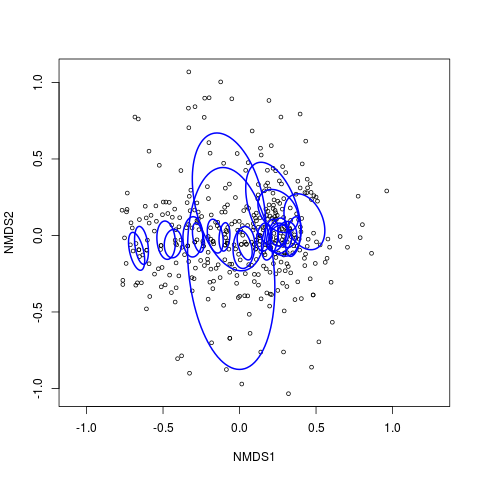

In [45]:
%%R

plot(ord, type = "p", display='sites')
elps = ordiellipse(ord, groups=meta$groups, kind="se", conf=0.95, lwd=2, col="blue")

In [46]:
%%R

# midpoint function
mid = function(x, y){ (x + y)/2 }

elps.tbl = elps %>% summary %>% t %>% as.data.frame
elps.tbl$meta = rownames(elps.tbl)
elps.tbl = elps.tbl %>%
    separate(meta, c('library','BD.range'), sep='__') %>%
    mutate(BD.range = gsub('^.', '', BD.range),
           BD.range = gsub('.$', '', BD.range)) %>%
    separate(BD.range, c('BD.min','BD.max'), sep=',', remove=F) %>%
    mutate(
        BD.min = as.numeric(BD.min),
        BD.max = as.numeric(BD.max),
        BD.mid = mapply(mid, BD.min, BD.max))
    
elps.tbl %>% head

        NMDS1        NMDS2       Area library    BD.range BD.min BD.max BD.mid
1 -0.64078722 -0.064522299 0.01671614       1 1.708,1.712  1.708  1.712  1.710
2 -0.43401295 -0.052903995 0.01684263       1 1.712,1.716  1.712  1.716  1.714
3 -0.26978814 -0.013581894 0.01052575       1  1.716,1.72  1.716  1.720  1.718
4 -0.09839450 -0.009202702 0.01019477       1  1.72,1.724  1.720  1.724  1.722
5  0.03367155 -0.063996674 0.01297468       1 1.724,1.728  1.724  1.728  1.726
6  0.16095586 -0.010542351 0.01396157       1 1.728,1.732  1.728  1.732  1.730


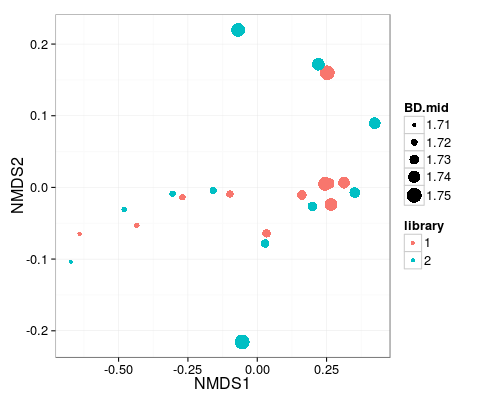

In [47]:
%%R -h 400

ggplot(elps.tbl, aes(NMDS1, NMDS2, color=library, size=BD.mid)) +
    geom_point() +
    scale_size_continuous(range=c(2,7)) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

***

# OLD

In [22]:
%%R -i inFileDir

files = list.files(inFileDir, pattern='OTU_n2_abs1e9_sub-norm_filt.physeq', recursive=T) %>% as.data.frame
colnames(files) = c('files')
files %>% head

                                       files
1 0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq
2 0/10/11/OTU_n2_abs1e9_sub-norm_filt.physeq
3 0/10/12/OTU_n2_abs1e9_sub-norm_filt.physeq
4 0/10/13/OTU_n2_abs1e9_sub-norm_filt.physeq
5 0/10/14/OTU_n2_abs1e9_sub-norm_filt.physeq
6 0/10/15/OTU_n2_abs1e9_sub-norm_filt.physeq


In [24]:
%%R
# file metadata
percTaxa.to.keep = c(1,10,25,50)

tbl = files %>%
    separate(files, c('percIncorp','percTaxa','rep','file'), sep='/', remove=F) %>%
    filter(percIncorp == 100, percTaxa %in% percTaxa.to.keep)
tbl %>% nrow %>% print
tbl %>% head

[1] 80
                                         files percIncorp percTaxa rep
1 100/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq        100       10  10
2 100/10/11/OTU_n2_abs1e9_sub-norm_filt.physeq        100       10  11
3 100/10/12/OTU_n2_abs1e9_sub-norm_filt.physeq        100       10  12
4 100/10/13/OTU_n2_abs1e9_sub-norm_filt.physeq        100       10  13
5 100/10/14/OTU_n2_abs1e9_sub-norm_filt.physeq        100       10  14
6 100/10/15/OTU_n2_abs1e9_sub-norm_filt.physeq        100       10  15
                                file
1 OTU_n2_abs1e9_sub-norm_filt.physeq
2 OTU_n2_abs1e9_sub-norm_filt.physeq
3 OTU_n2_abs1e9_sub-norm_filt.physeq
4 OTU_n2_abs1e9_sub-norm_filt.physeq
5 OTU_n2_abs1e9_sub-norm_filt.physeq
6 OTU_n2_abs1e9_sub-norm_filt.physeq


In [25]:
%%R -i workDir

tbl.l = list()
for(i in tbl$files){
    p = paste(c(workDir, 'atomIncorp_taxaIncorp', i), collapse='/')
    ord = readRDS(p)
    
    id = gsub('/[^/]+$', '', i)
    id = gsub('/', '__', id)
    id = paste(c(id,'__'), collapse='')
    otu.tbl = ord %>% otu_table %>% as.data.frame
    colnames(otu.tbl) = gsub('^', id, colnames(otu.tbl))
    otu.tbl$taxon = rownames(otu.tbl)
    tbl.l[[i]] = otu.tbl
    
    #    otu.tbl %>% head %>% print; break
    
    #samp.data = tbl.l[[i]] %>% sample_data %>% as.data.frame
    #samp.data$file = i
    #sample_data(tbl.l[[i]]) = samp.data
    
    
    #ord = ordinate(physeq, method='NMDS', distance='bray')
    #tbl.l[[i]] = ord
    }

exmp = tbl.l[[names(tbl.l)[1]]] 

In [10]:
%%R
# joining all OTU tables

n = names(tbl.l)

tbl = tbl.l[[n[1]]]
for (i in seq(2:length(n))){
    n.i = n[i]
    tbl = left_join(tbl, tbl.l[[n.i]], c('taxon'='taxon'))
    }

# edit table
tbl[is.na(tbl)] = 0
rownames(tbl) = tbl$taxon
tbl$taxon = NULL

In [11]:
%%R
tbl %>% ncol %>% print
tbl %>% nrow %>% print
tbl[1:5,1:5]

[1] 8062
[1] 484
                                     0__10__10__1__1.710-1.711.x
Acaryochloris_marina_MBIC11017                               211
Acetobacter_pasteurianus_IFO_3283-12                         199
Acetohalobium_arabaticum_DSM_5501                              0
Achromobacter_xylosoxidans_A8                                  2
Acidaminococcus_fermentans_DSM_20731                          14
                                     0__10__10__1__1.711-1.714.x
Acaryochloris_marina_MBIC11017                                82
Acetobacter_pasteurianus_IFO_3283-12                         229
Acetohalobium_arabaticum_DSM_5501                              0
Achromobacter_xylosoxidans_A8                                  1
Acidaminococcus_fermentans_DSM_20731                          18
                                     0__10__10__1__1.714-1.719.x
Acaryochloris_marina_MBIC11017                                 5
Acetobacter_pasteurianus_IFO_3283-12                          62
Acetohal

In [12]:
%%R
# creating metadata table

meta = tbl %>% colnames %>% as.data.frame 
colnames(meta) = c('X')
meta = filter(meta, X != 'taxon')

# midpoint function
mid = function(x, y){ (x + y)/2 }

# making fixed BD-range
BD.range = seq(1.6, 1.9, 0.004)

# edit metadata
meta = meta %>%
    separate(X, c('percIncorp','percTaxa','rep','library','BD_range'), sep='__', remove=F) %>%
    mutate(BD_range = gsub('.x$', '', BD_range)) %>%
    separate(BD_range, c('BD.min', 'BD.max'), sep='-') %>%
    mutate(BD.min = as.numeric(BD.min),
           BD.max = as.numeric(BD.max),
           BD.mid = mapply(mid, BD.min, BD.max),   
           BD.bin = cut(BD.mid, breaks=BD.range))

meta %>% head

                            X percIncorp percTaxa rep library BD.min BD.max
1 0__10__10__1__1.710-1.711.x          0       10  10       1  1.710  1.711
2 0__10__10__1__1.711-1.714.x          0       10  10       1  1.711  1.714
3 0__10__10__1__1.714-1.719.x          0       10  10       1  1.714  1.719
4 0__10__10__1__1.719-1.725.x          0       10  10       1  1.719  1.725
5 0__10__10__1__1.725-1.732.x          0       10  10       1  1.725  1.732
6 0__10__10__1__1.732-1.737.x          0       10  10       1  1.732  1.737
  BD.mid        BD.bin
1 1.7105 (1.708,1.712]
2 1.7125 (1.712,1.716]
3 1.7165  (1.716,1.72]
4 1.7220  (1.72,1.724]
5 1.7285 (1.728,1.732]
6 1.7345 (1.732,1.736]


In [14]:
%%R
# test table

tbl.test = tbl[,1:100]

In [15]:
%%R
# ordination of combined OTU table

ord = metaMDS(tbl.test %>% t)
## Start from previous best solution
ord = metaMDS(tbl.test %>% t, previous.best = ord)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1623307 
Run 1 stress 0.1731224 
Run 2 stress 0.165822 
Run 3 stress 0.1716225 
Run 4 stress 0.1705758 
Run 5 stress 0.1650397 
Run 6 stress 0.1653182 
Run 7 stress 0.1623307 
... procrustes: rmse 1.117674e-05  max resid 5.566491e-05 
*** Solution reached
Square root transformation
Wisconsin double standardization
Starting from 2-dimensional configuration
Run 0 stress 0.1623307 
Run 1 stress 0.162311 
... New best solution
... procrustes: rmse 0.002547498  max resid 0.01668618 
Run 2 stress 0.1658162 
Run 3 stress 0.1890312 
Run 4 stress 0.1740537 
Run 5 stress 0.1856413 
Run 6 stress 0.1888861 
Run 7 stress 0.162311 
... New best solution
... procrustes: rmse 1.096711e-05  max resid 4.151778e-05 
*** Solution reached


In [16]:
%%R

plot(ord, type = "p", display='sites')
elps = ordiellipse(ord, groups=meta$BD.bin, kind="se", conf=0.95, lwd=2, col="blue")

Error in pts[gr, ] : subscript out of bounds
In addition: Warning messages:
1: In mutate_impl(.data, dots) : NAs introduced by coercion
2: In complete.cases(pts) & !is.na(groups) :
  longer object length is not a multiple of shorter object length
Error in pts[gr, ] : subscript out of bounds


In [17]:
%%R

elps = elps %>% summary %>% t %>% as.data.frame
elps

Error in eval(expr, envir, enclos) : object 'elps' not found


In [18]:
%%R

ggplot(elps, aes(NMDS1, NMDS2)) +
    geom_point()

Error in ggplot(elps, aes(NMDS1, NMDS2)) : object 'elps' not found


# WAITING

***

# OLD

In [40]:
%%R
# getting list of BD-value tables

# making fixed BD-range
BD.range = seq(1.6, 1.9, 0.004)

# midpoint function
mid = function(x, y){ (x + y)/2 }

# defining BD range & binning
get.BD.range = function(ord, BD.range){
    tbl = ord %>% scores %>% as.data.frame
    
    # metadata from rowname
    tbl$lib = gsub('__.+', '', rownames(tbl)) %>% as.character
    tbl$BD.start = gsub('.+__([0-9.]+)-.+', '\\1', rownames(tbl)) %>% as.numeric
    tbl$BD.end = gsub('.+-', '', rownames(tbl)) %>% as.numeric
    tbl$BD.mid = mapply(mid, tbl$BD.start, tbl$BD.end)
    
    # binning BD.mid
    tbl$BD.bin = cut(tbl$BD.mid, breaks=BD.range)
    tbl = unite(tbl, group, lib, BD.bin, sep='__')
    
    return(tbl)
    }

tbl.l.BD = lapply(tbl.l, get.BD.range, BD.range=BD.range)

In [41]:
%%R
# combining lists

tbl.l.c = list()
for(f in names(tbl.l)){
    tbl.l.c[[f]][['ord']] = tbl.l[[f]]
    tbl.l.c[[f]][['meta']] = tbl.l.BD[[f]]
    }

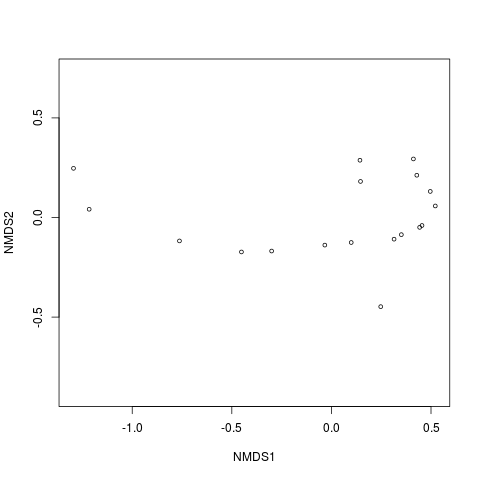

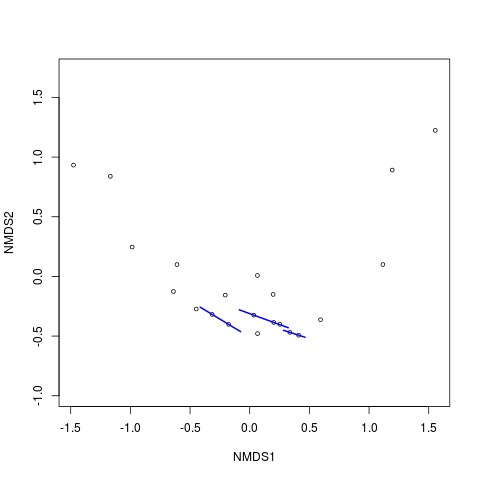

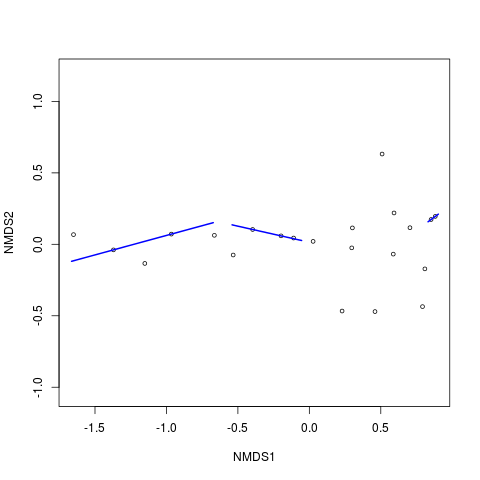

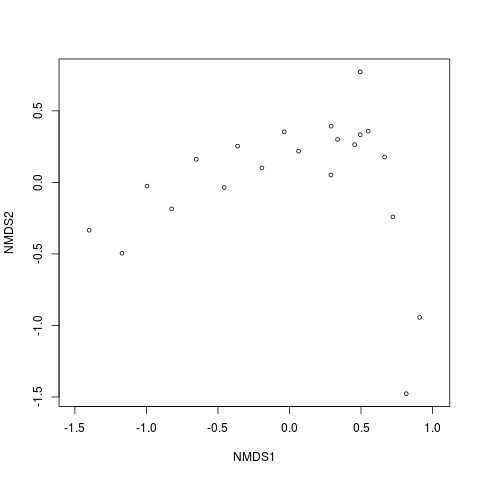

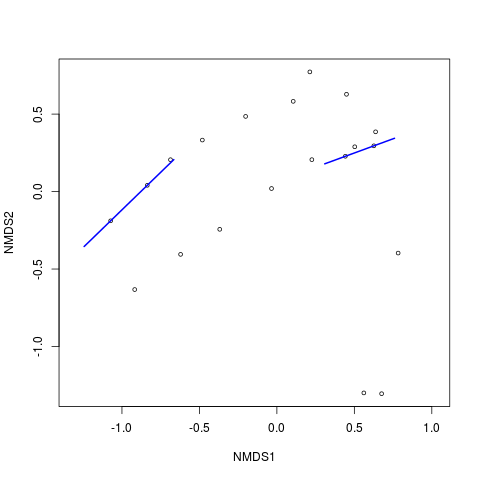

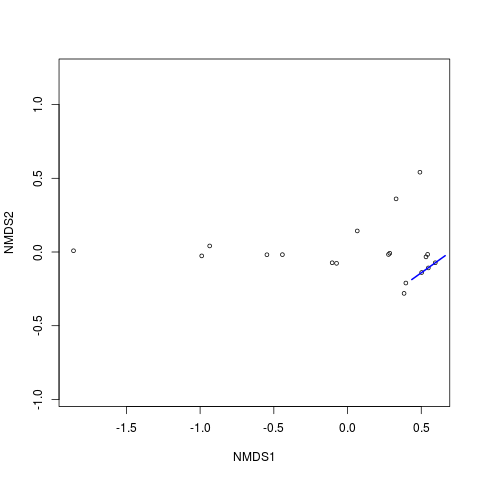

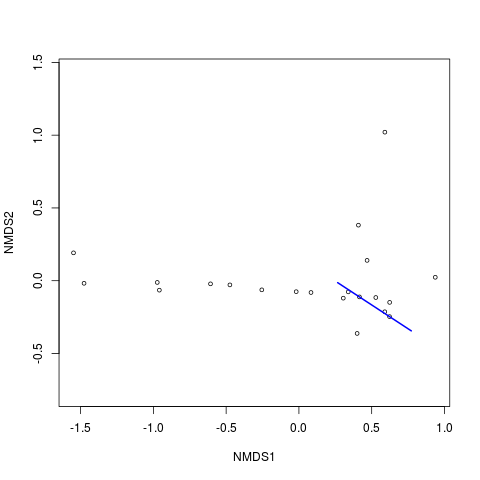

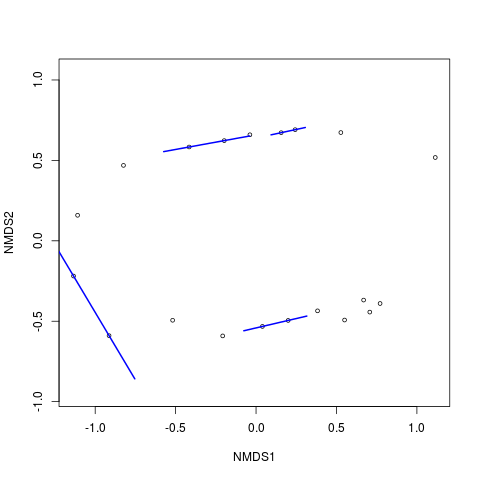

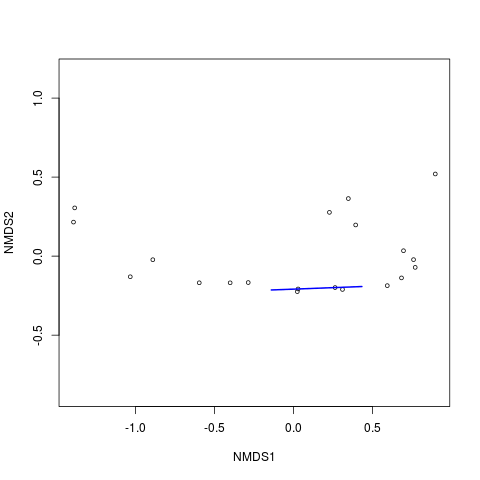

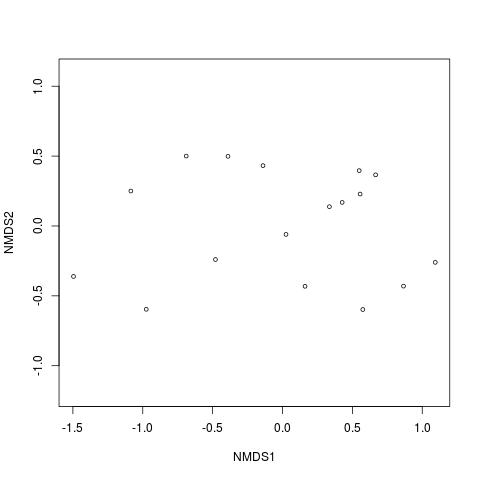

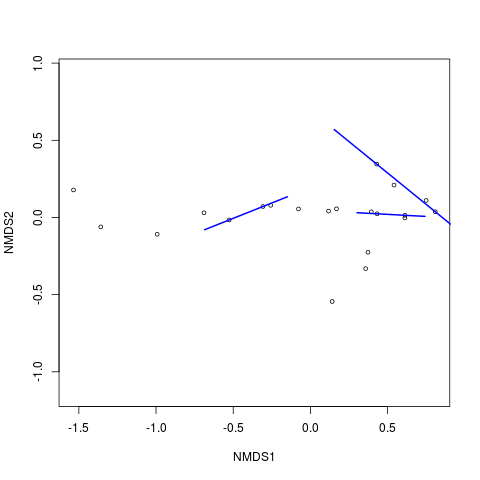

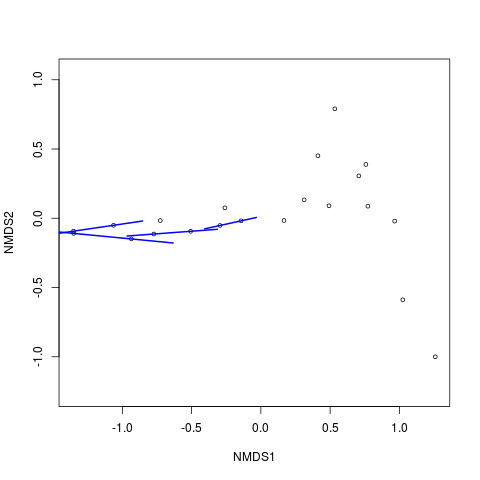

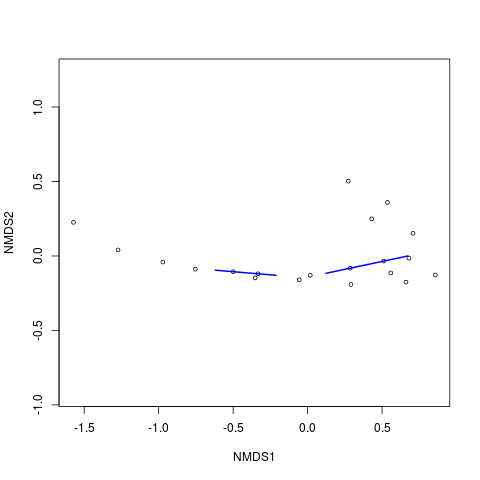

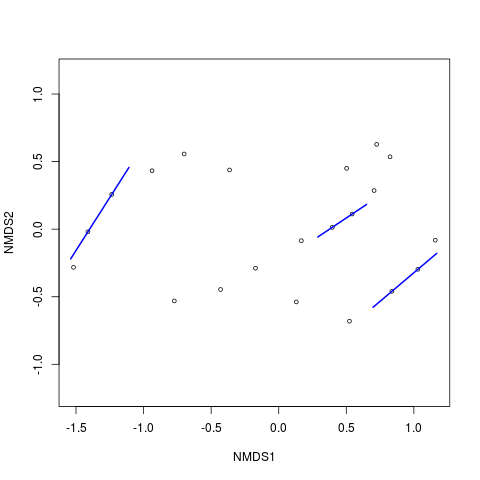

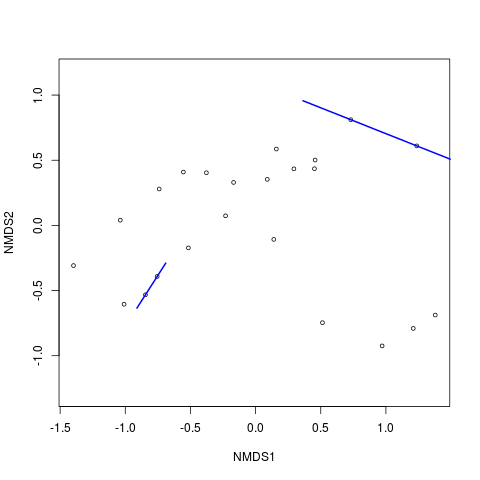

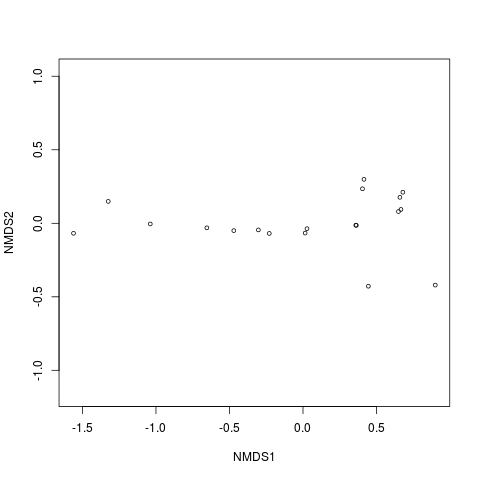

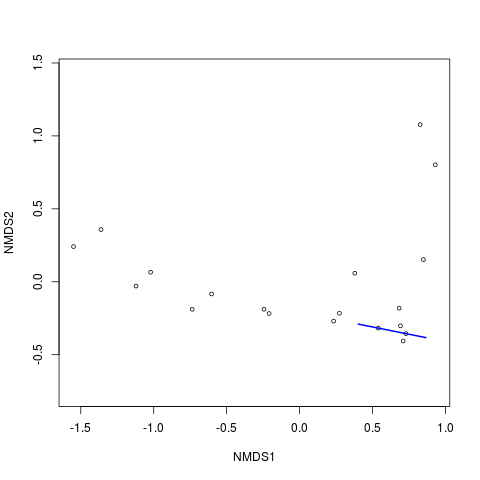

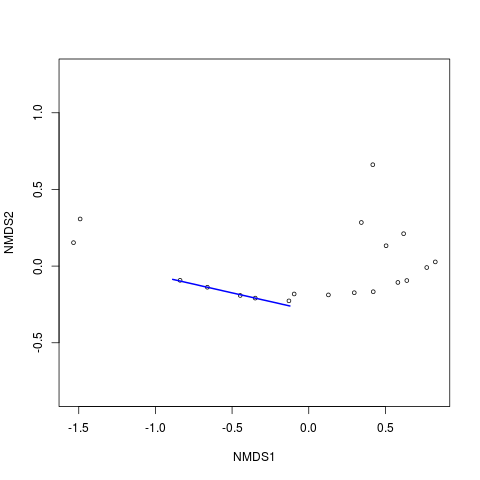

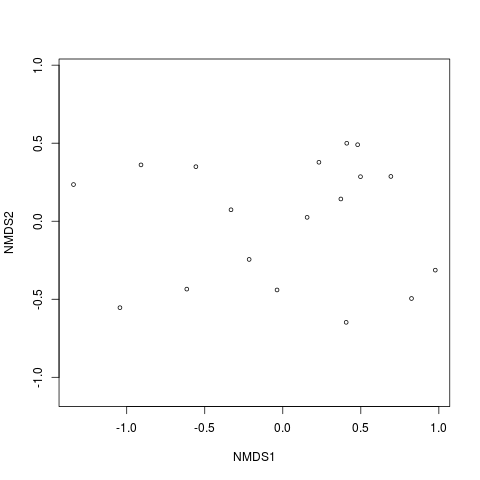

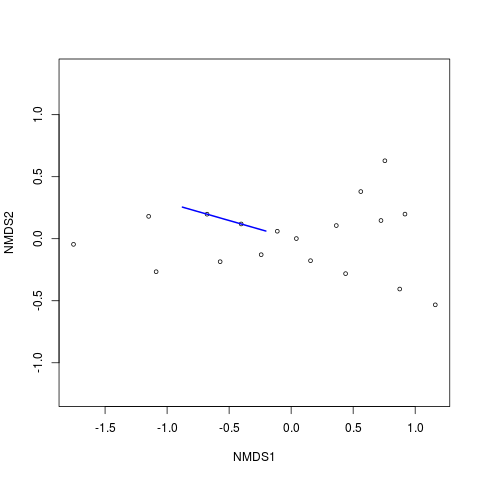

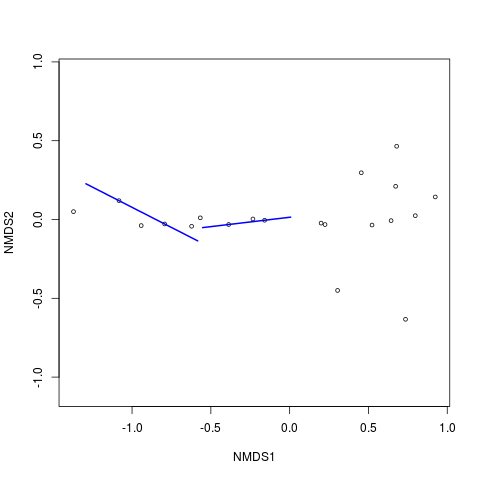

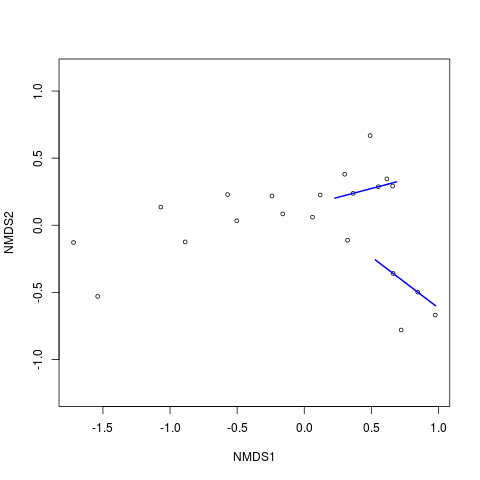

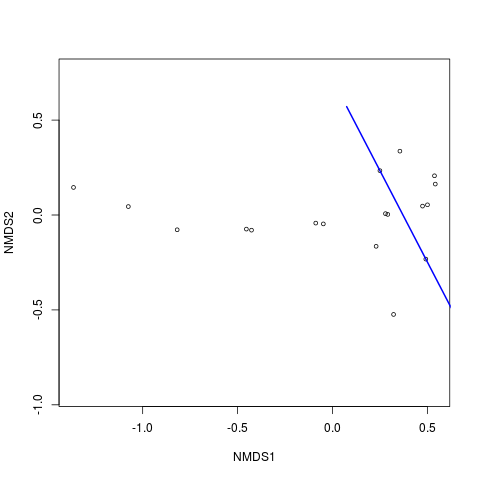

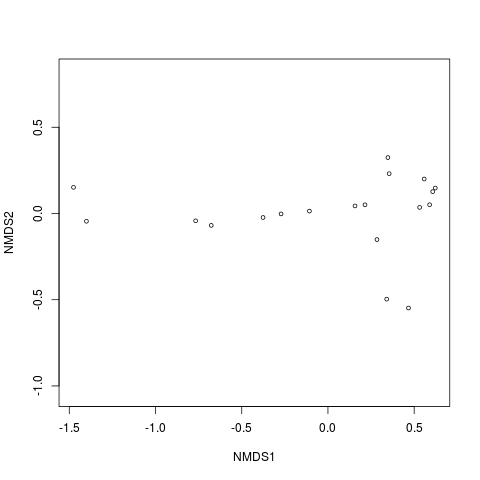

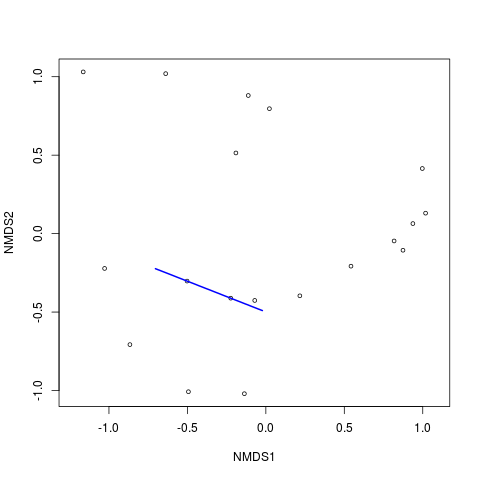

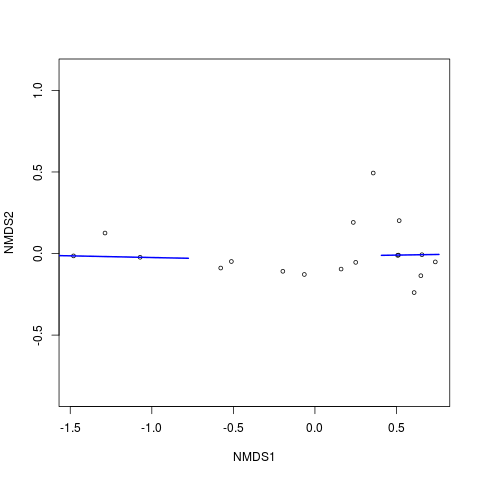

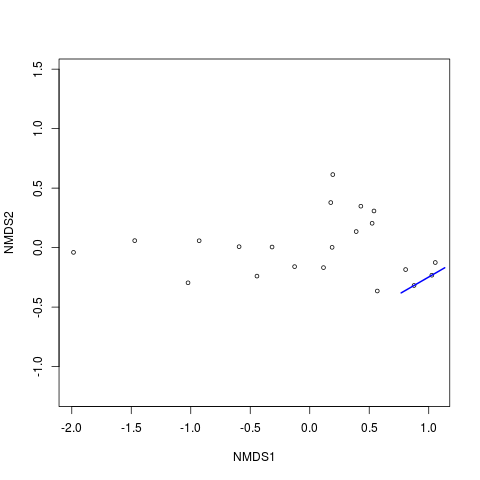

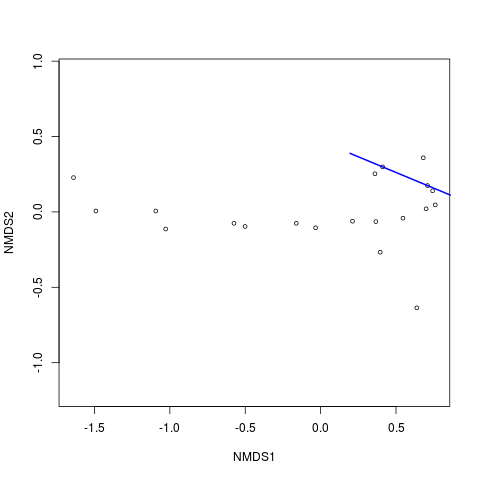

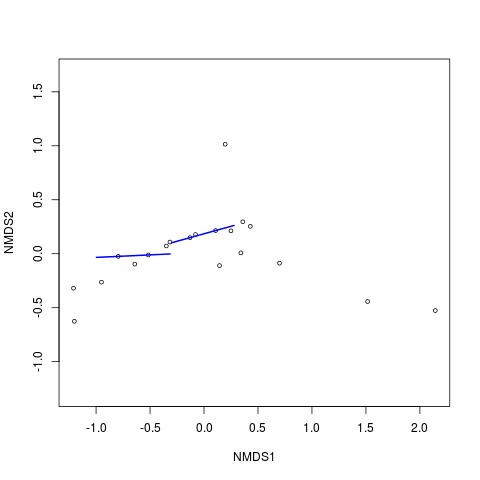

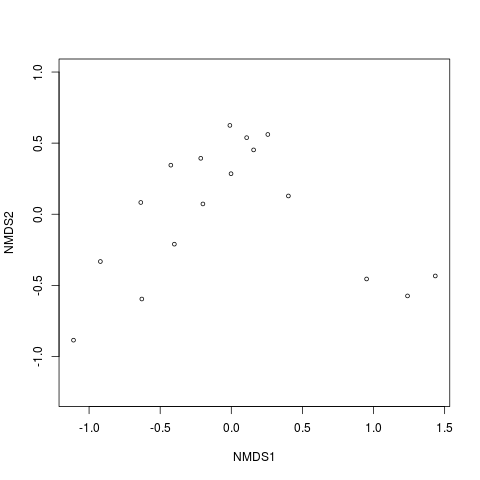

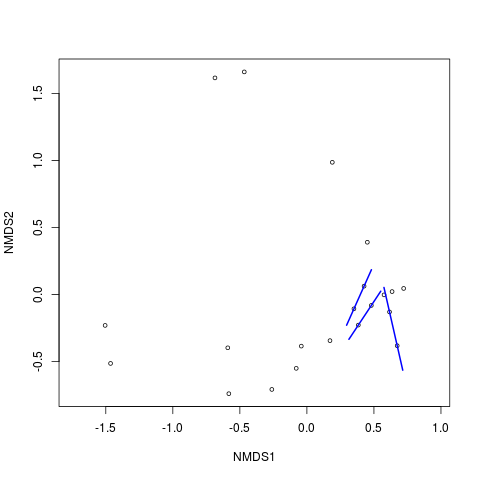

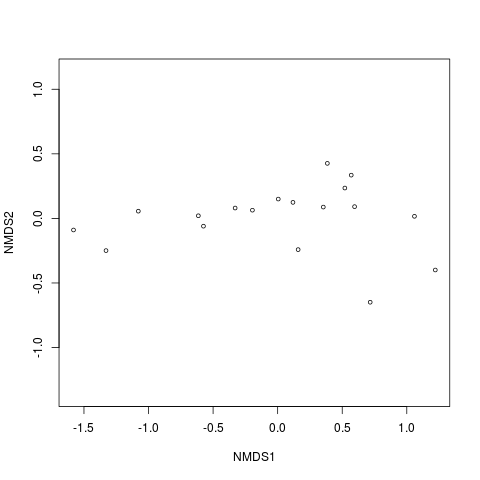

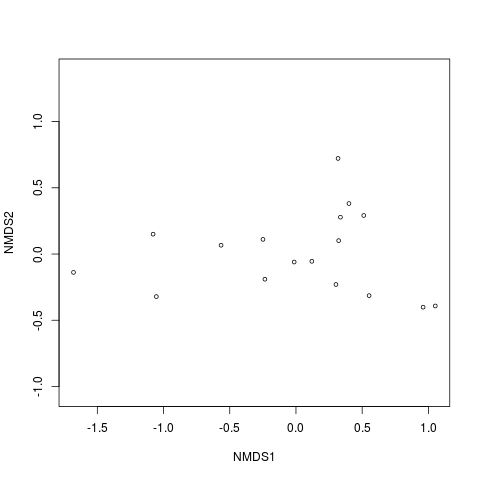

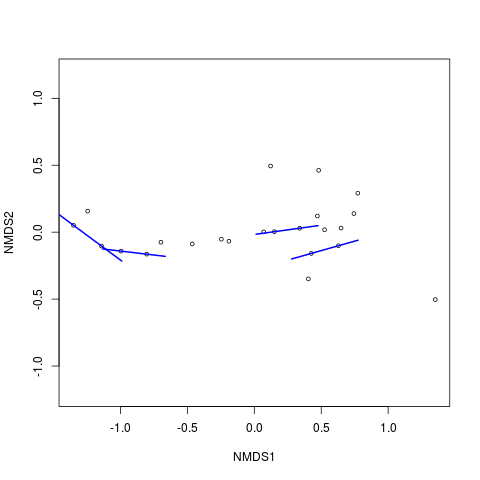

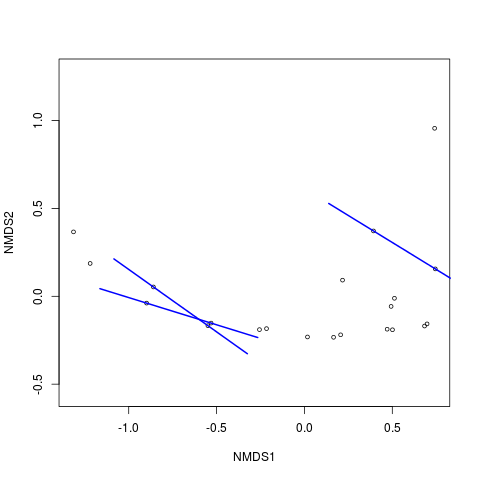

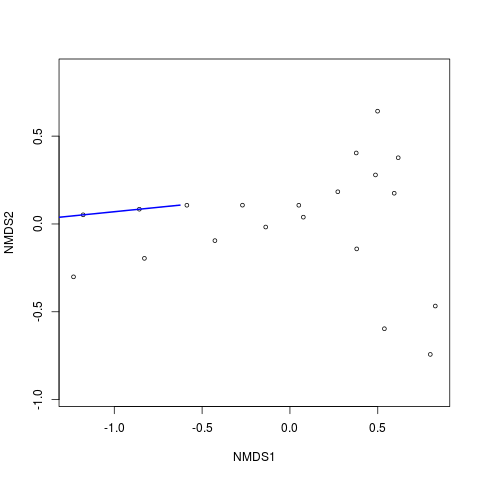

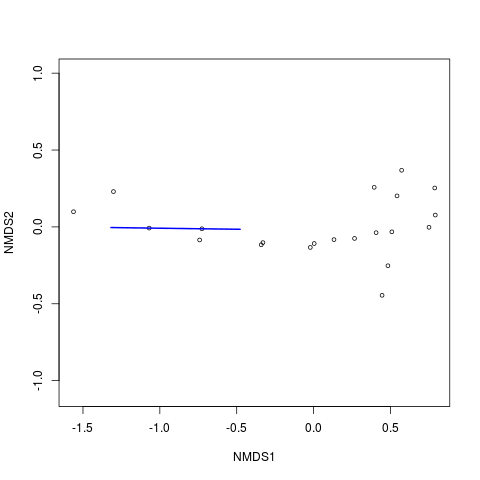

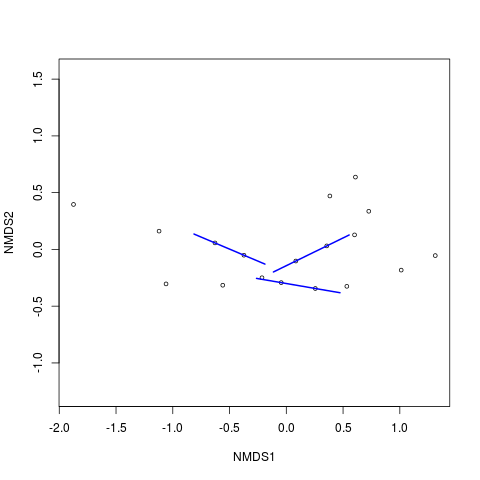

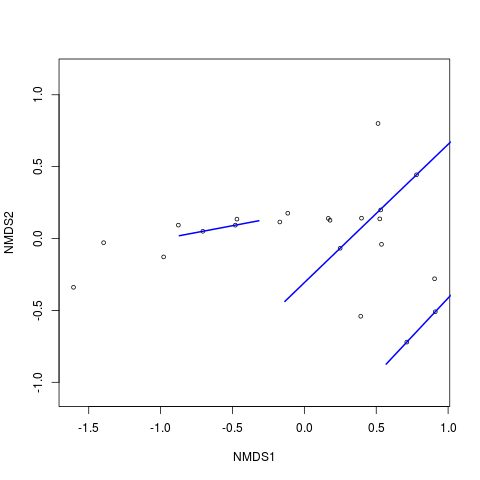

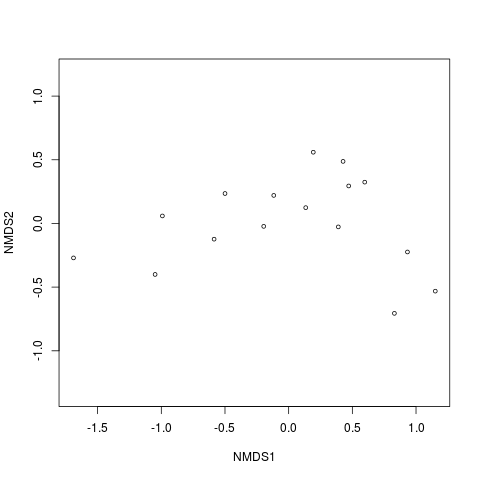

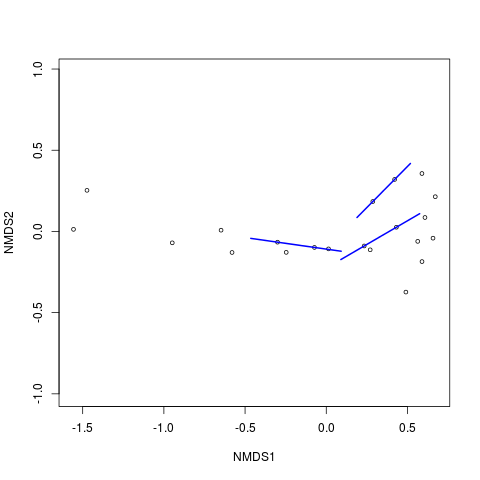

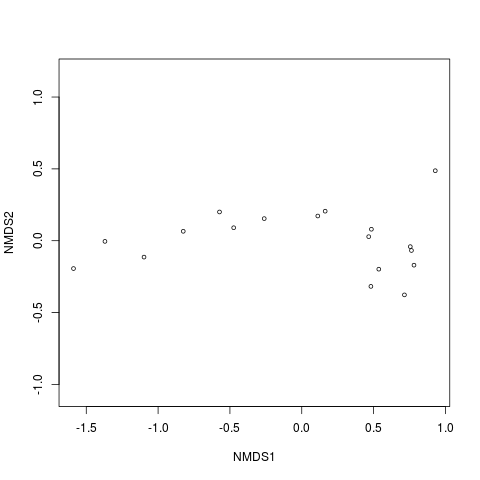

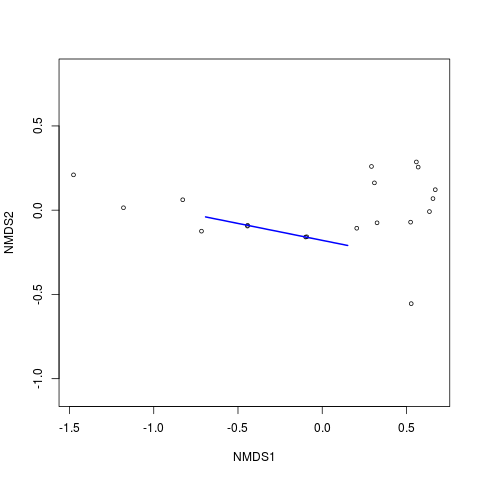

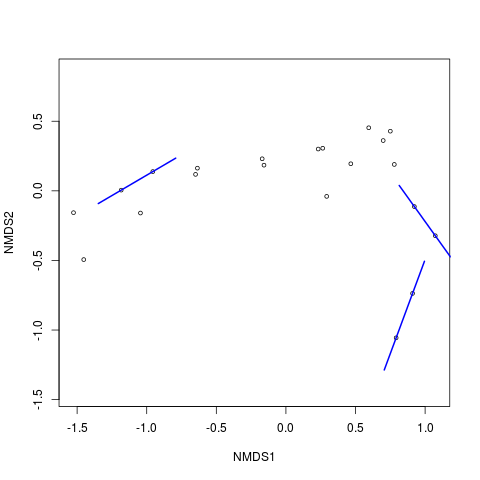

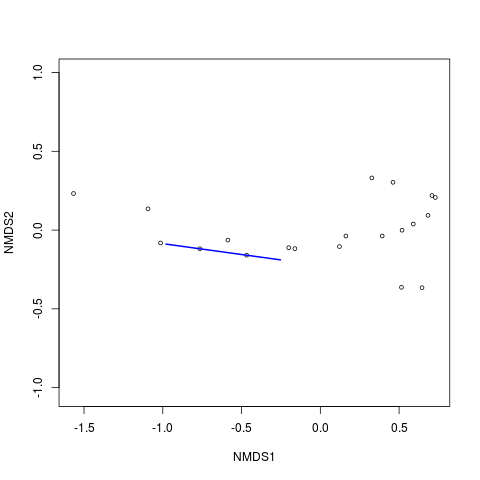

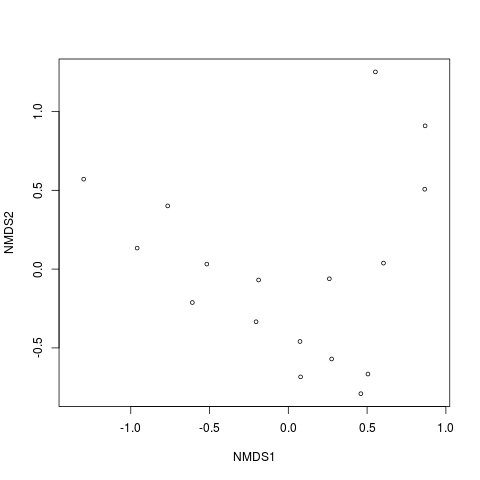

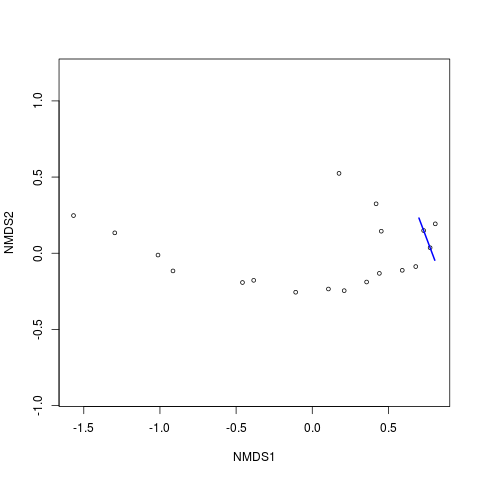

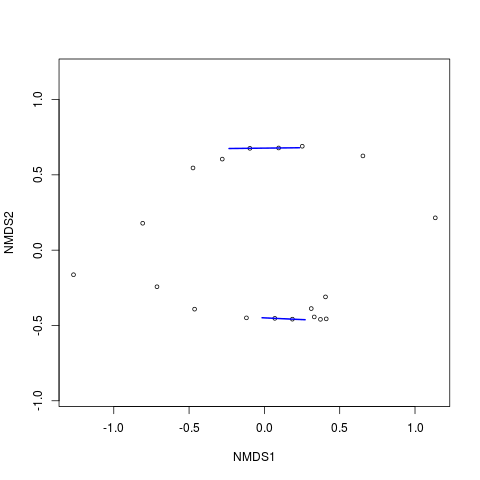

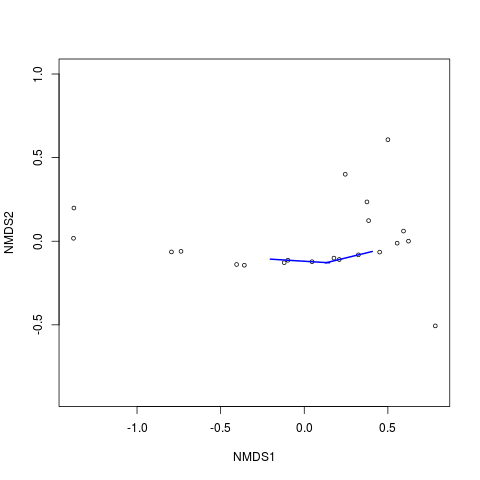

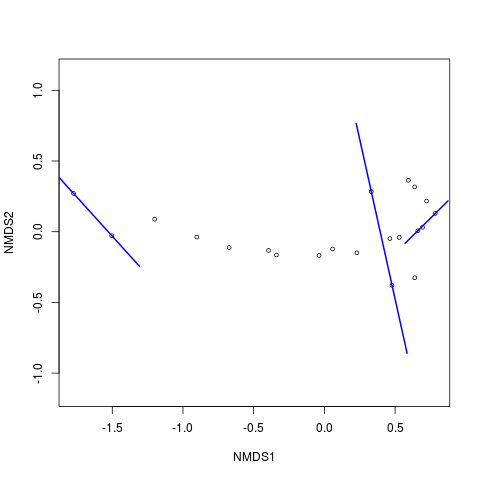

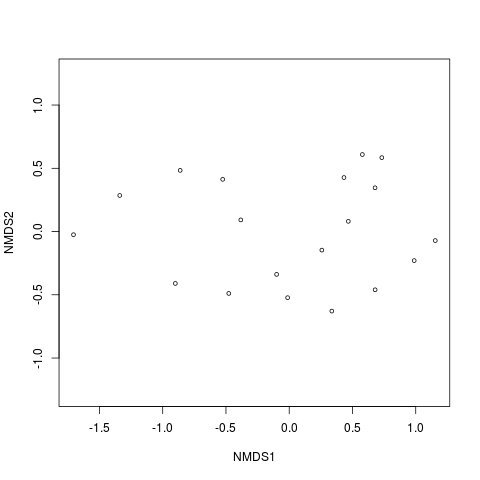

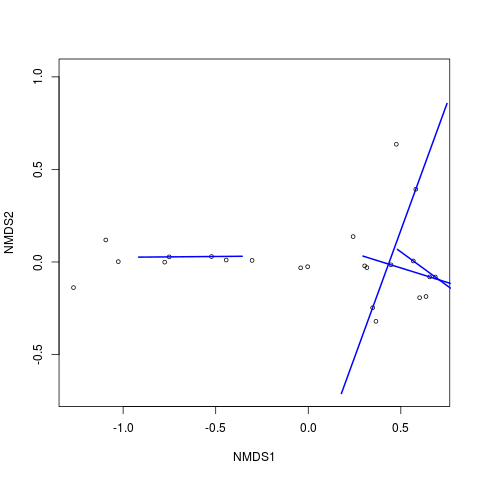

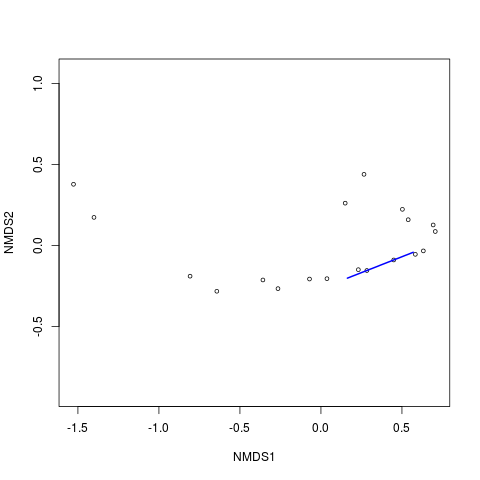

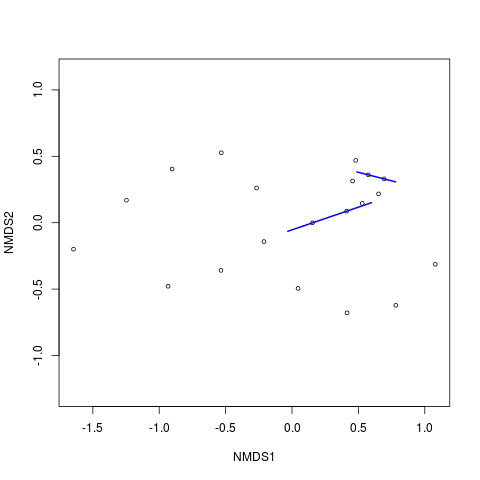

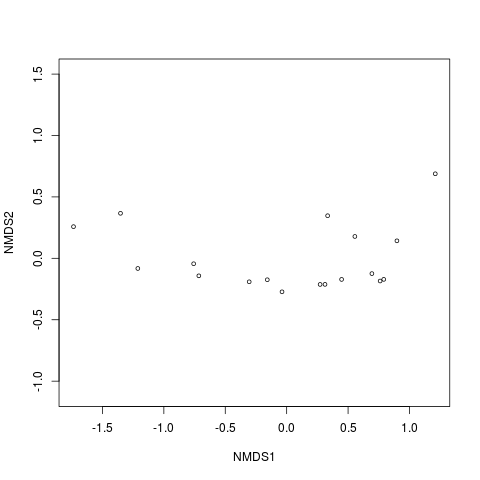

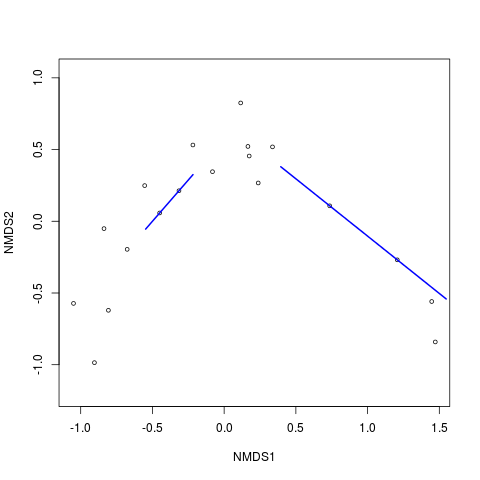

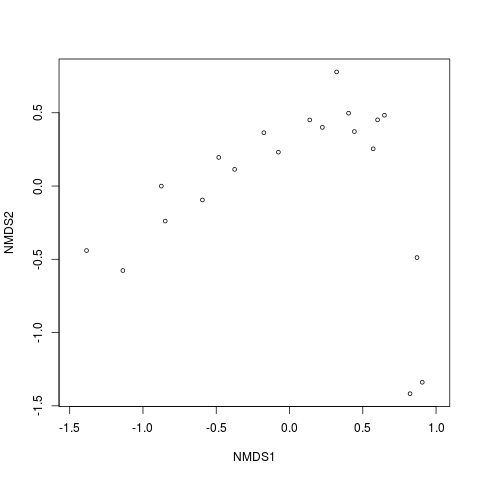

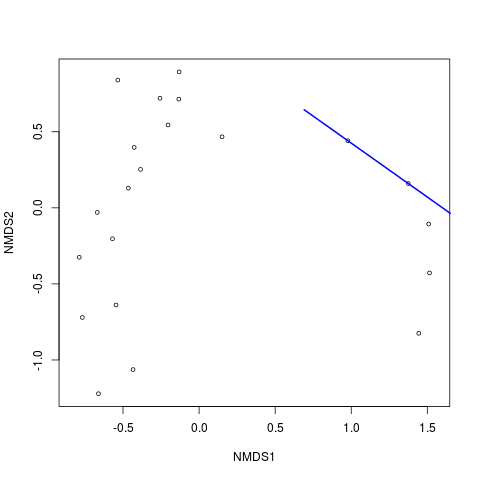

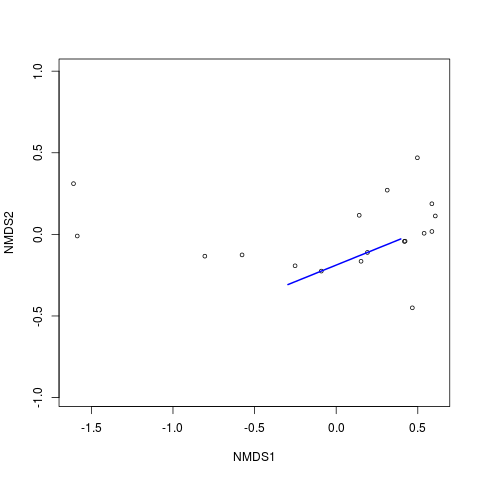

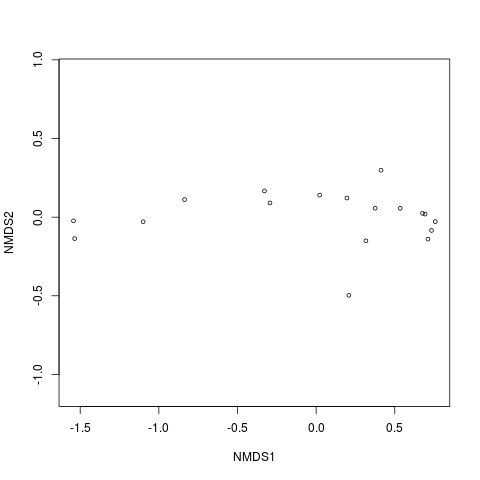

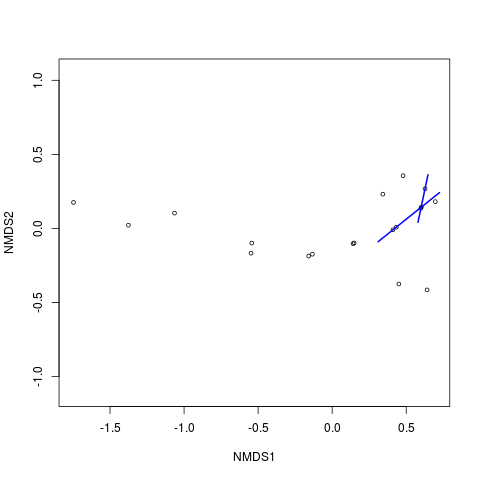

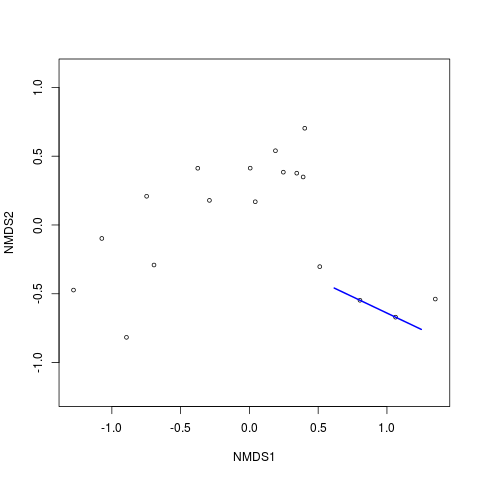

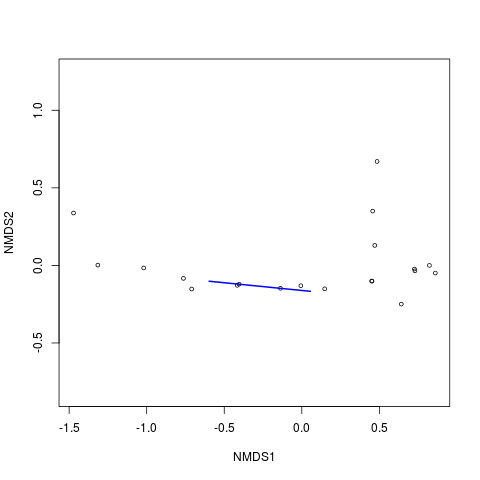

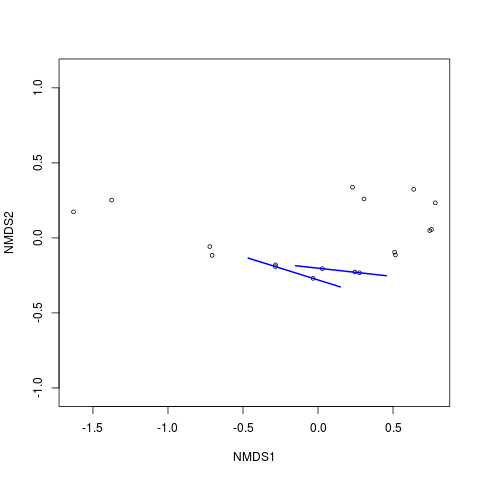

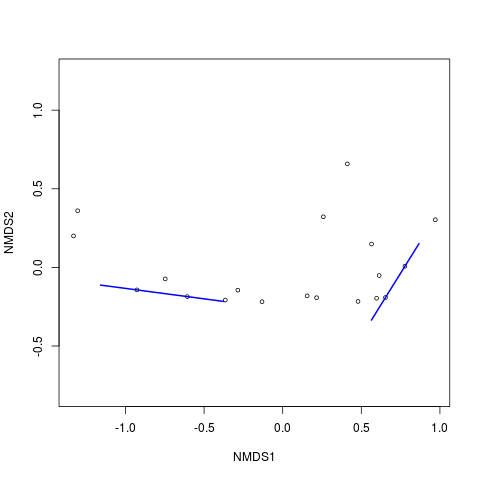

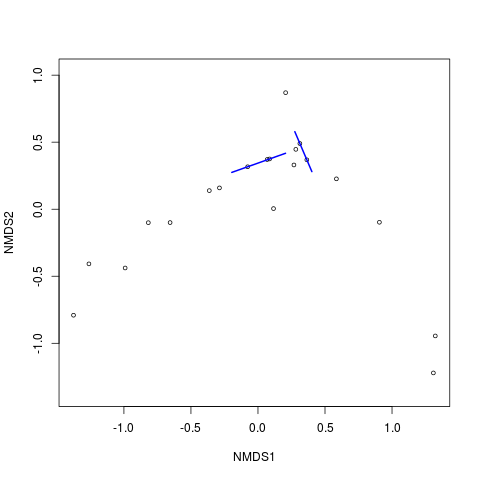

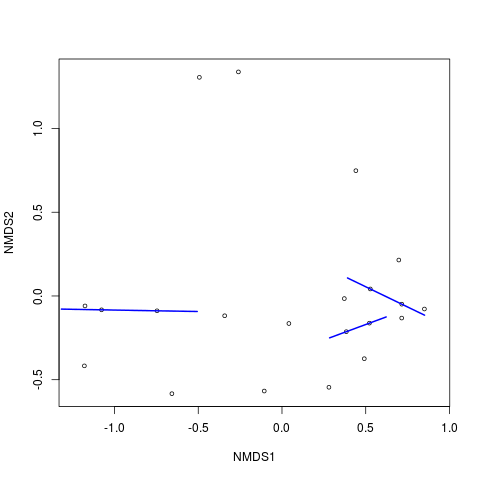

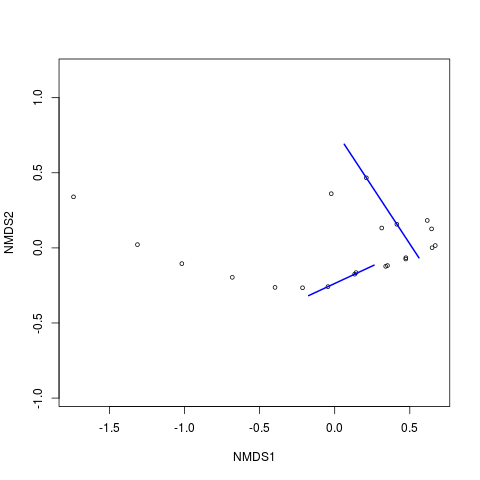

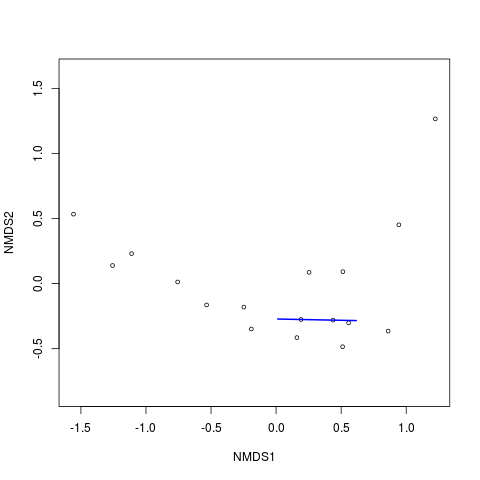

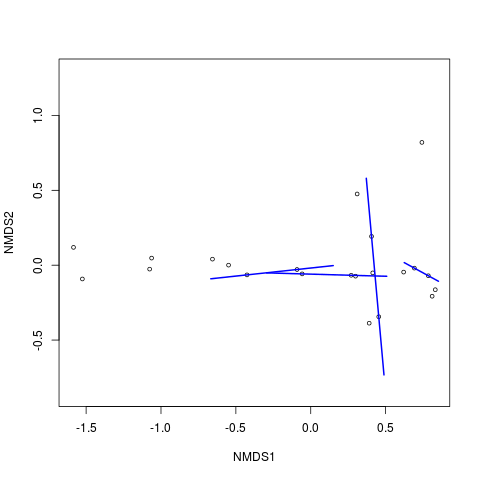

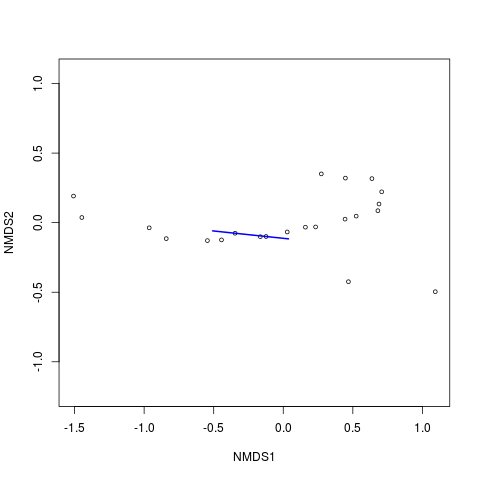

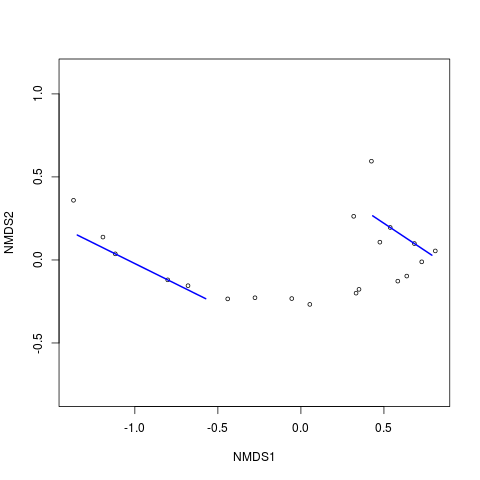

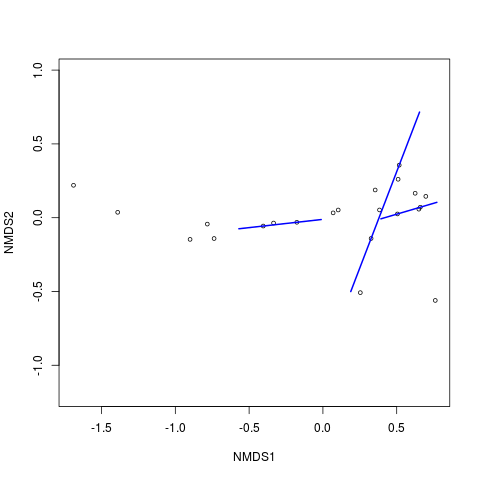

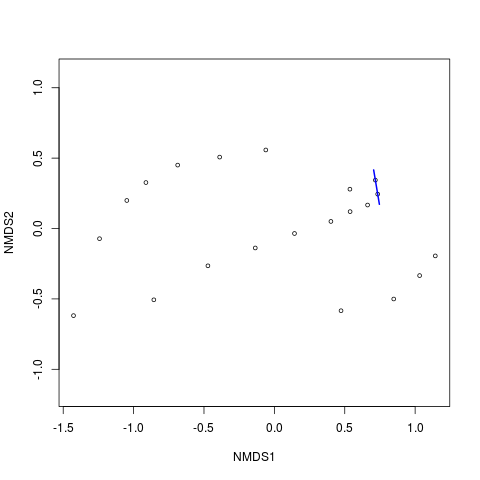

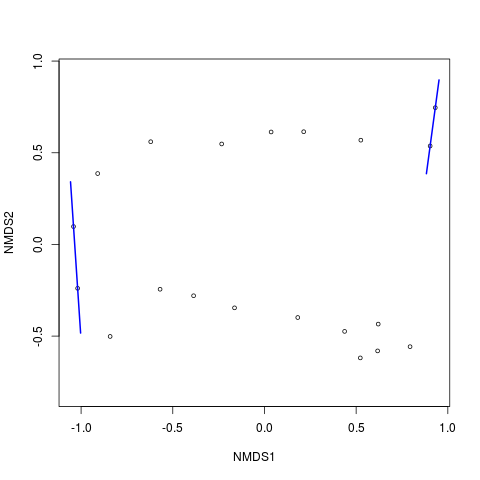

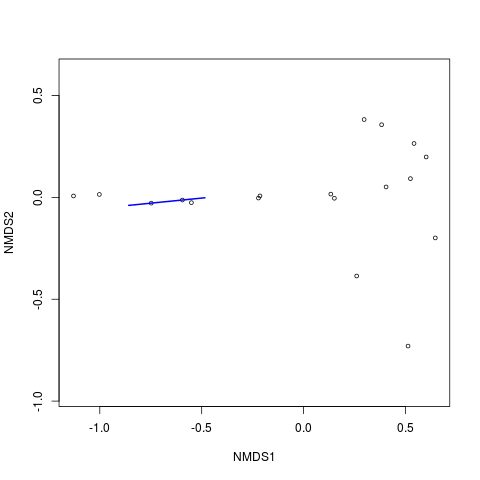

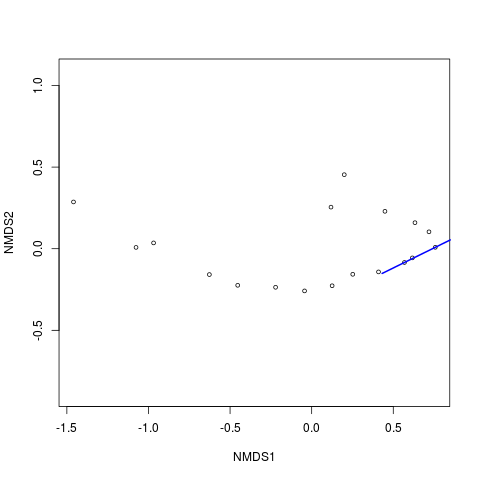

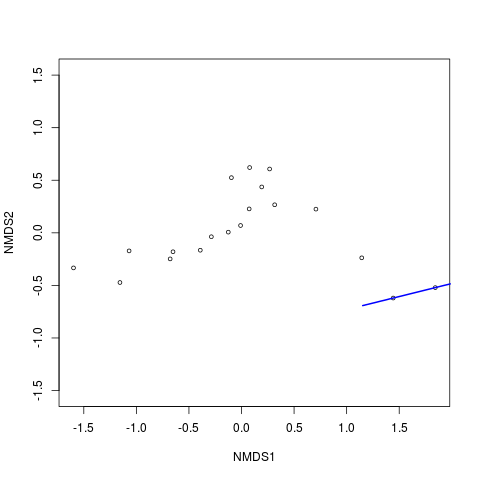

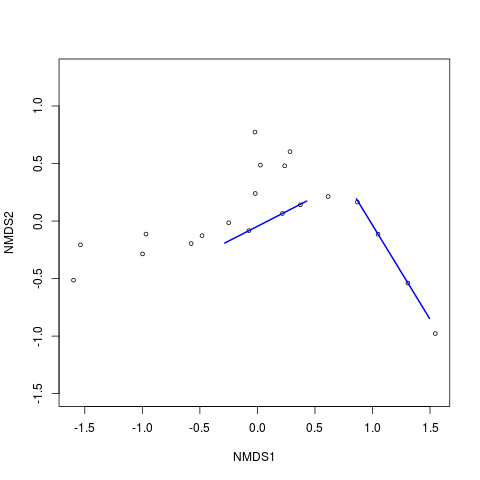

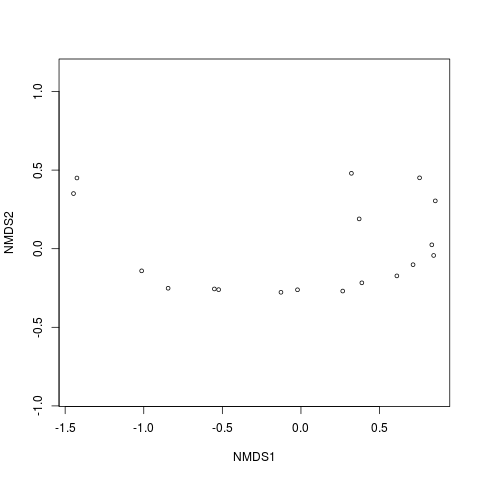

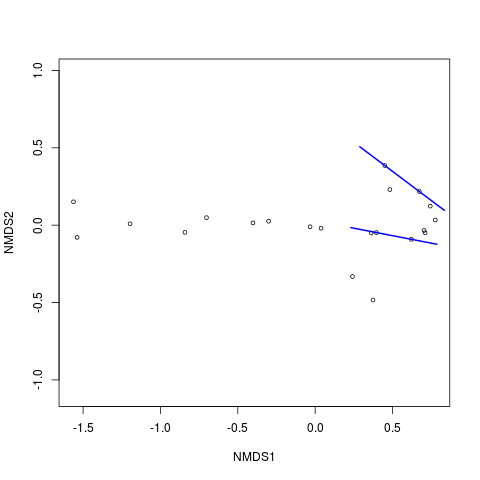

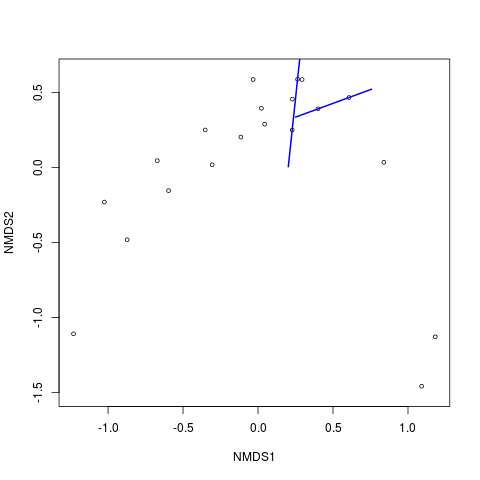

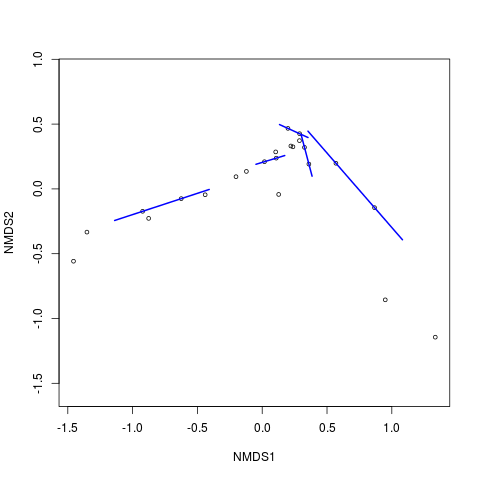

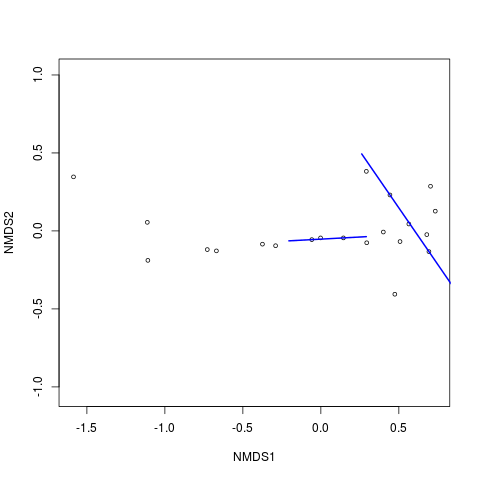

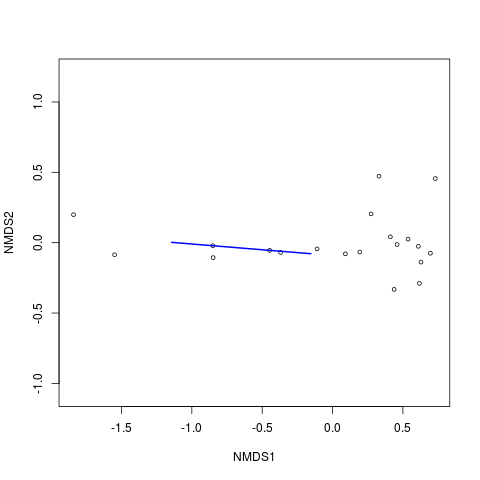

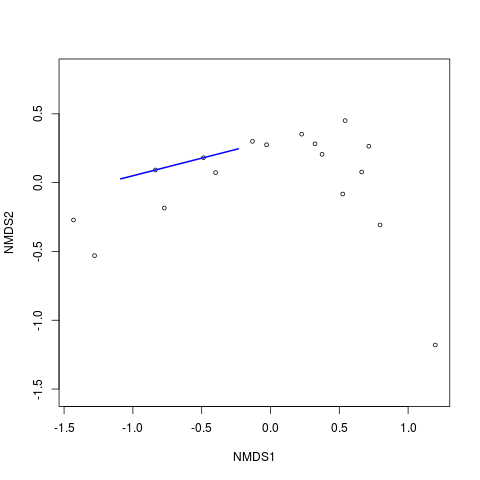

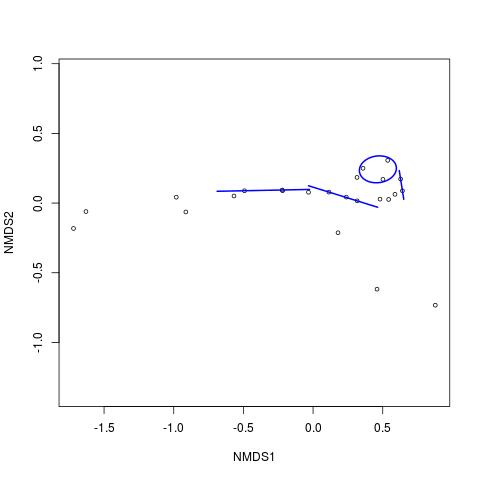

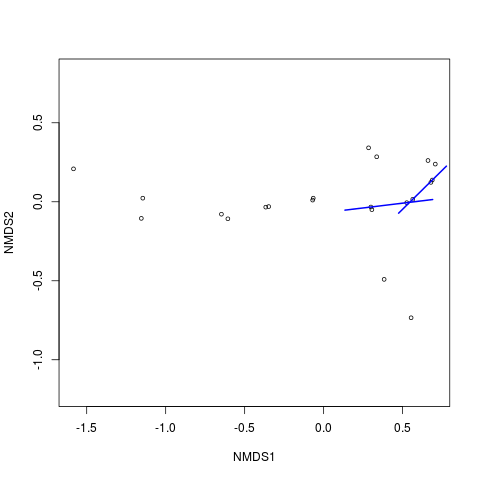

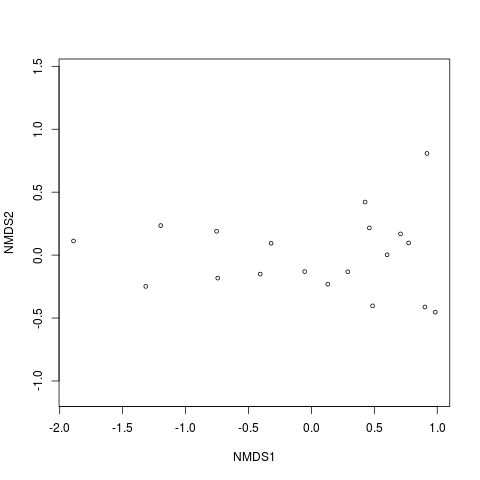

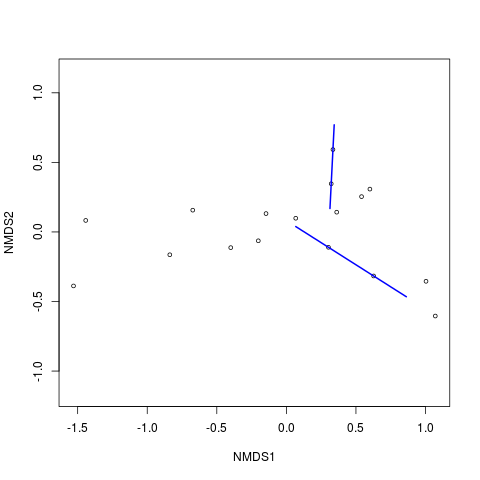

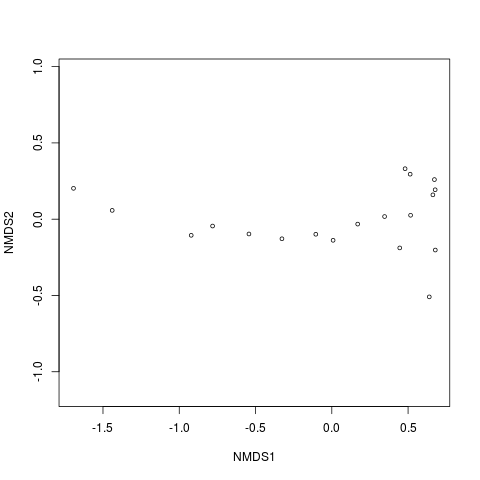

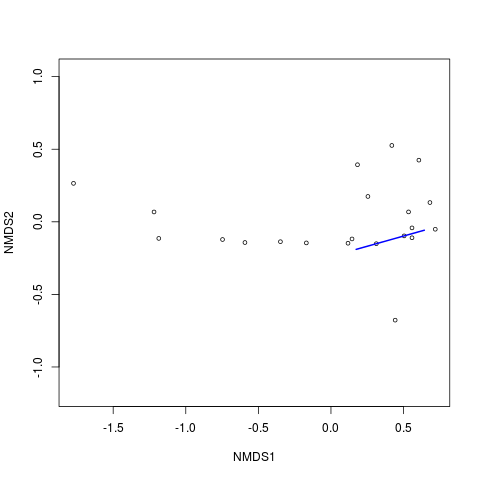

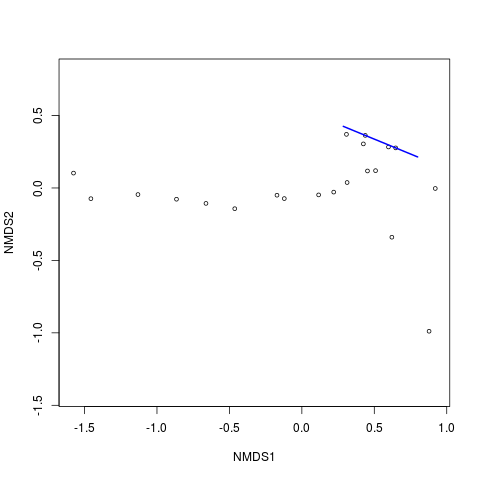

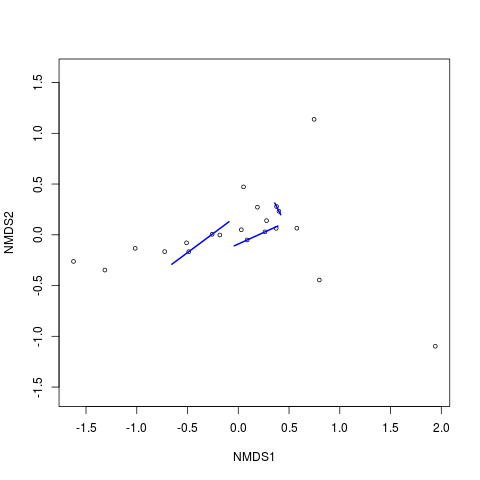

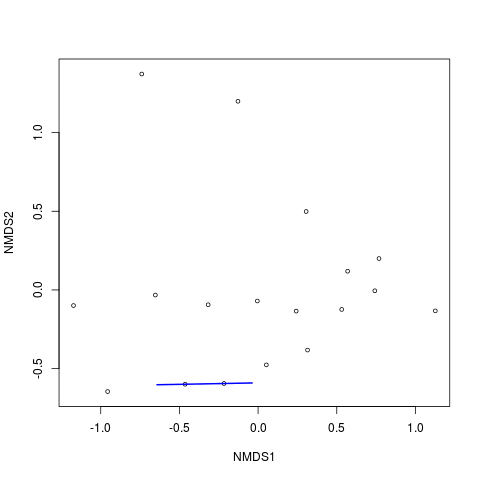

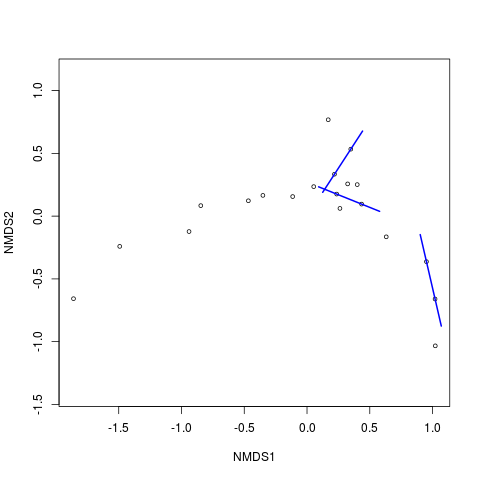

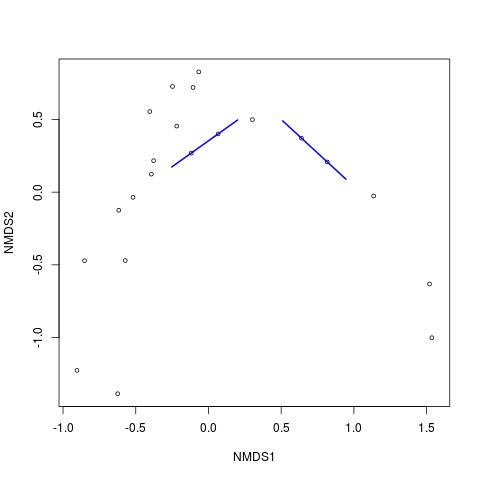

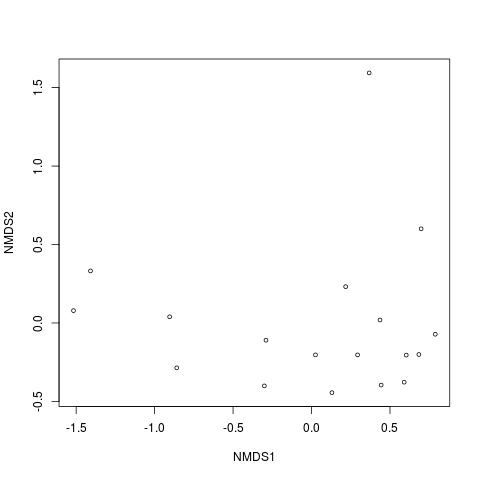

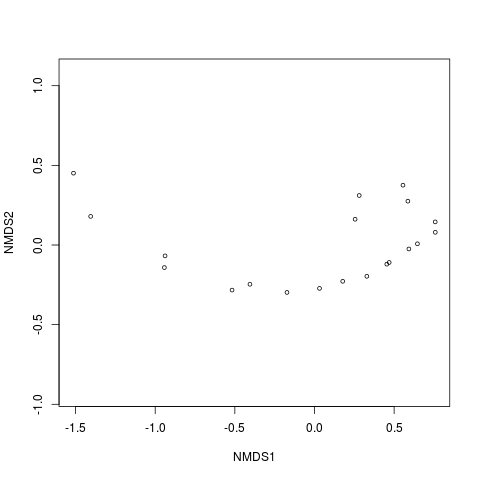

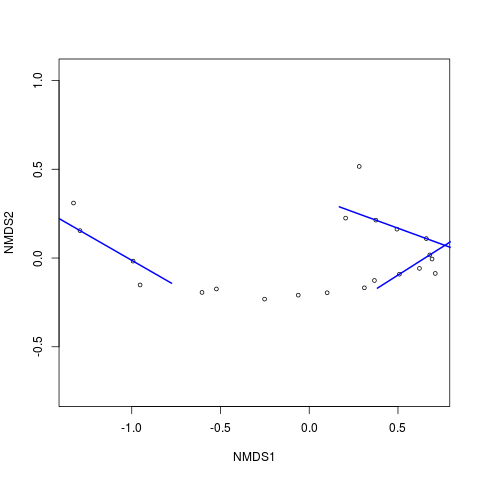

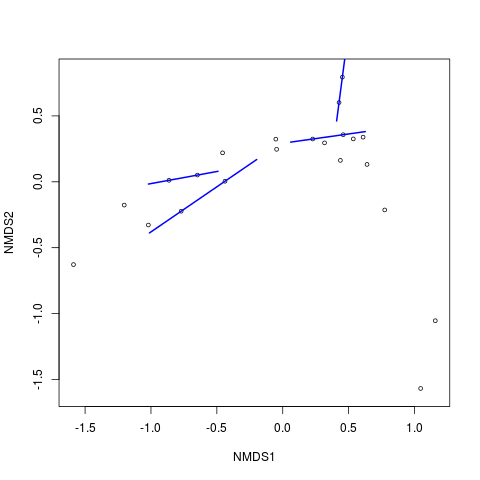

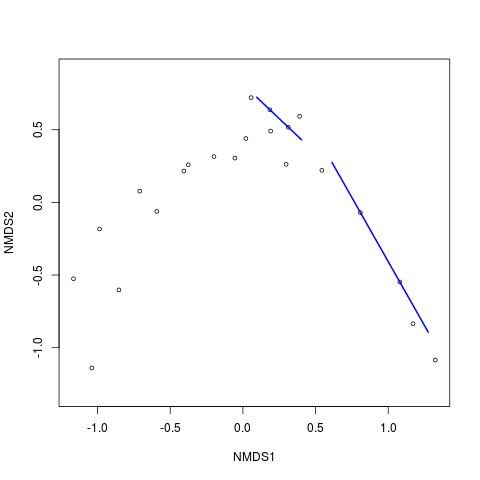

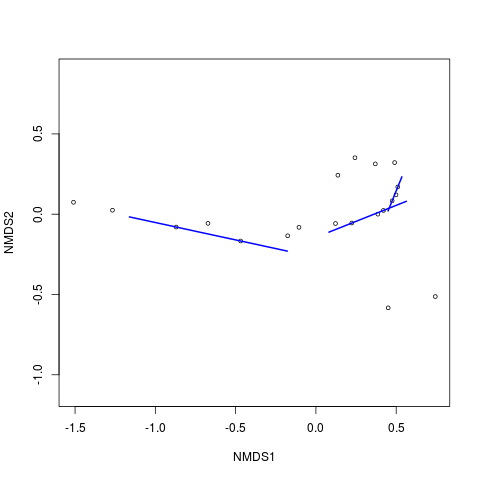

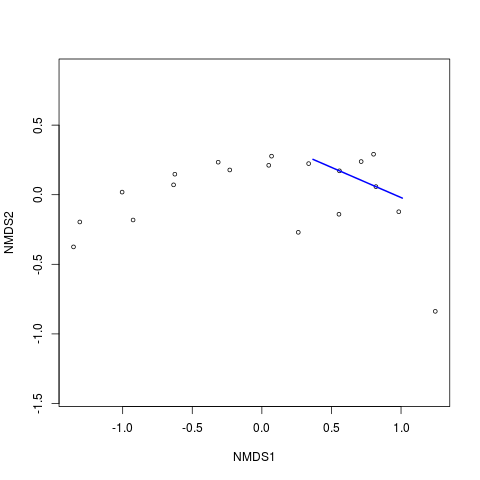

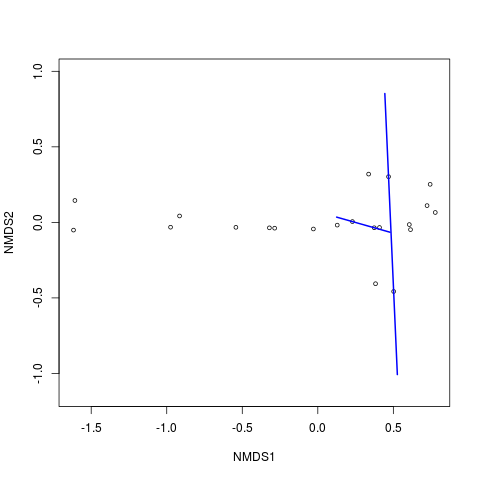

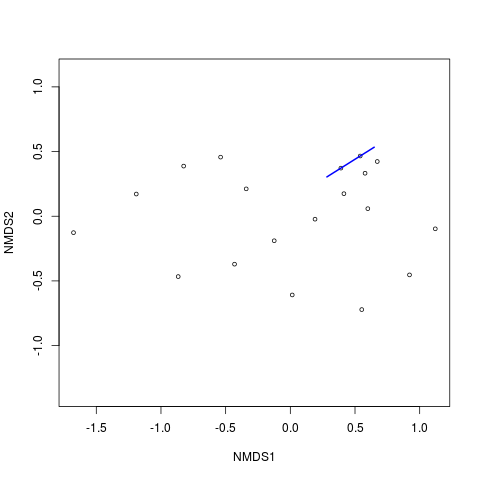

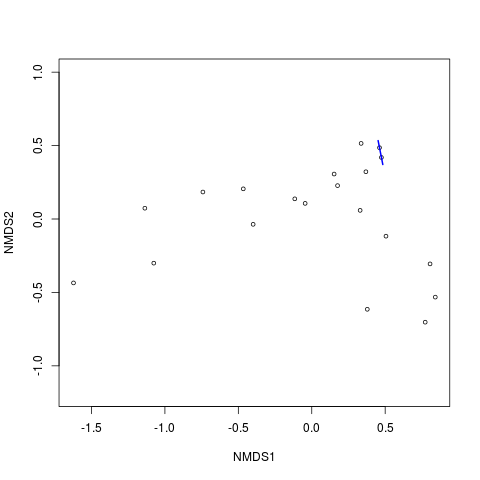

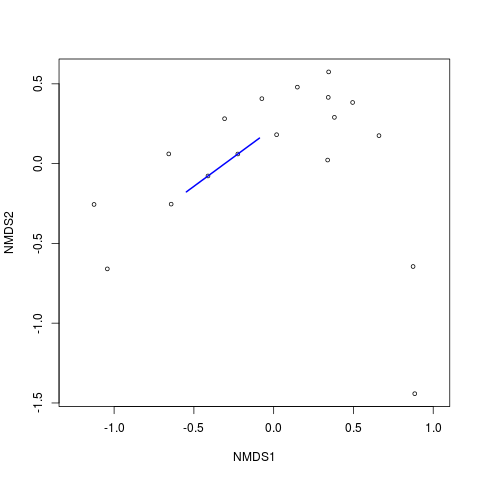

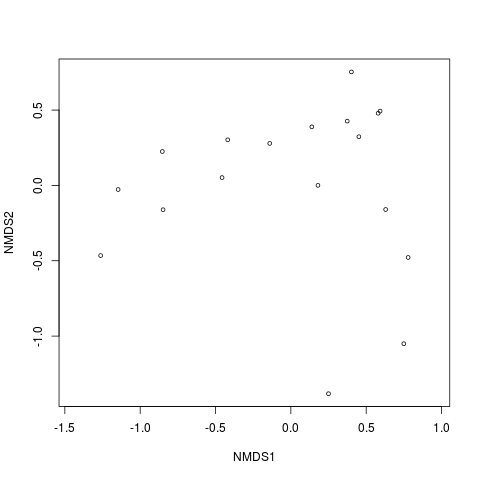

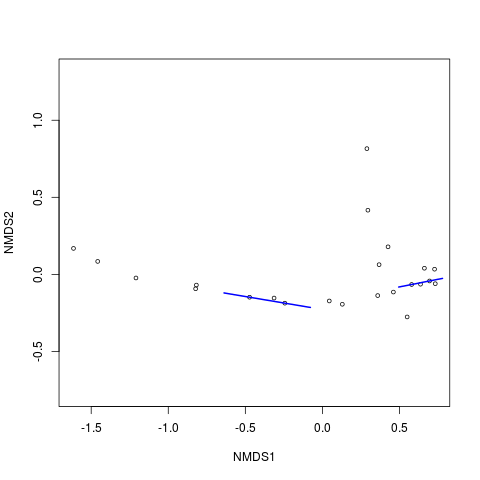

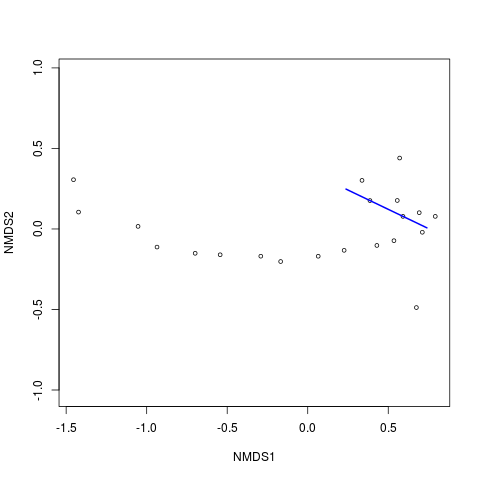

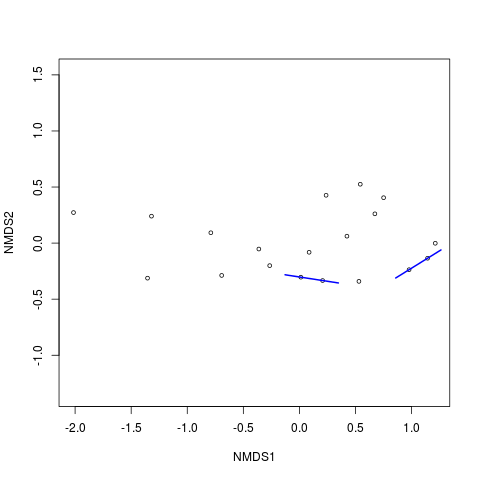

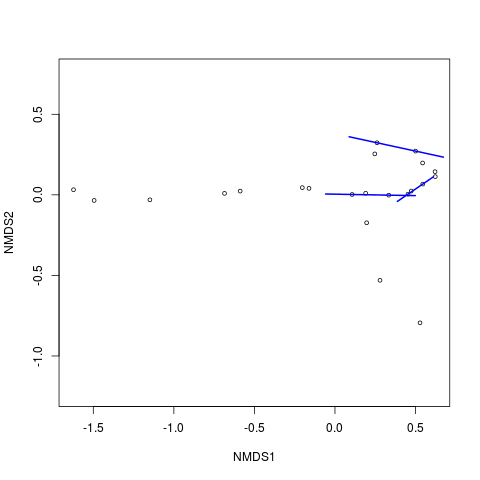

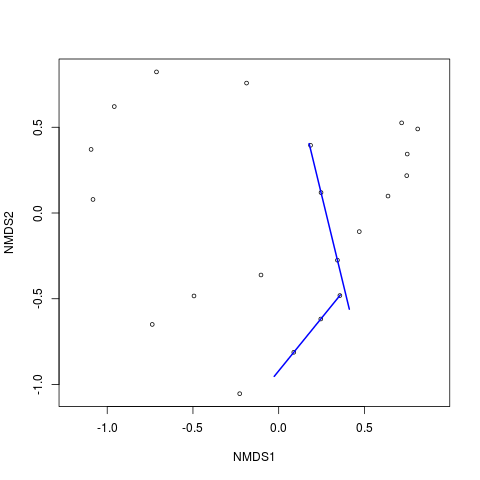

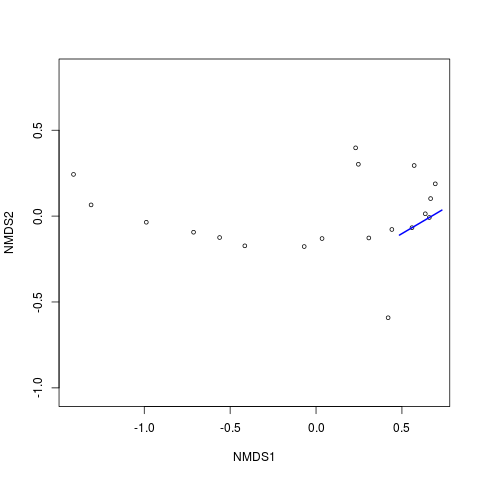

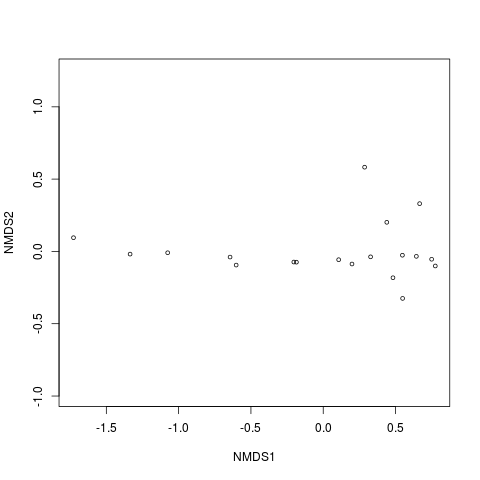

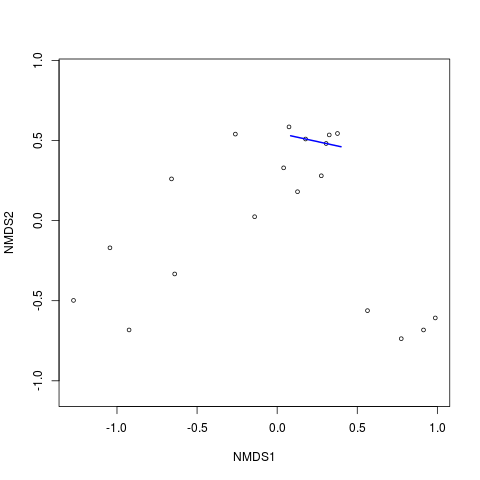

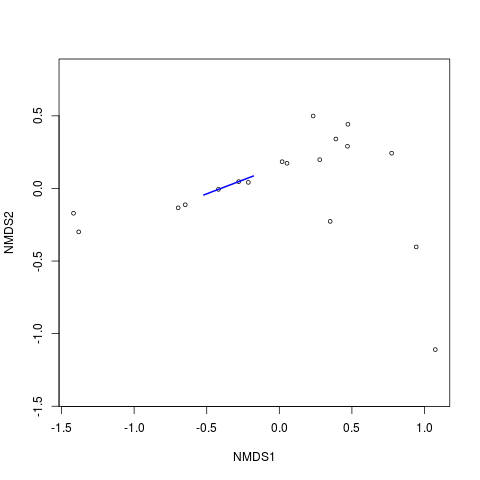

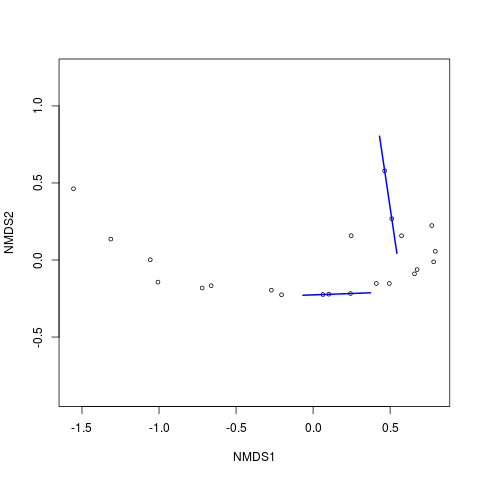

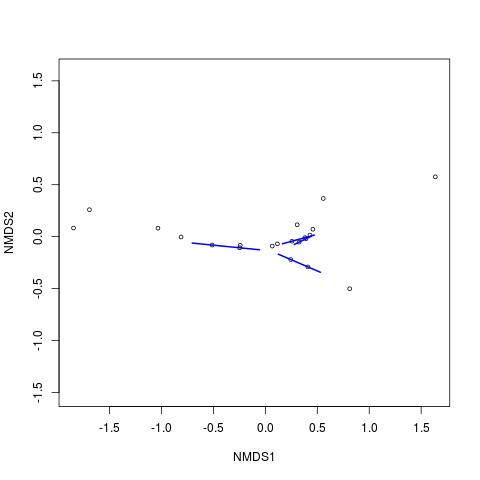

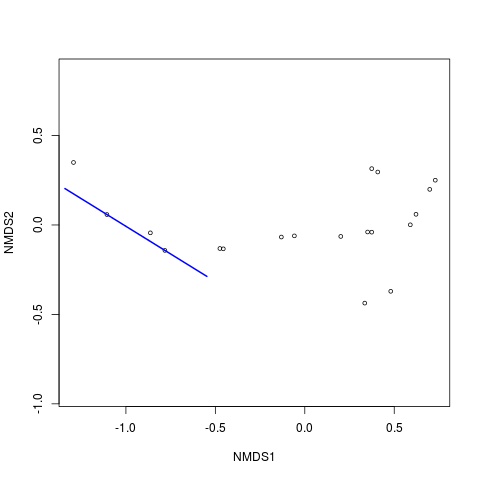

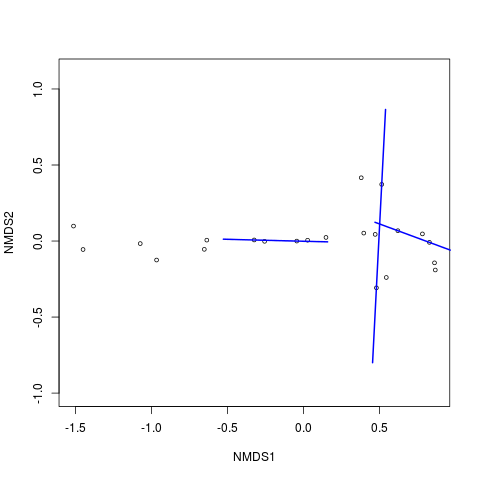

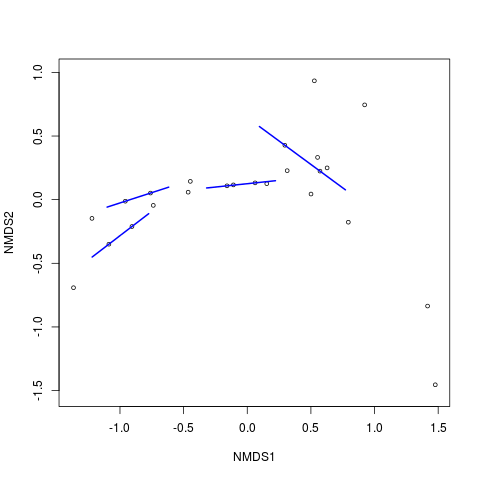

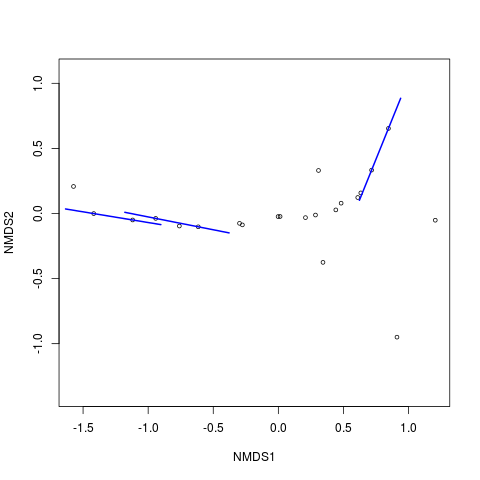

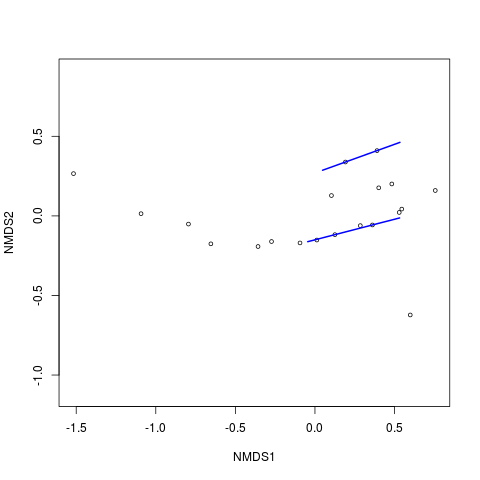

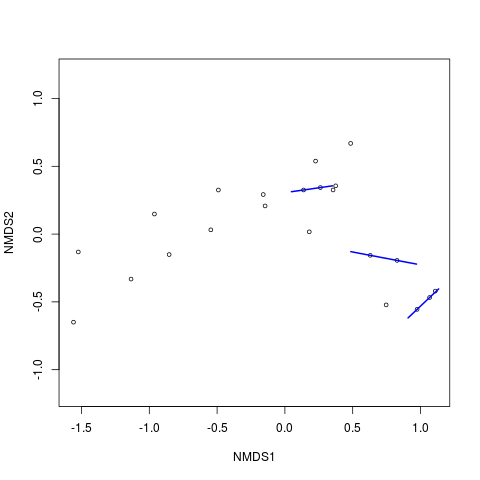

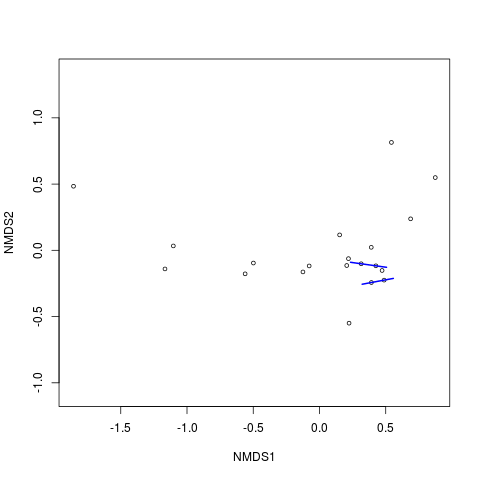

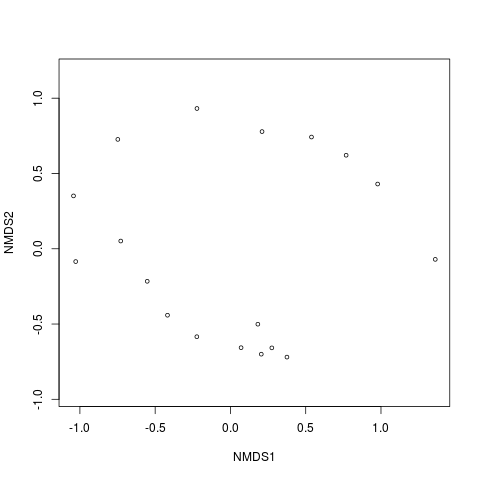

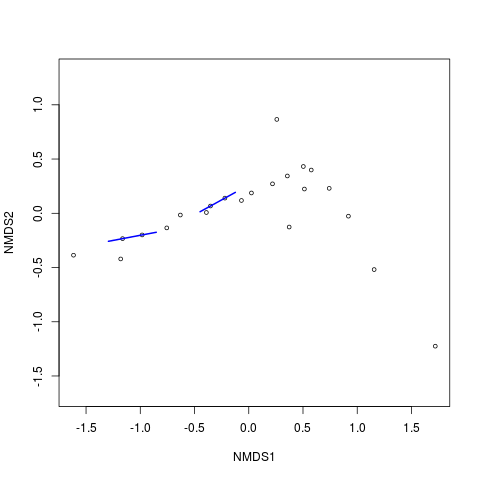

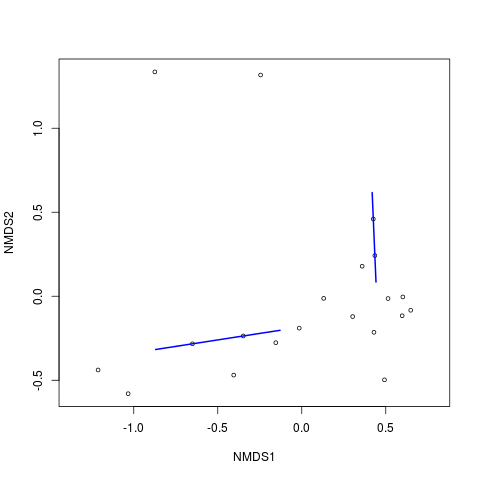

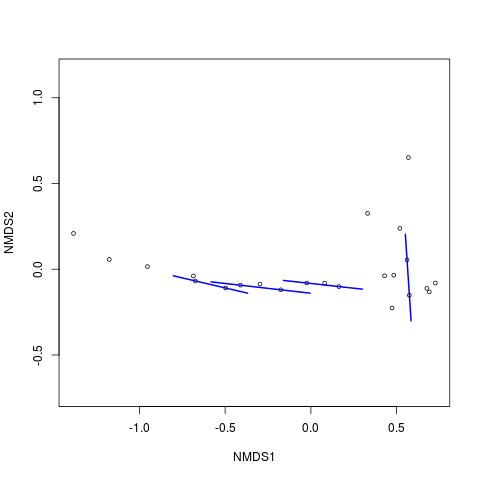

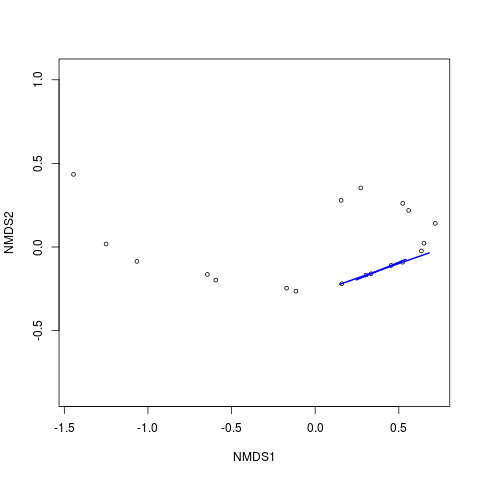

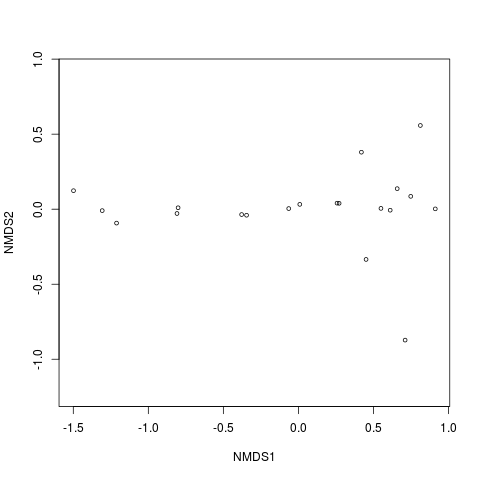

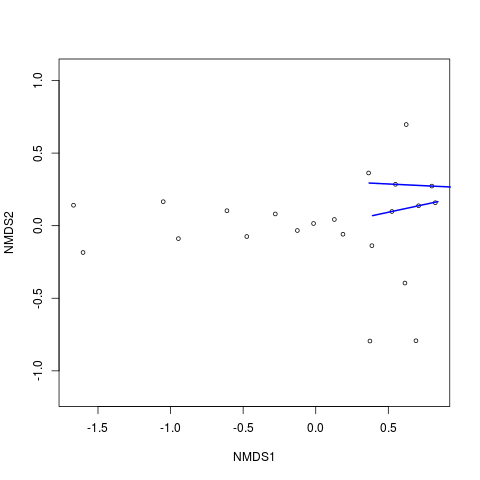

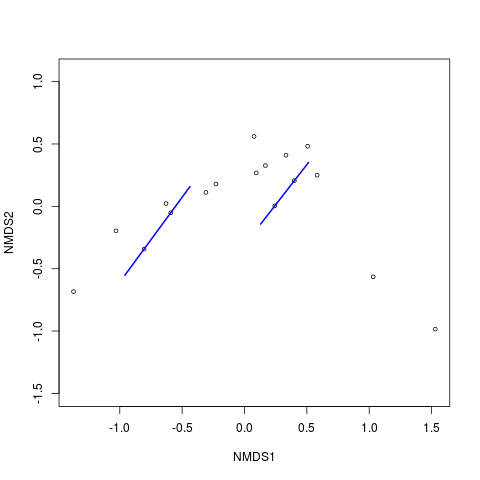

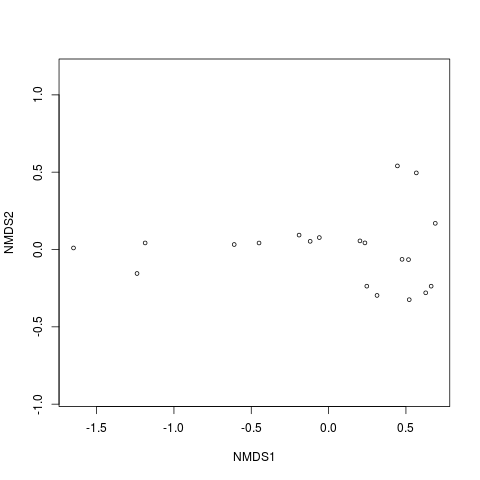

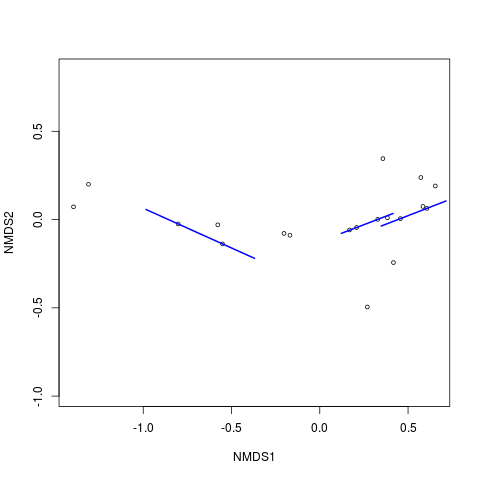

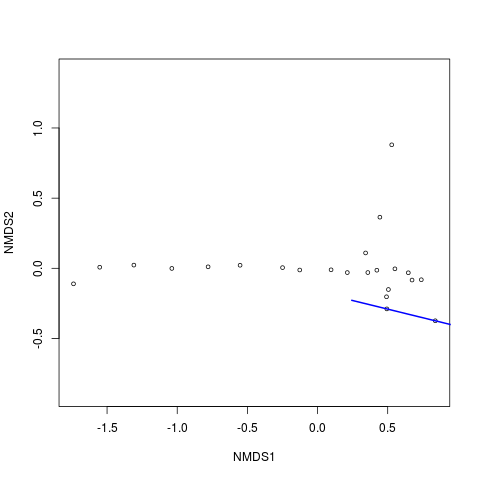

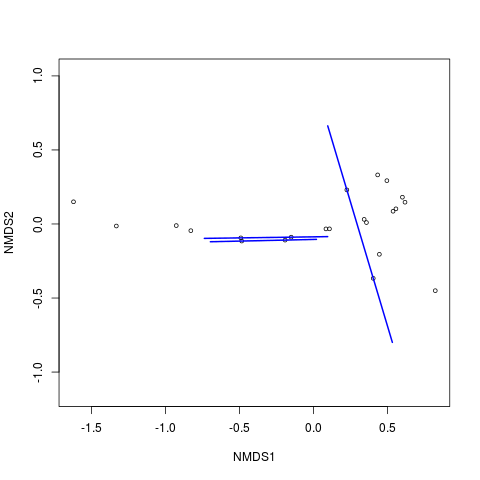

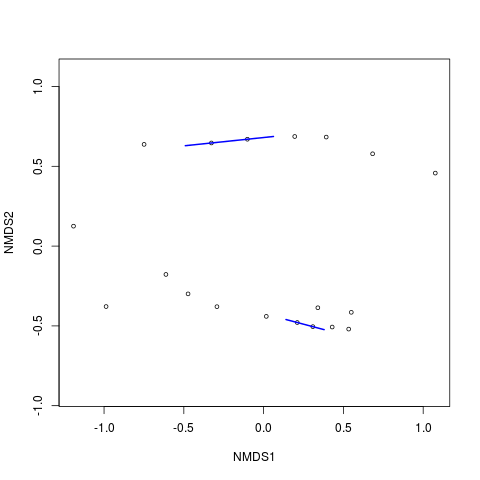

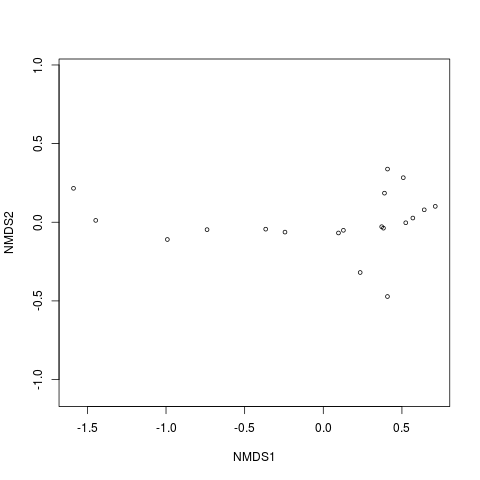

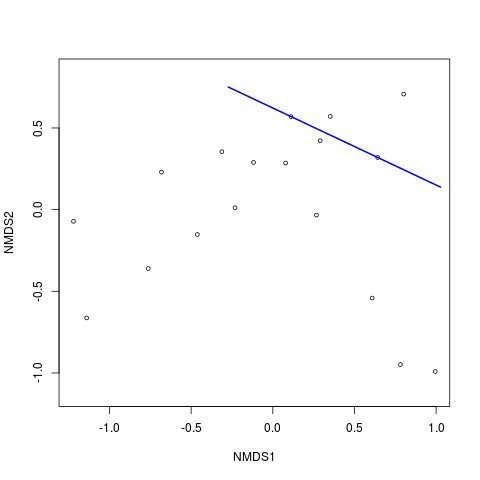

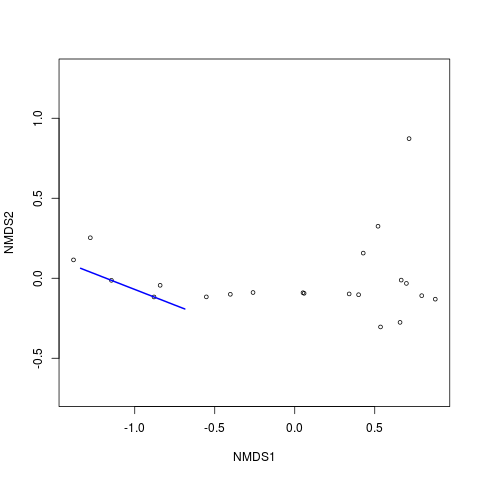

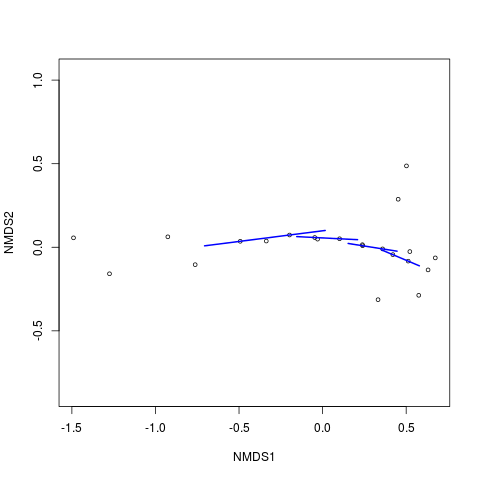

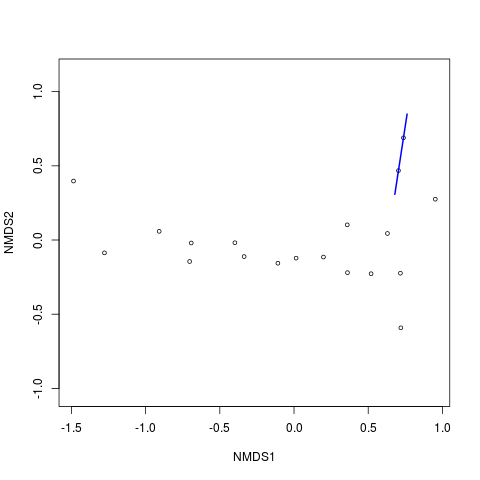

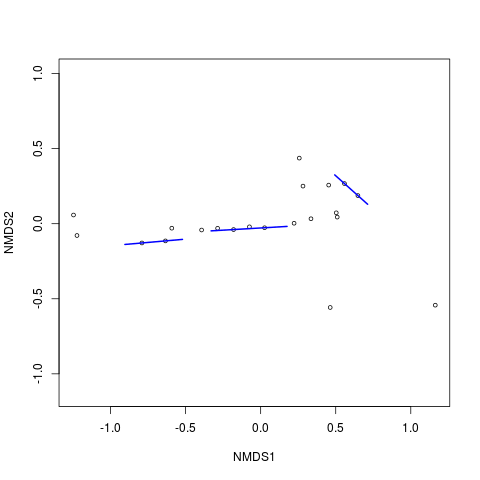

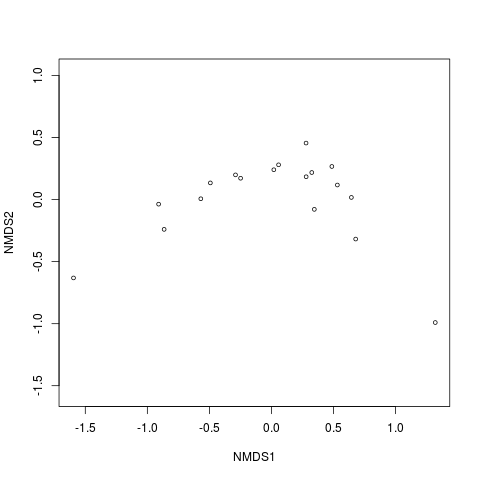

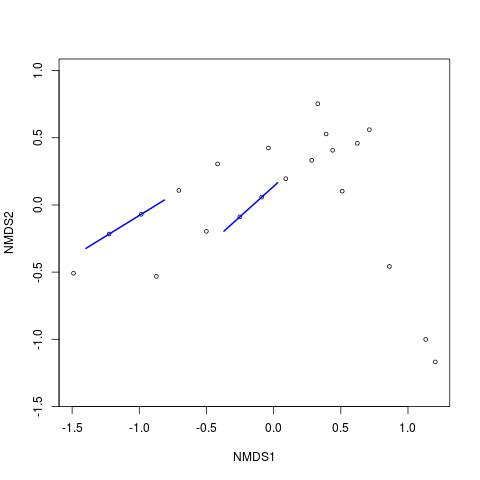

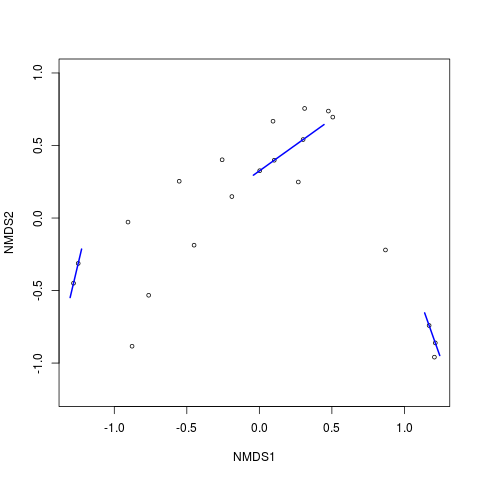

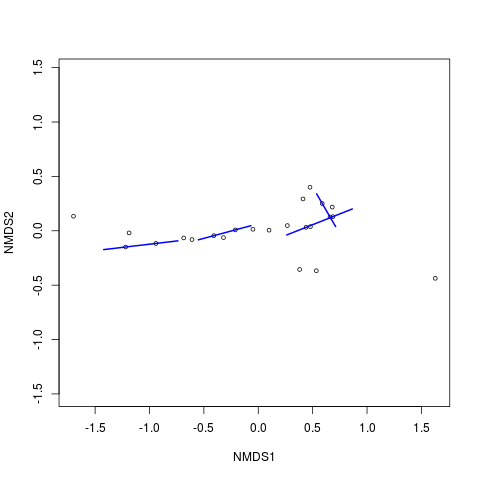

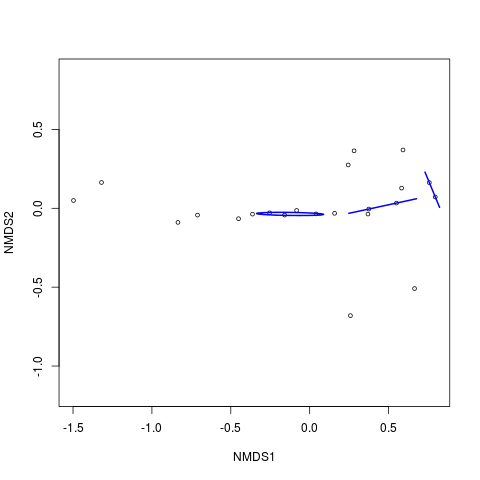

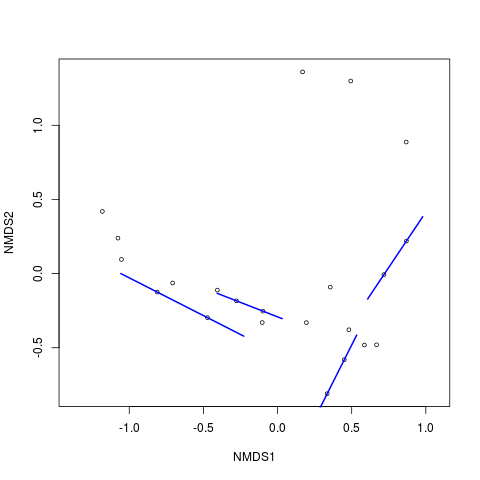

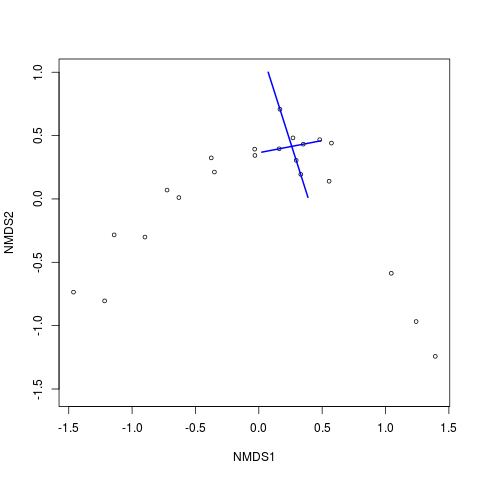

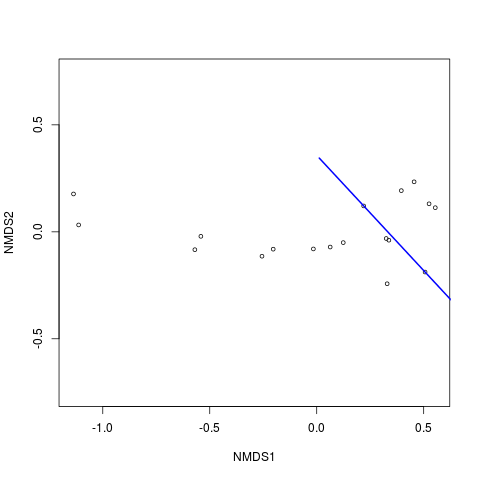

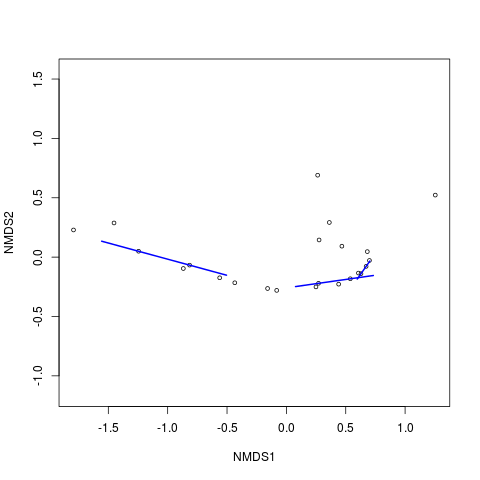

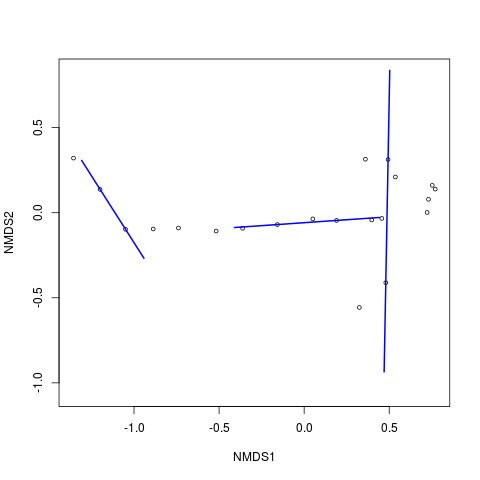

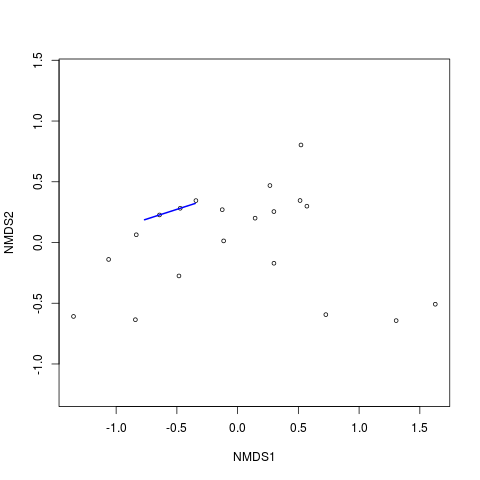

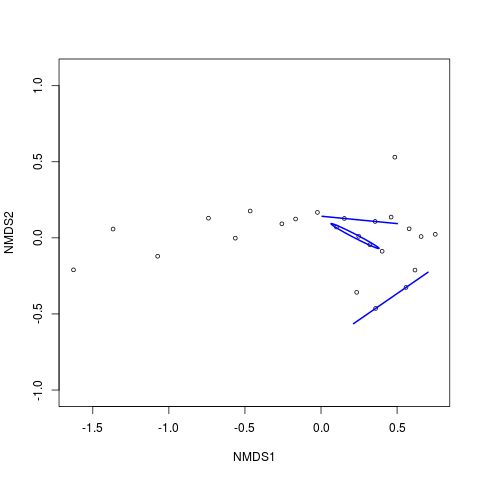

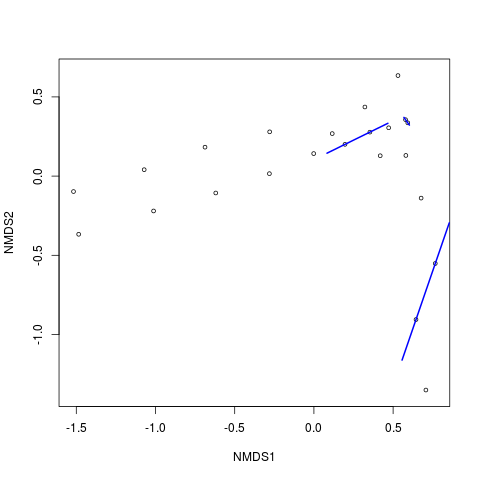

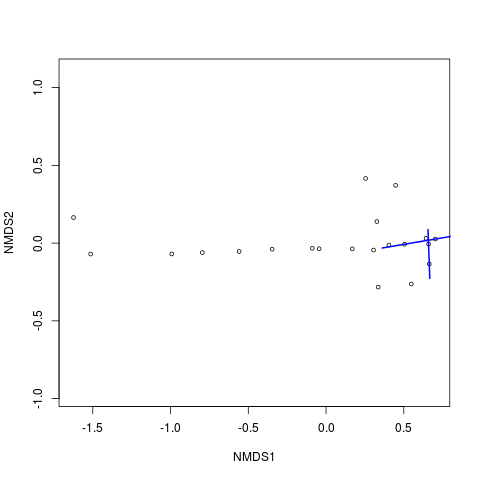

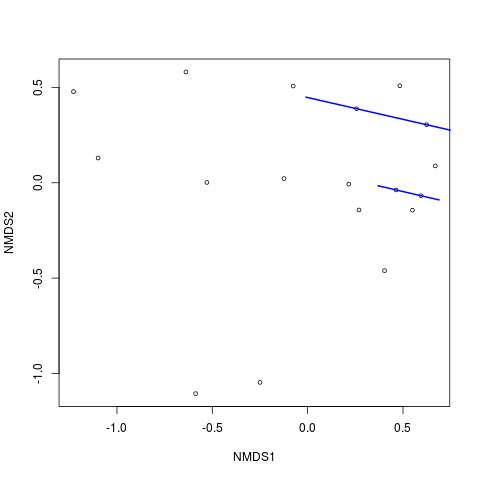

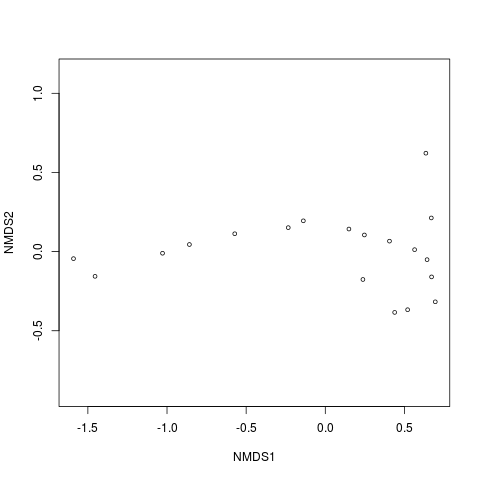

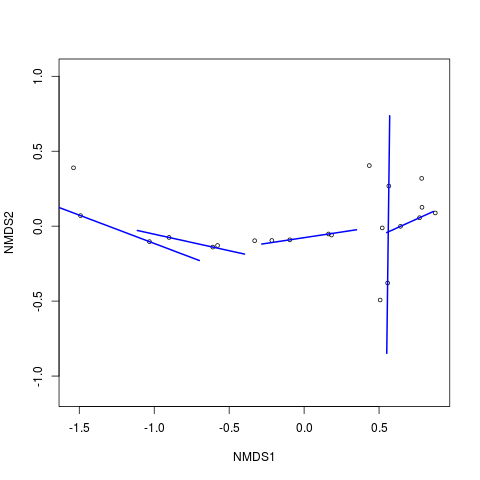

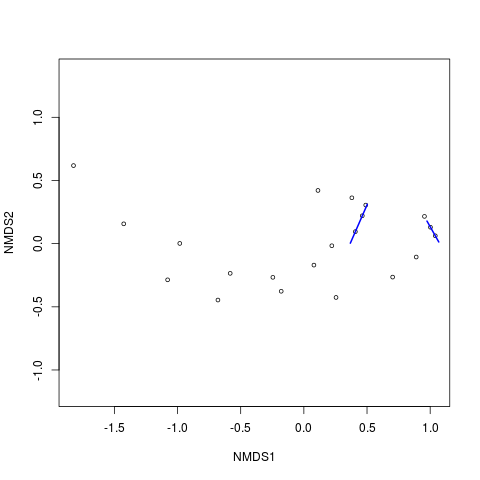

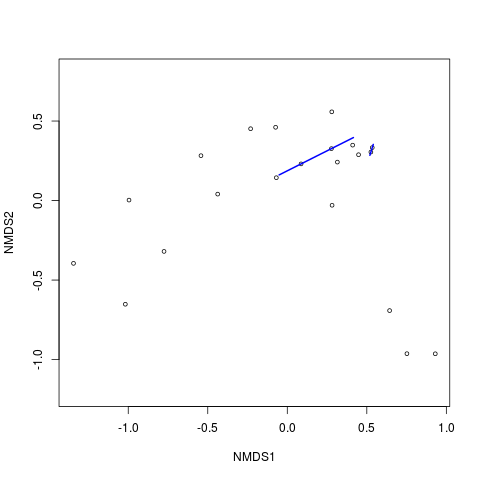

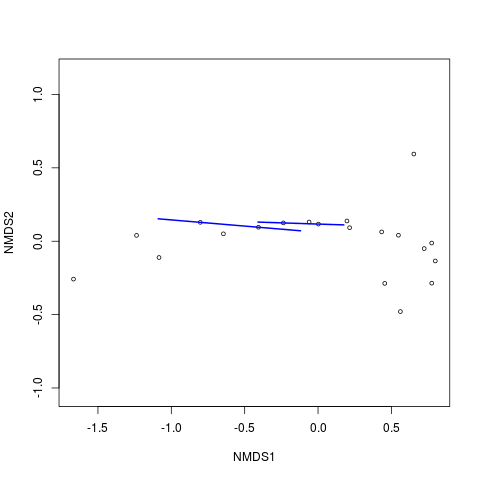

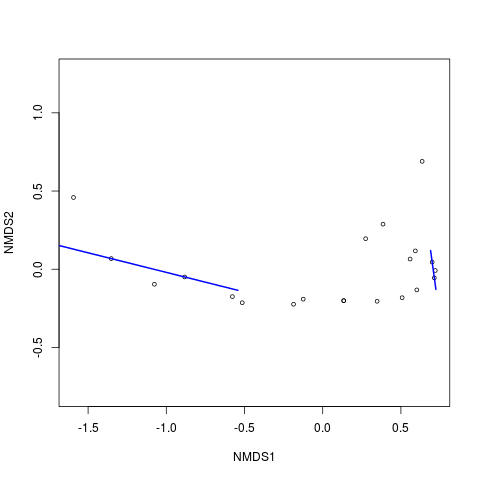

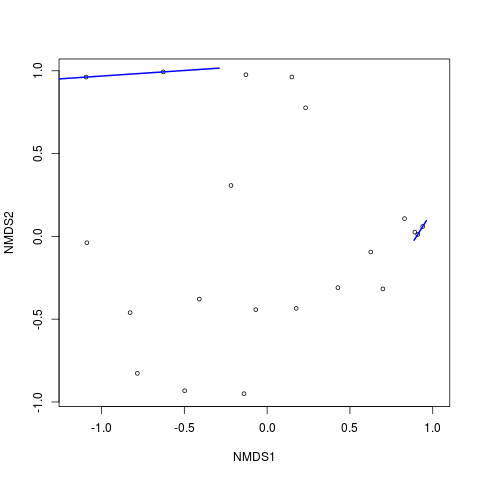

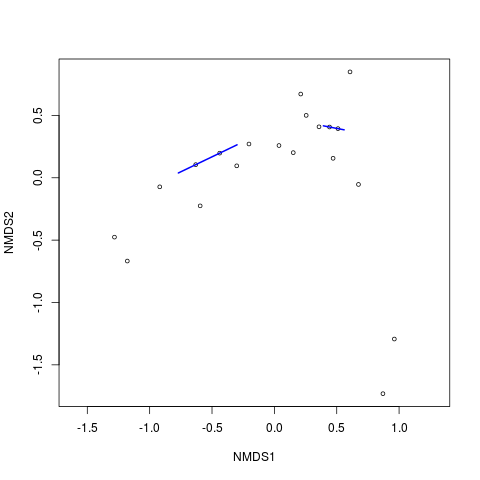

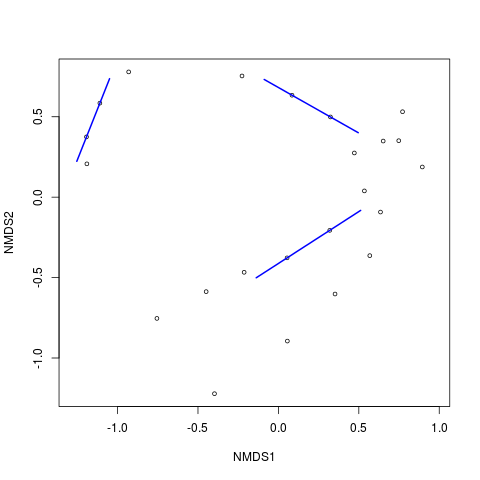

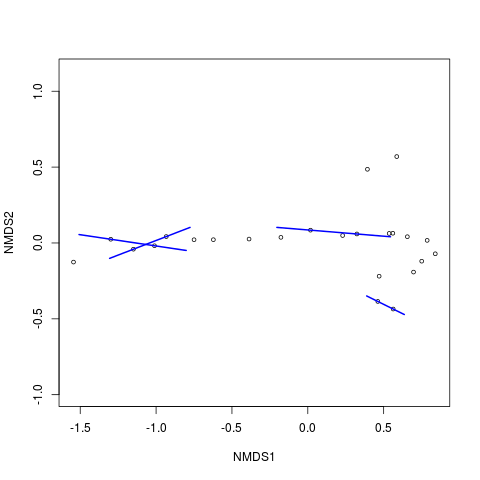

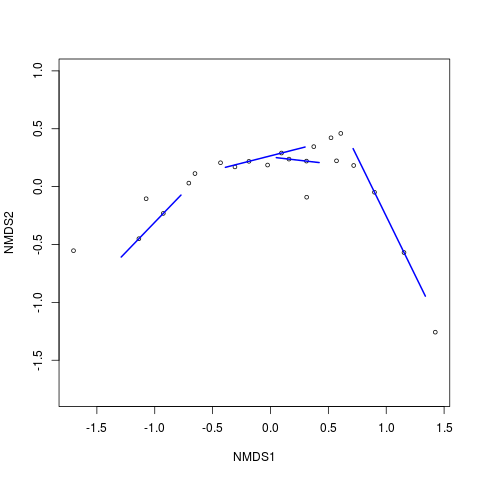

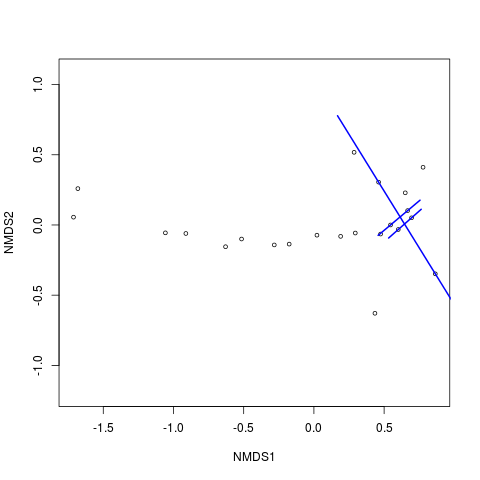

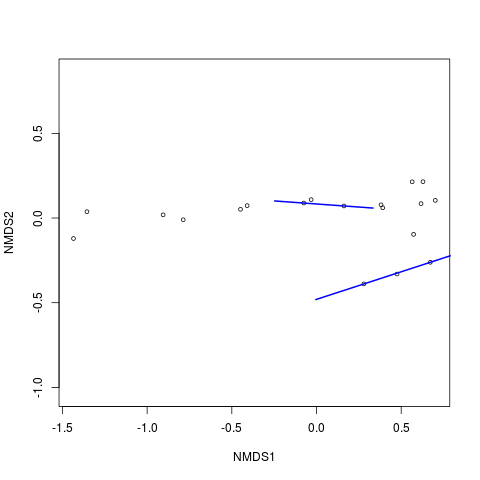

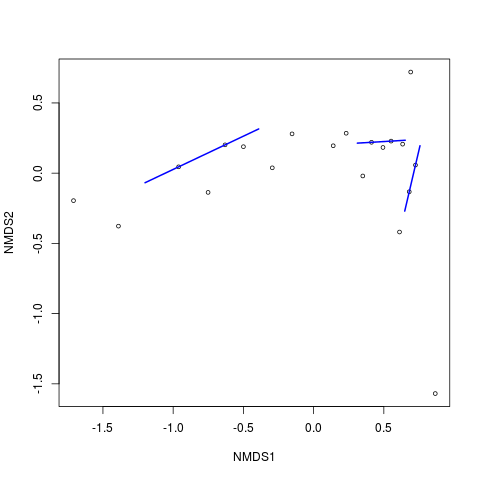

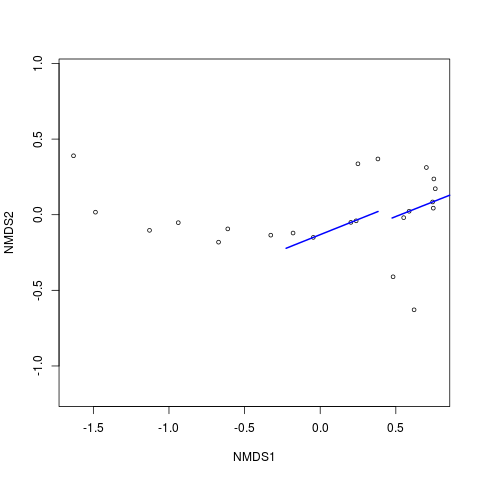

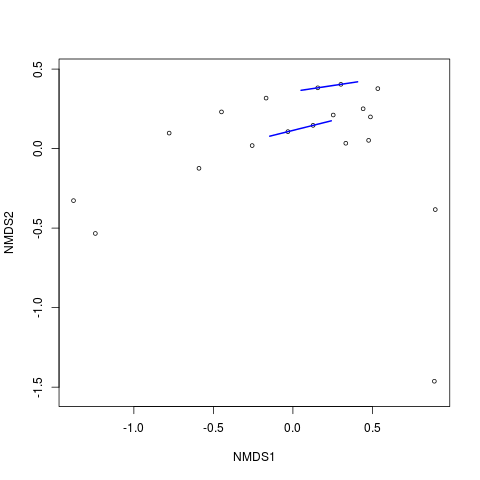

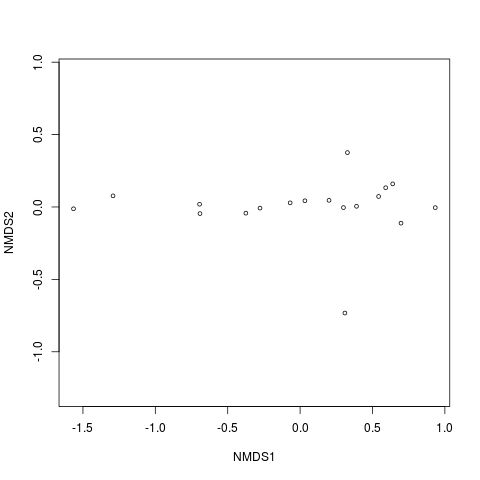

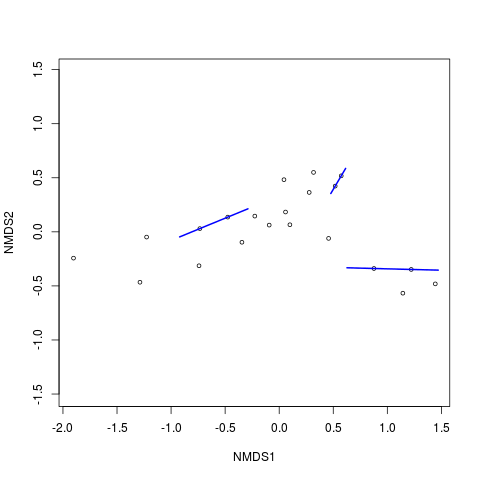

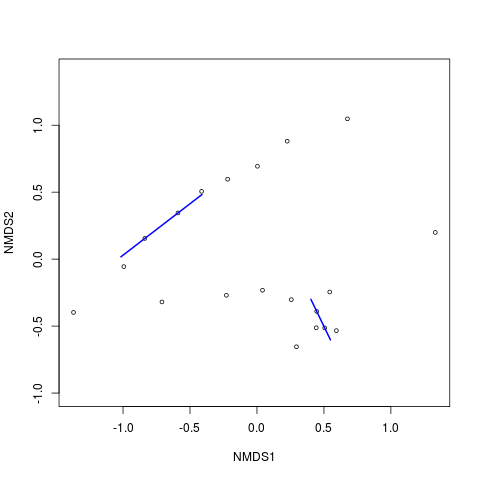

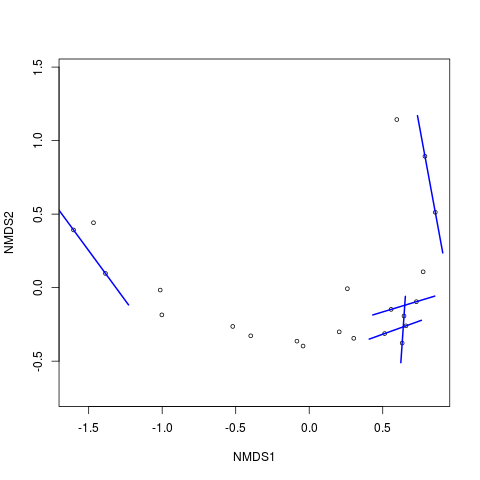

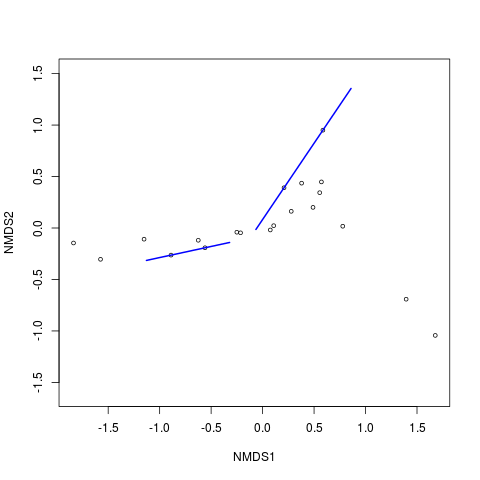

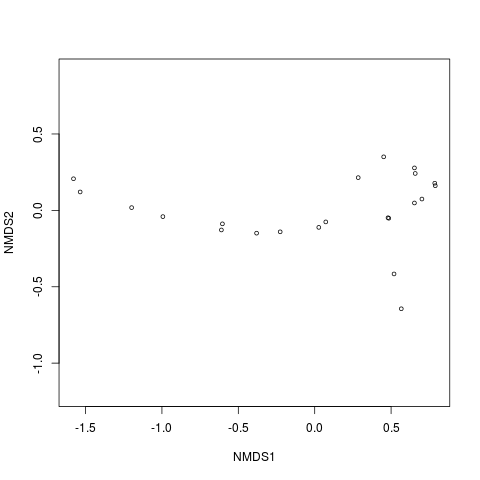

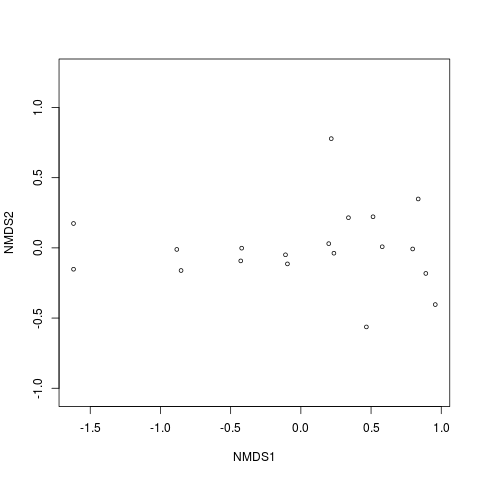

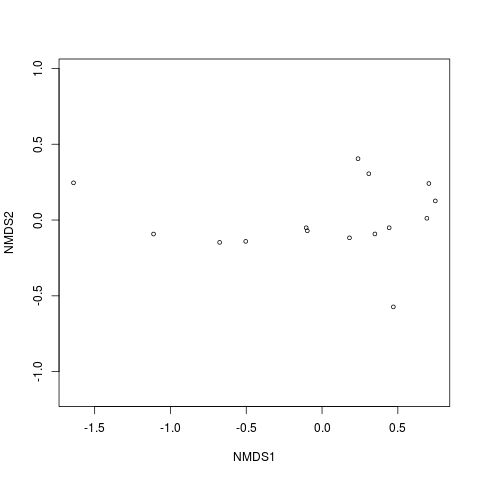

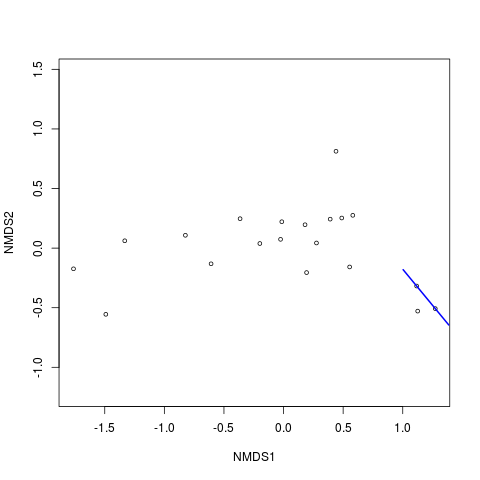

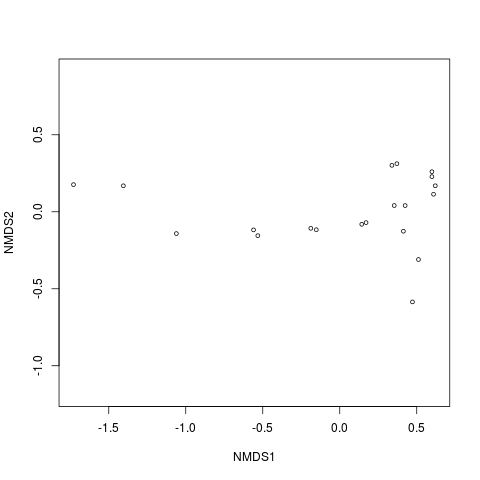

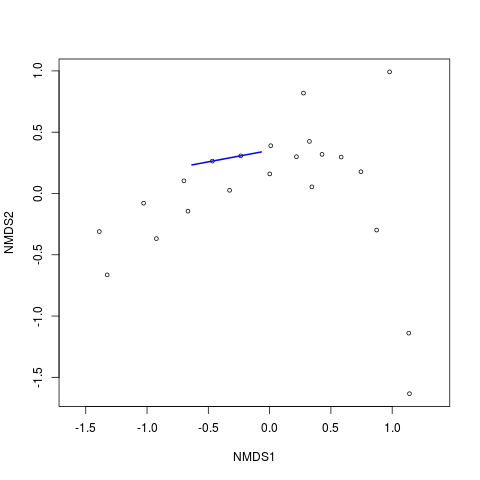

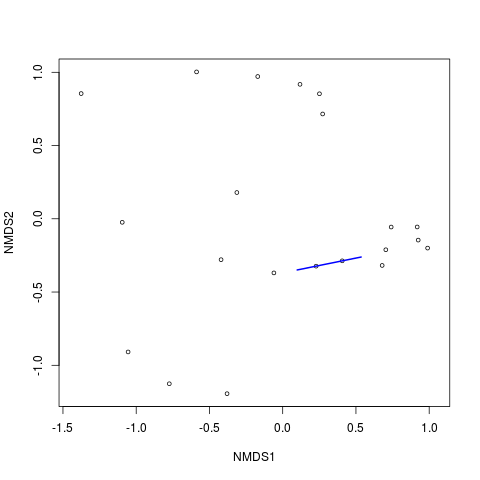

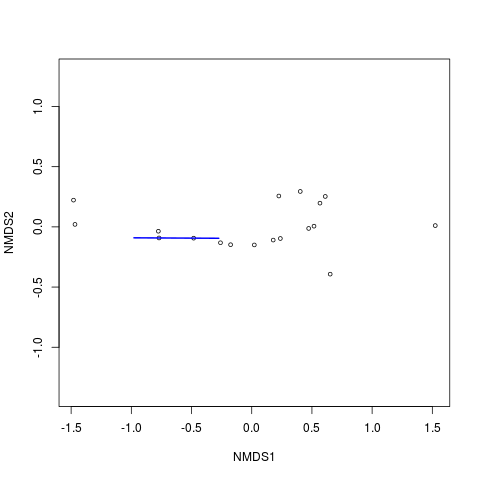

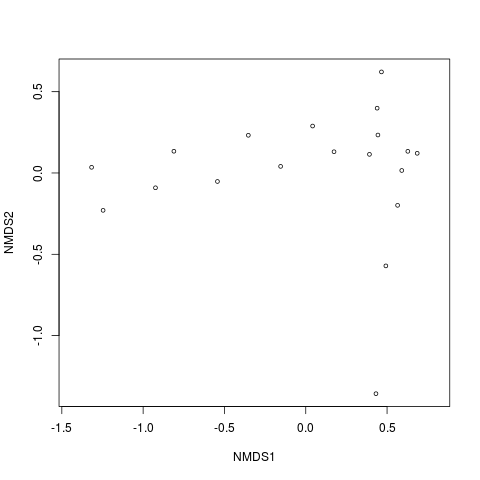

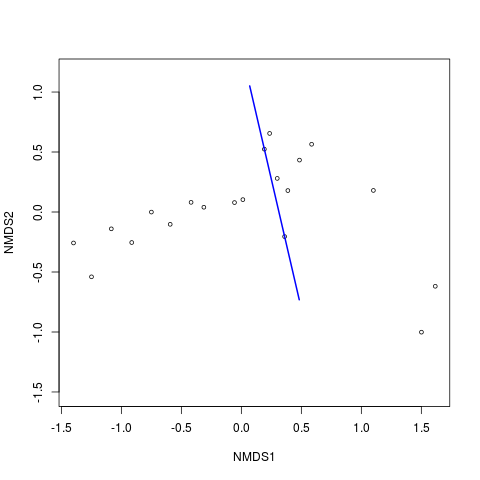

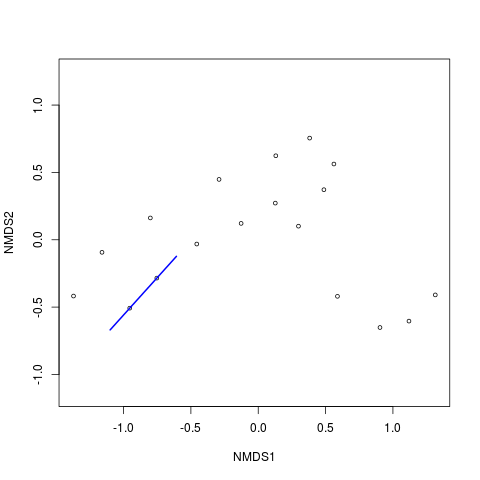

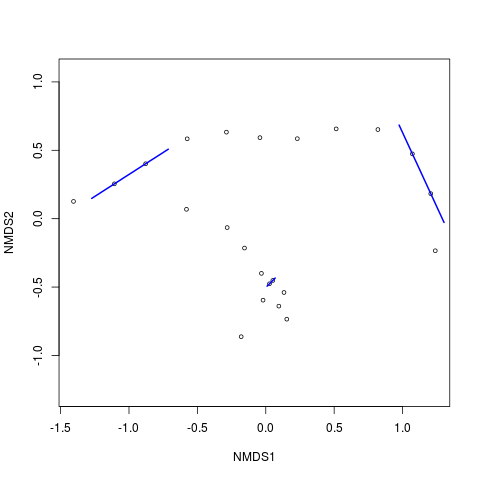

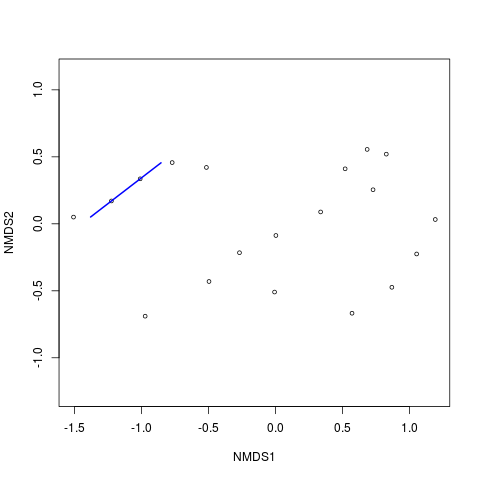

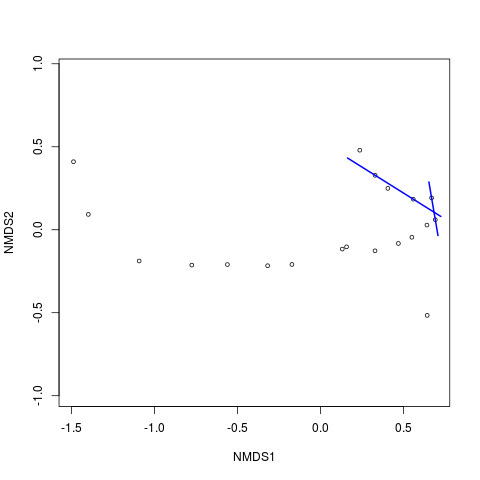

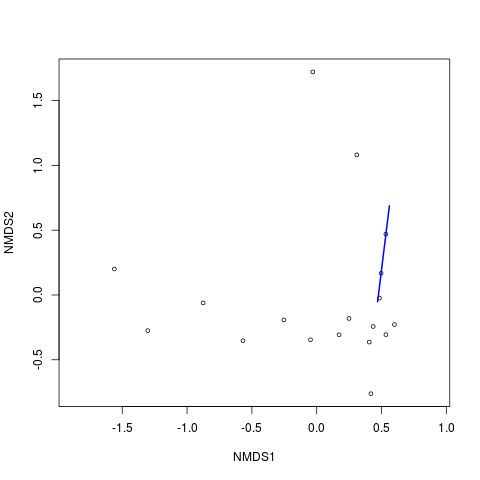

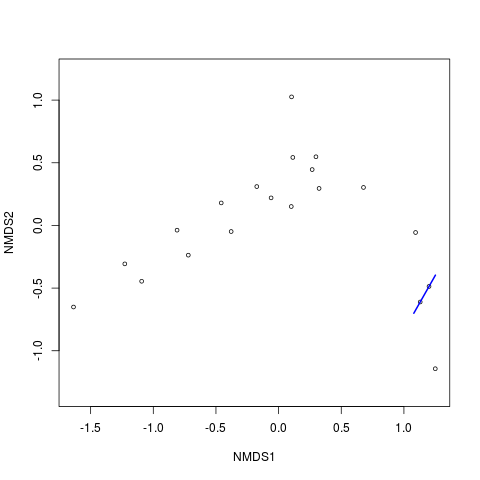

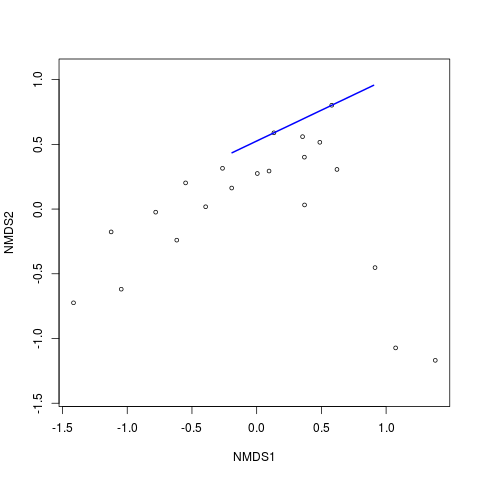

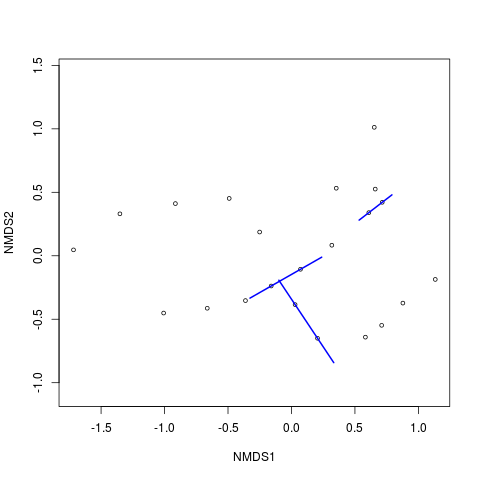

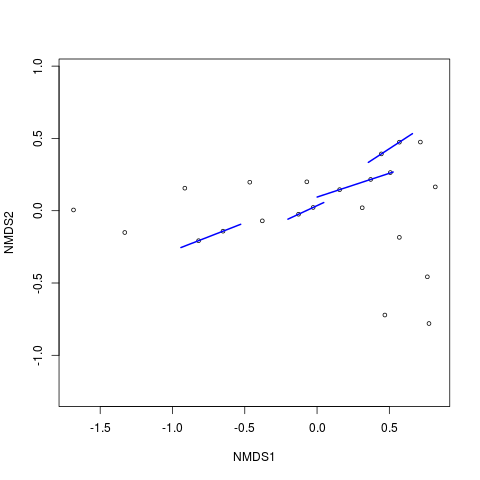

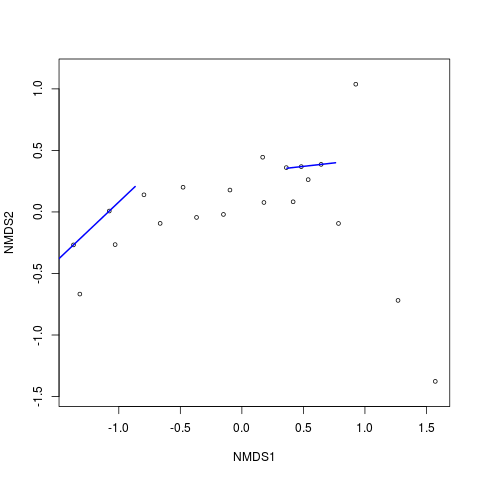

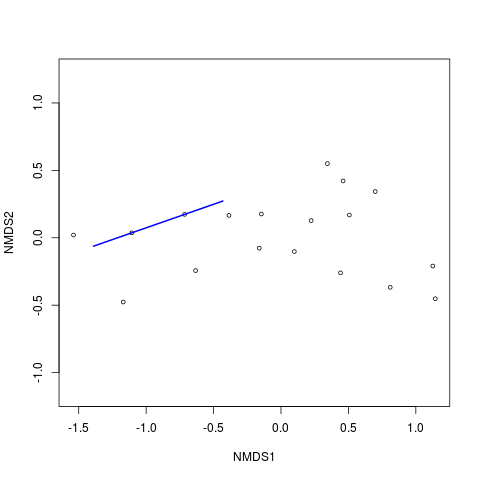

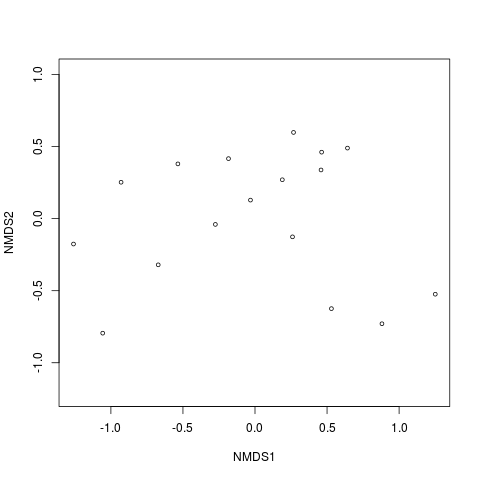

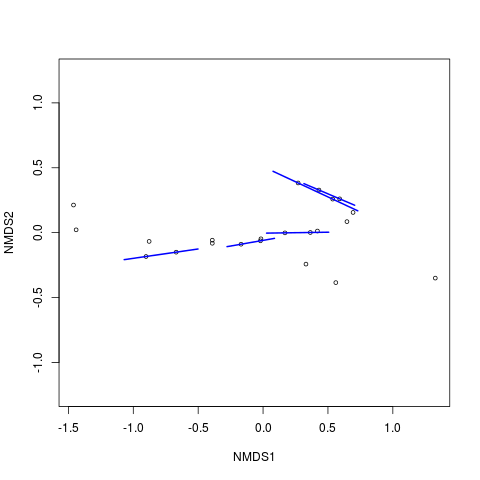

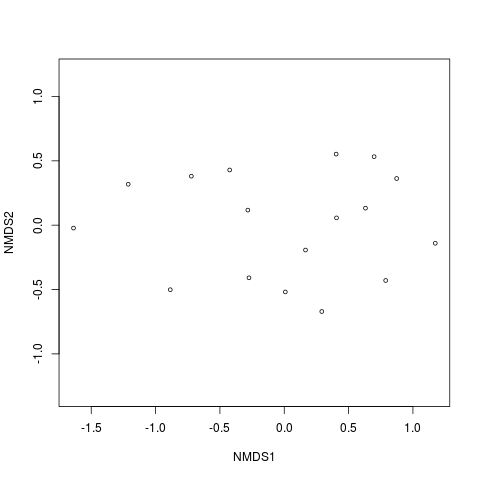

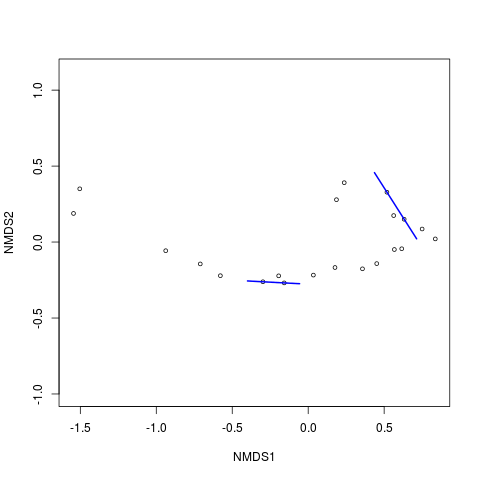

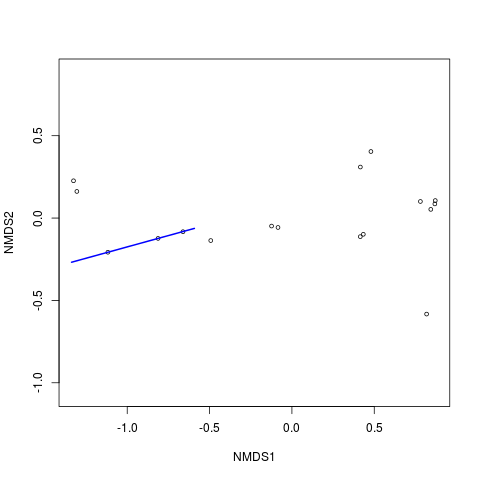

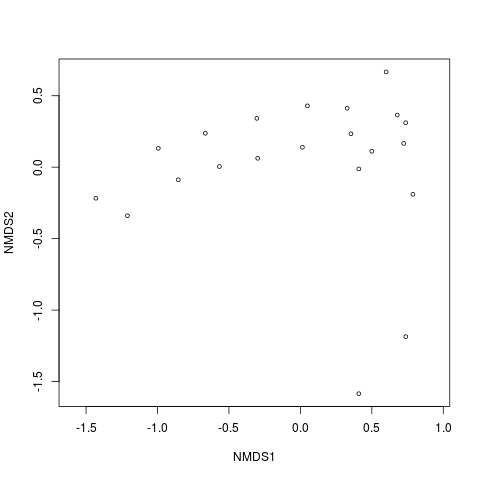

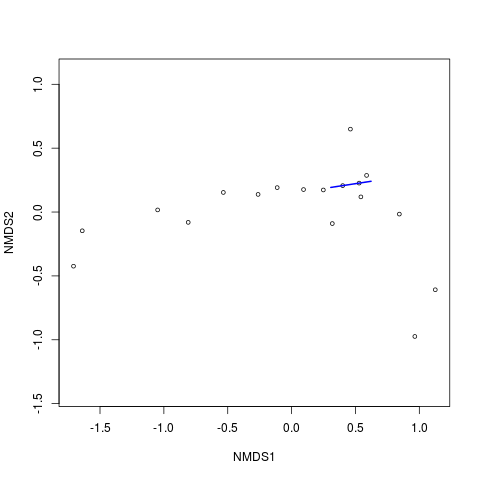

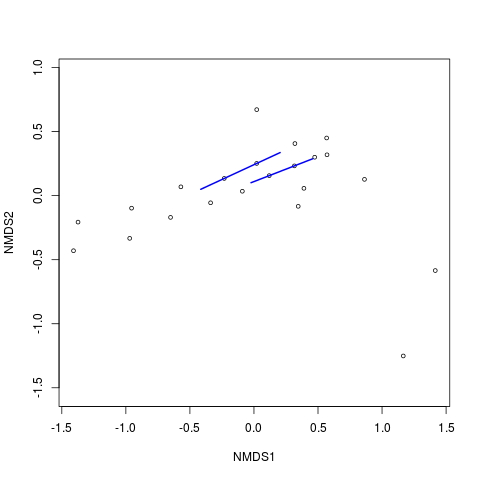

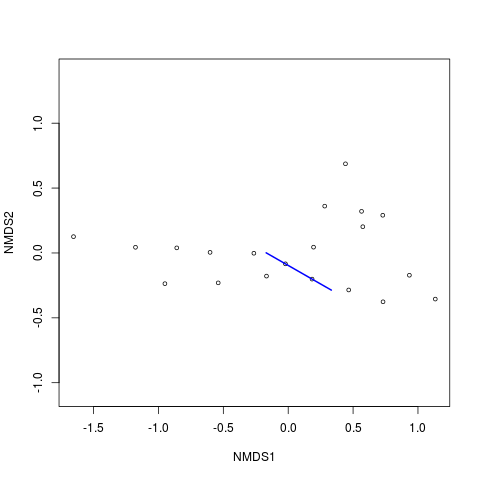

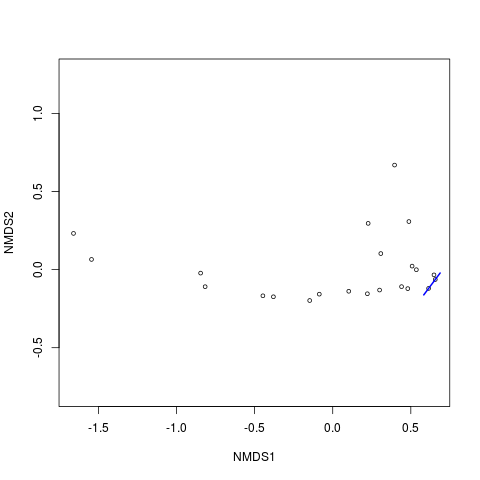

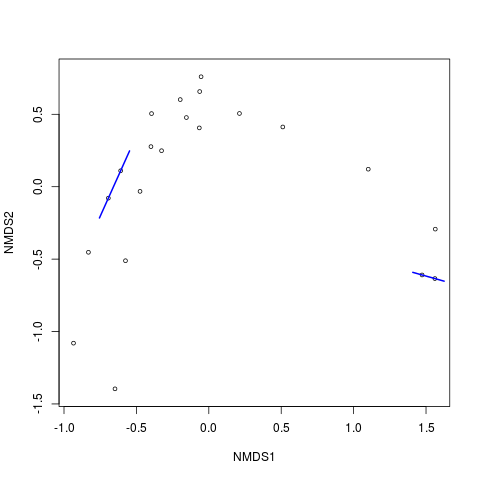

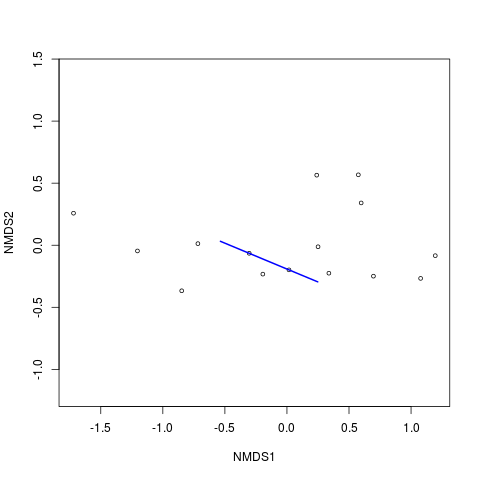

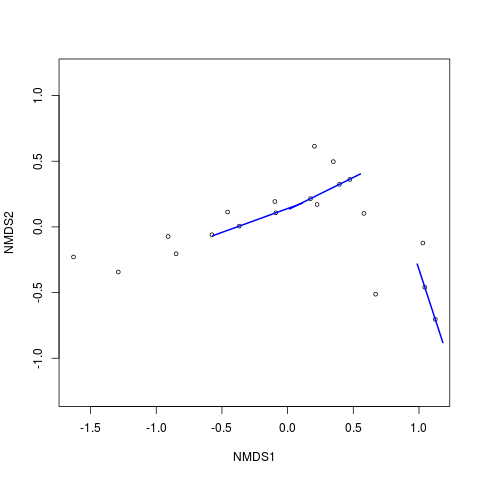

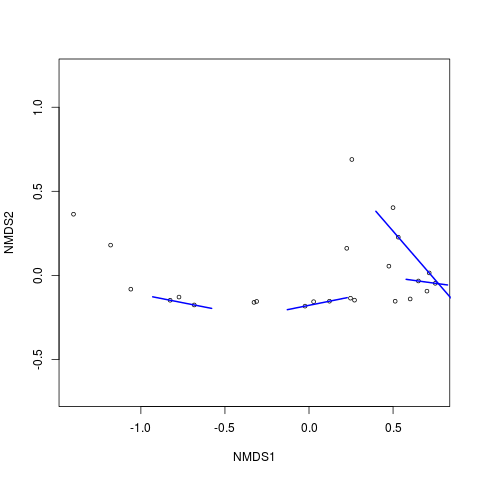

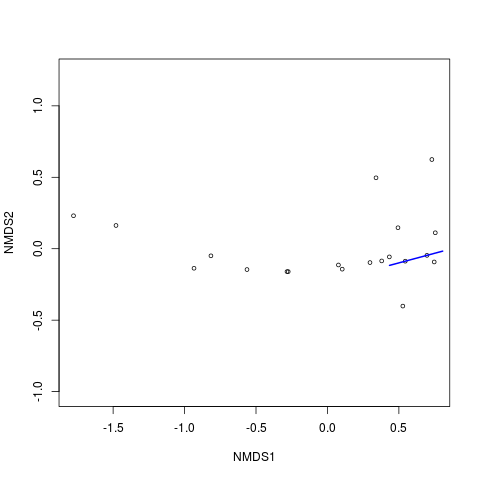

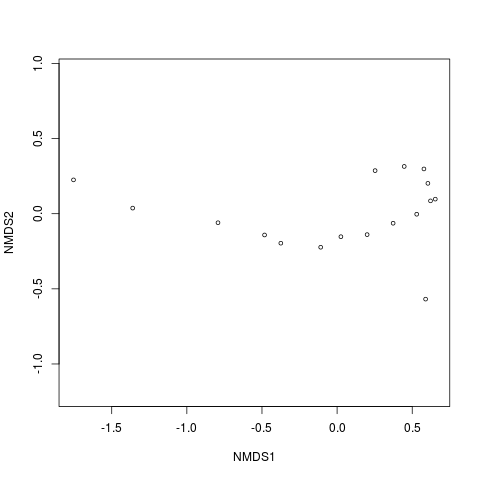

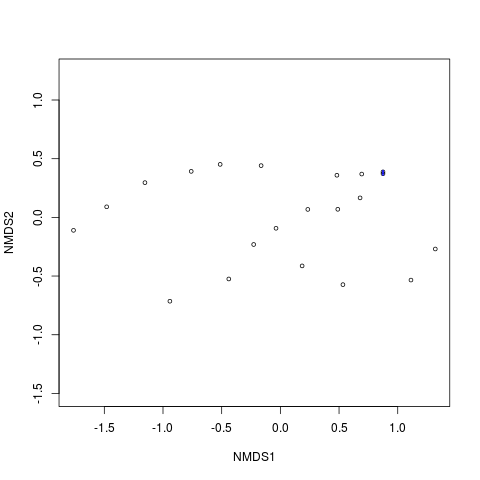

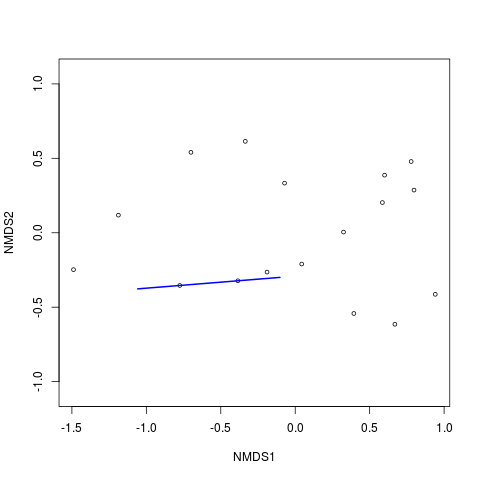

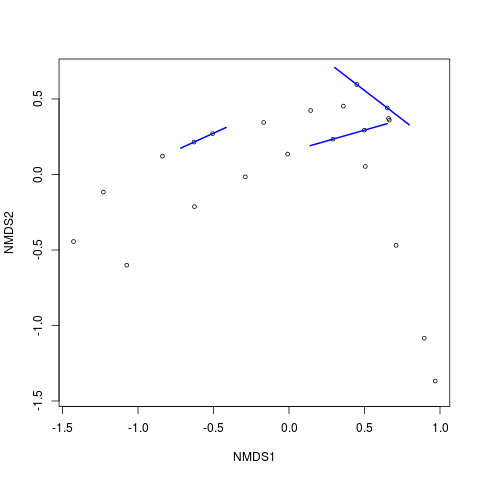

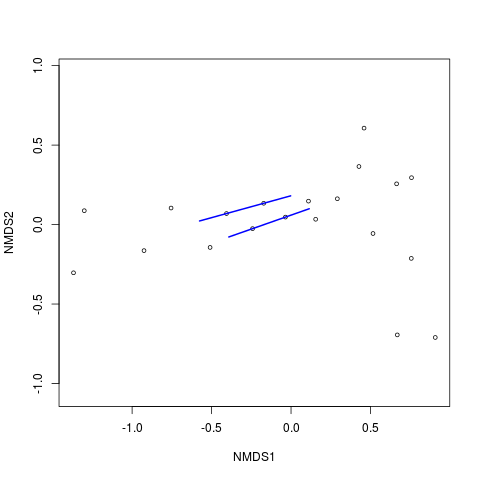

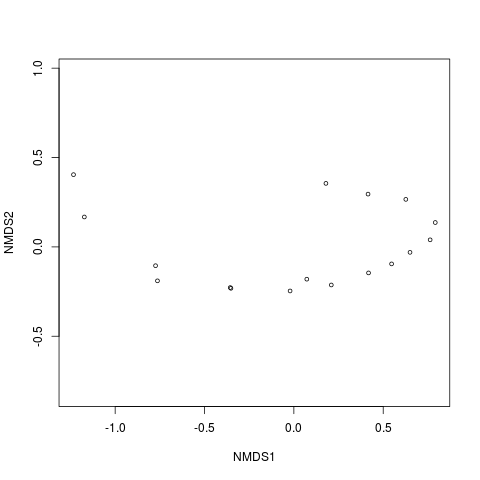

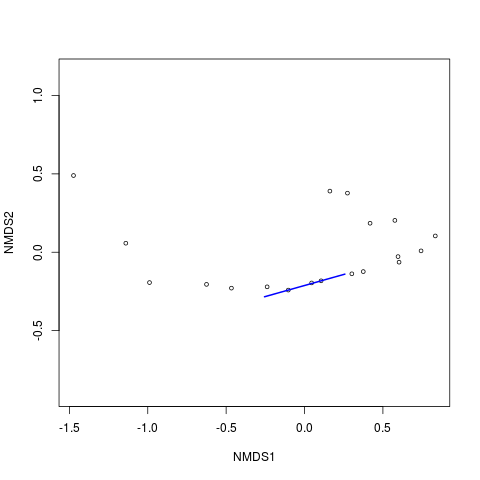

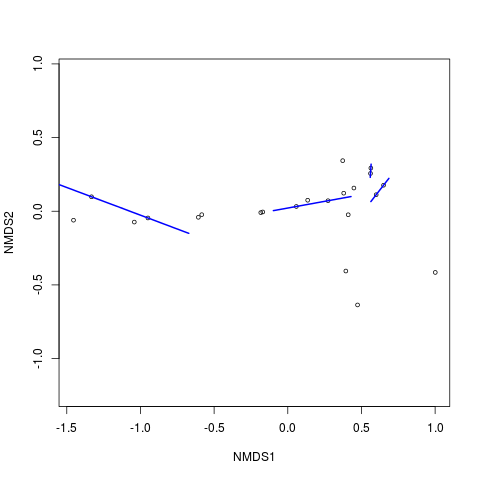

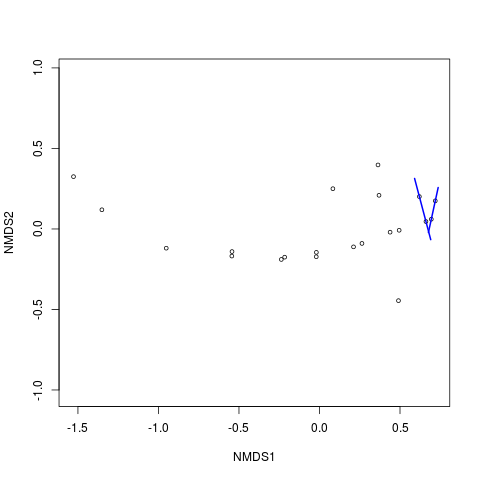

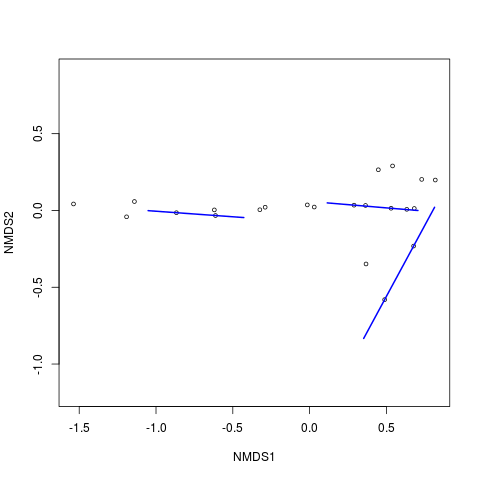

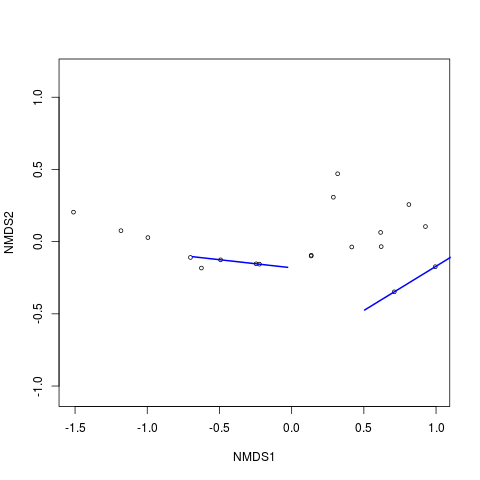

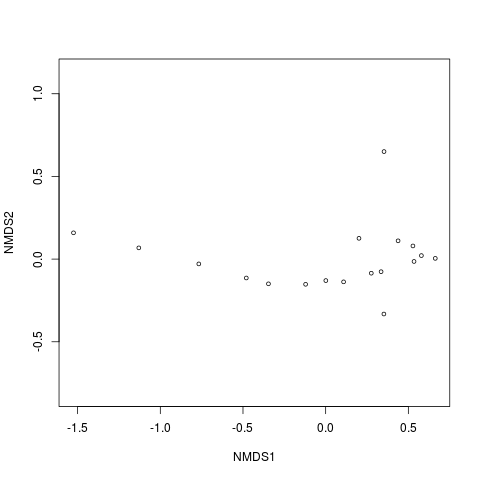

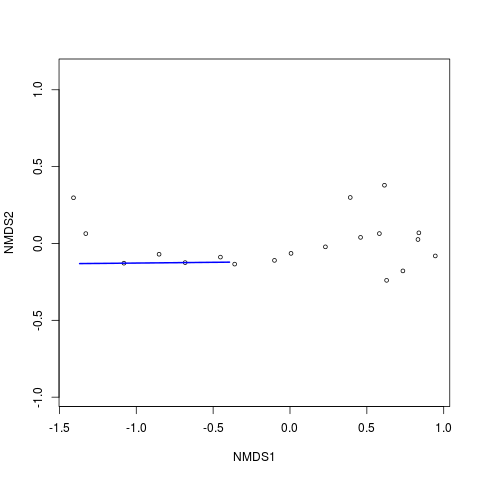

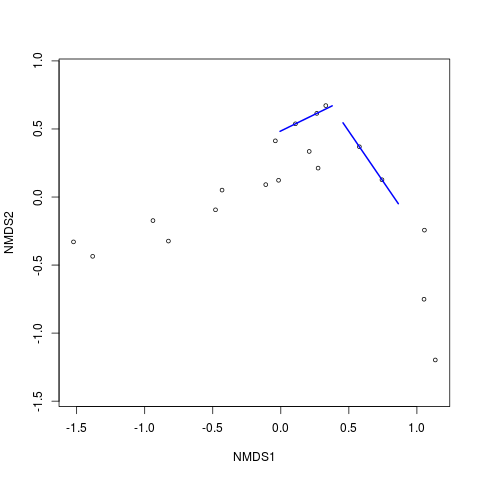

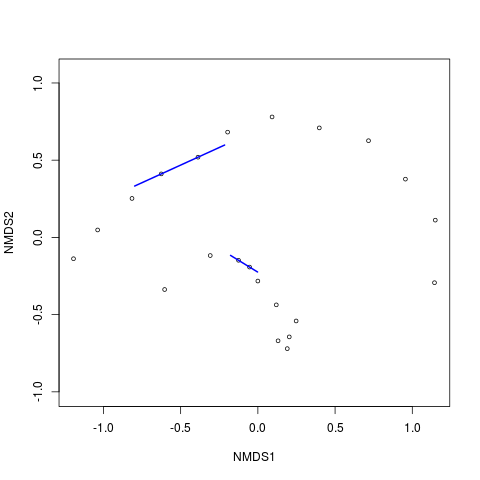

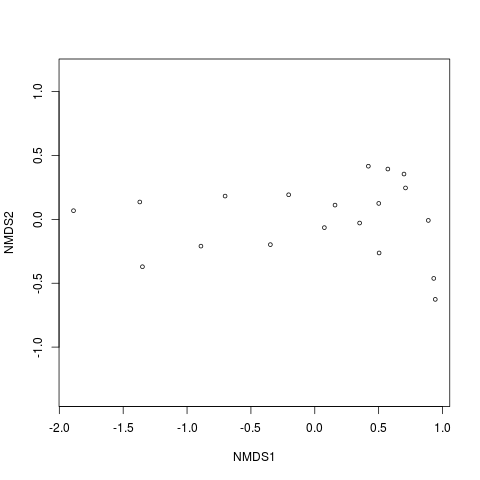

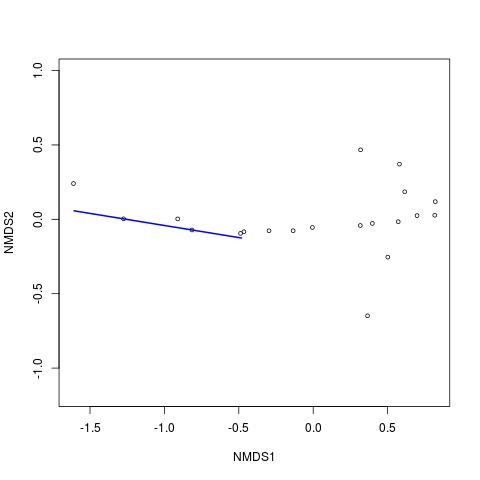

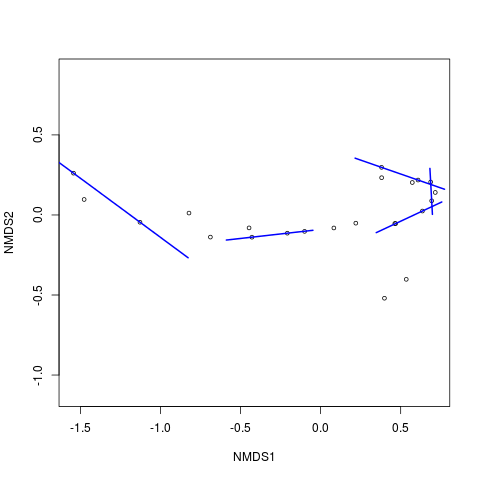

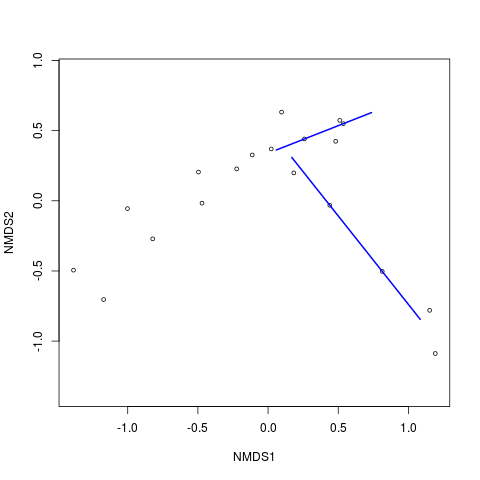

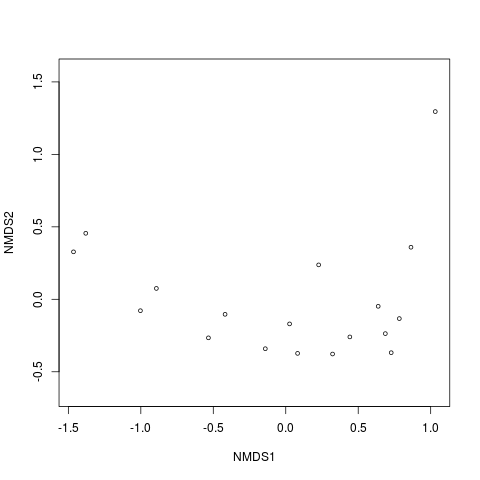

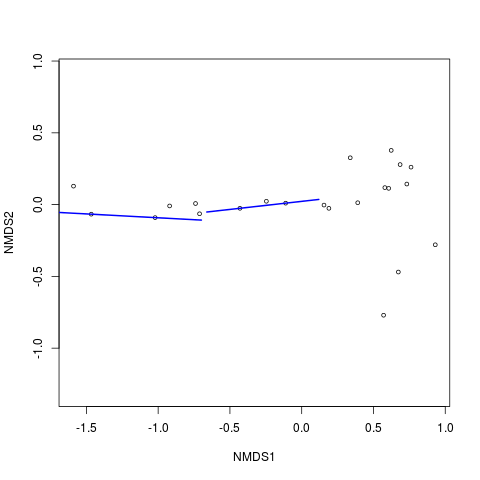

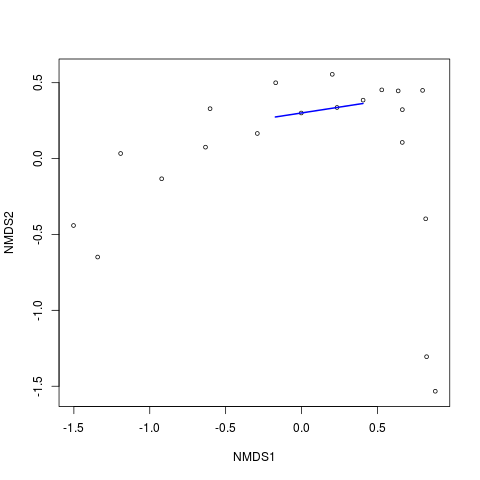

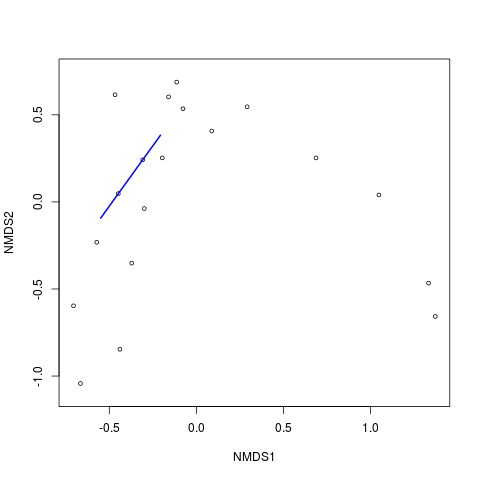

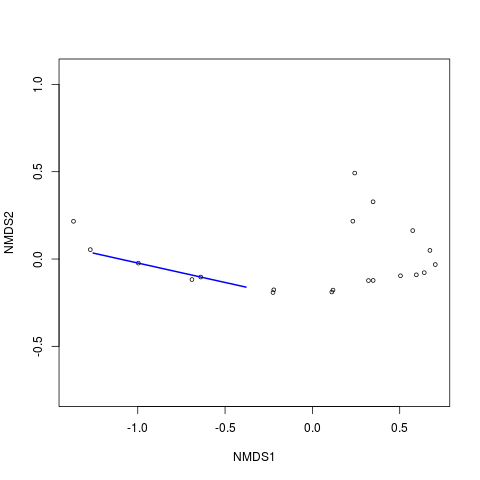

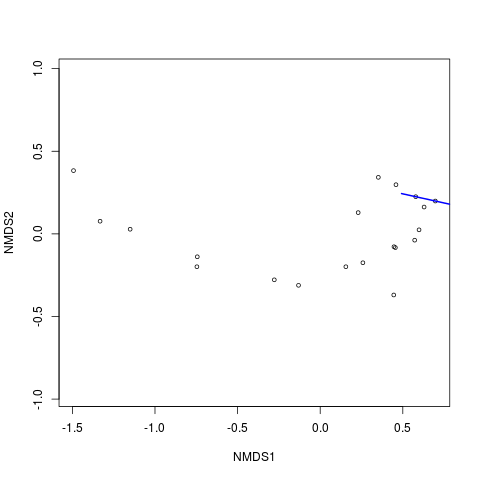

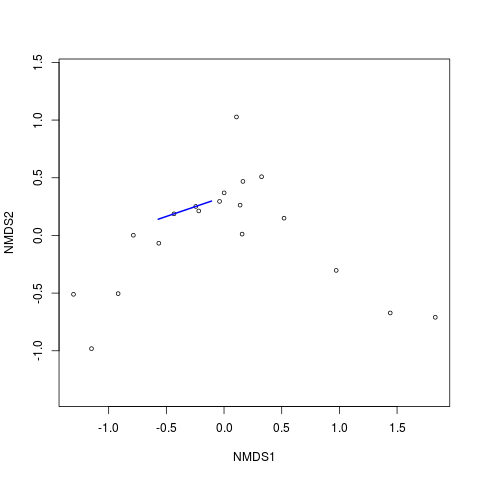

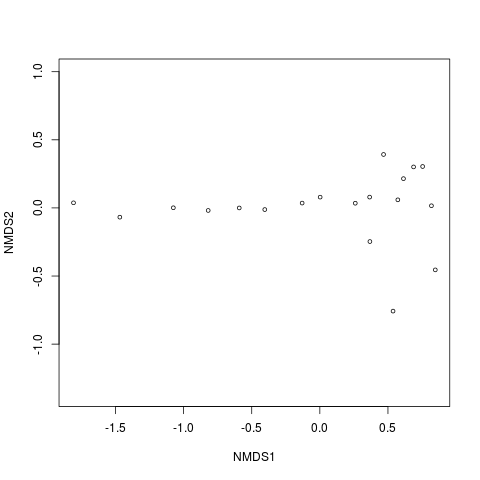

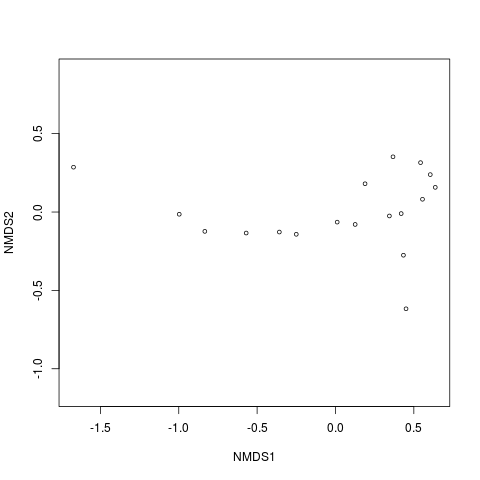

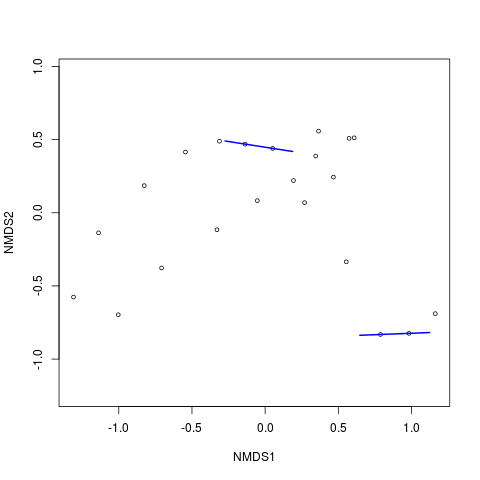

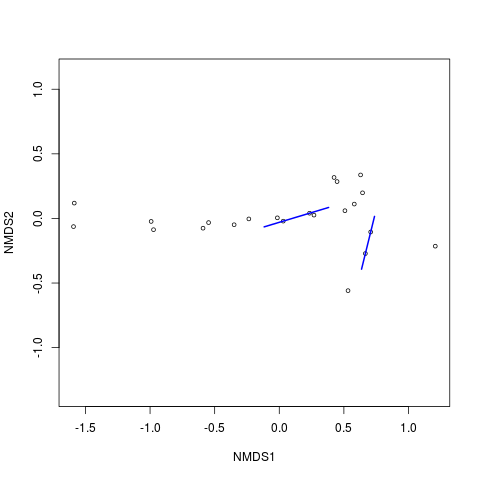

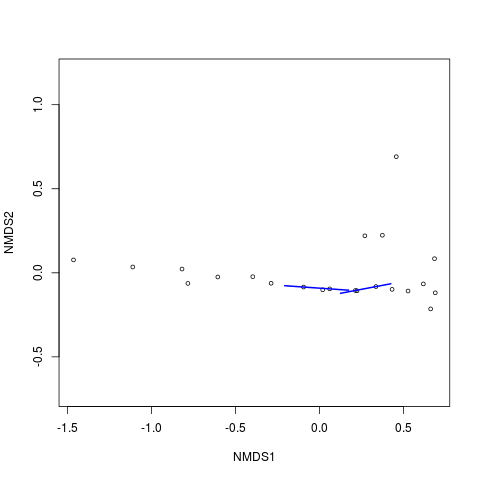

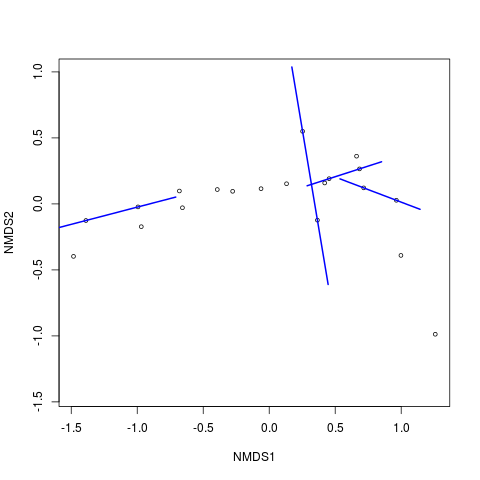

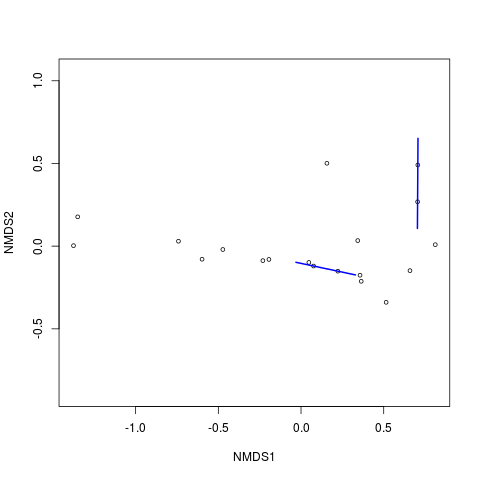

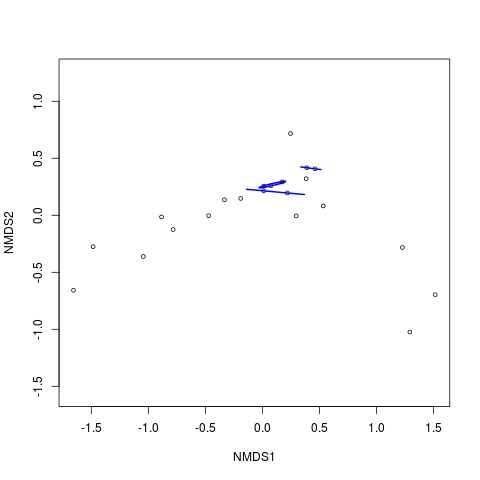

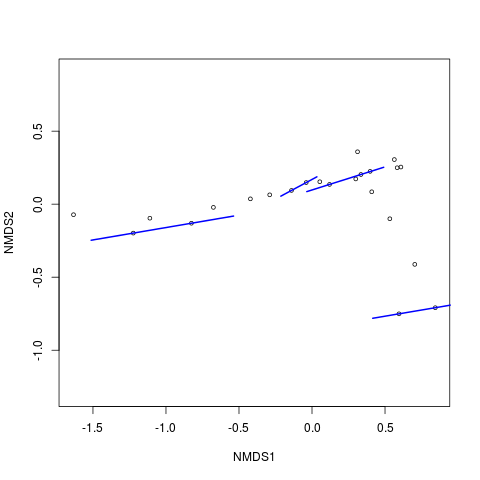

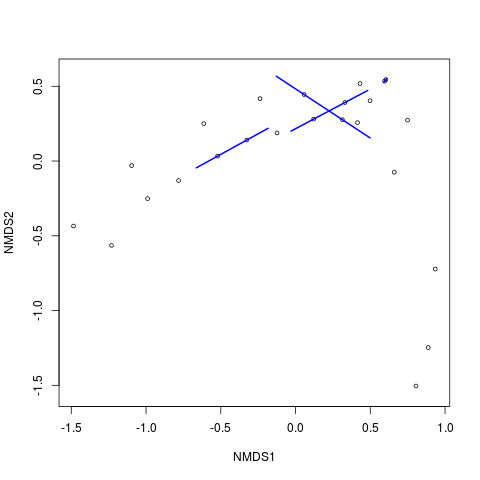

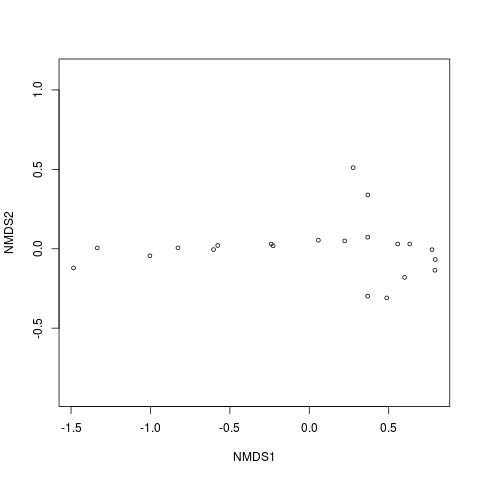

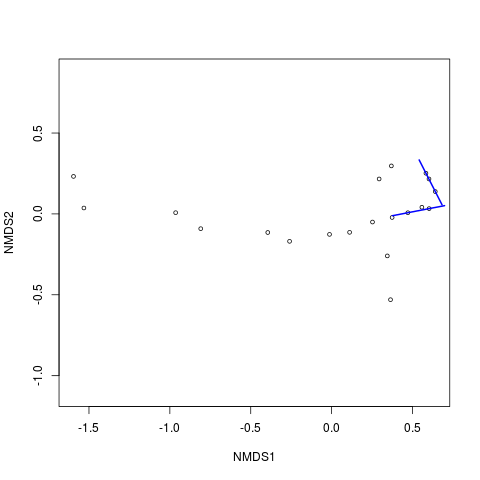

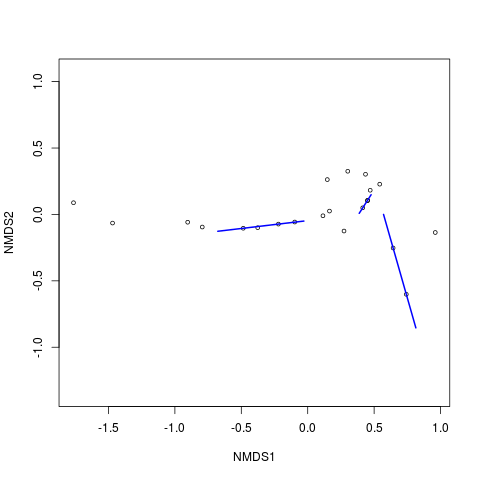

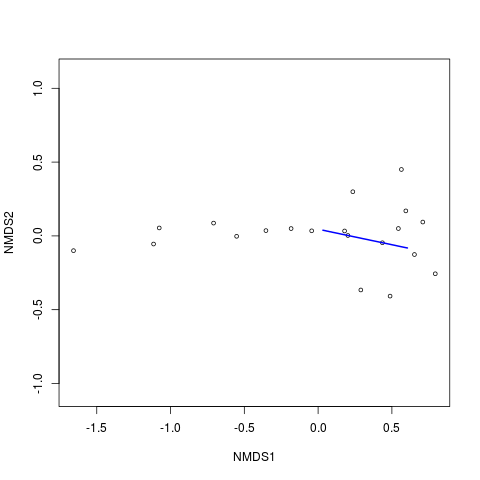

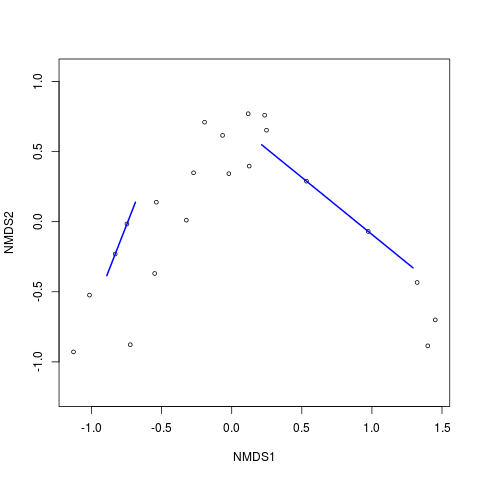

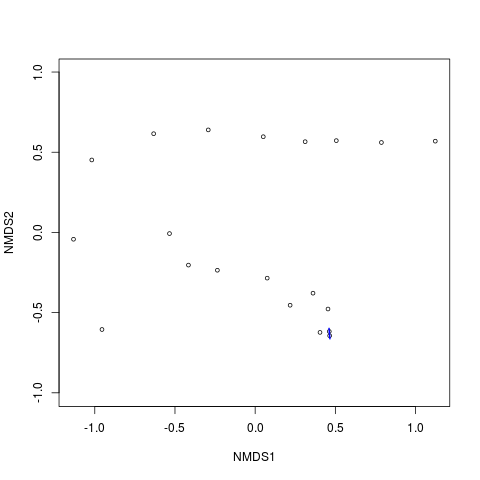

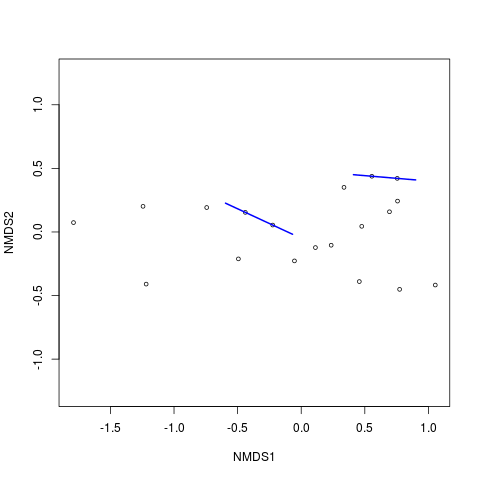

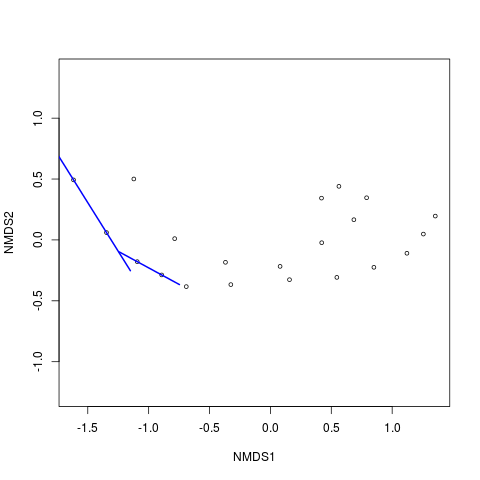

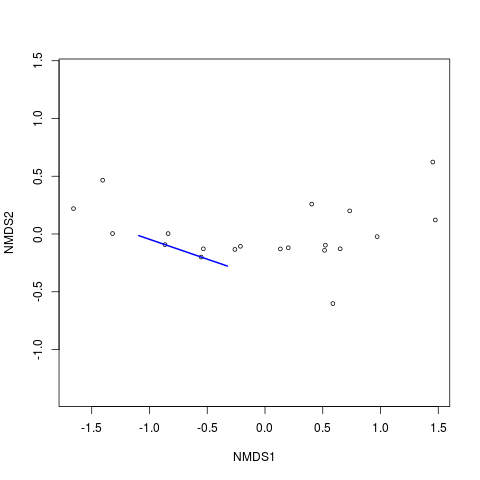

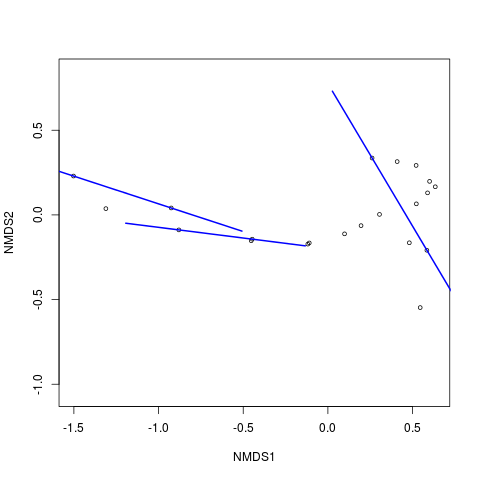

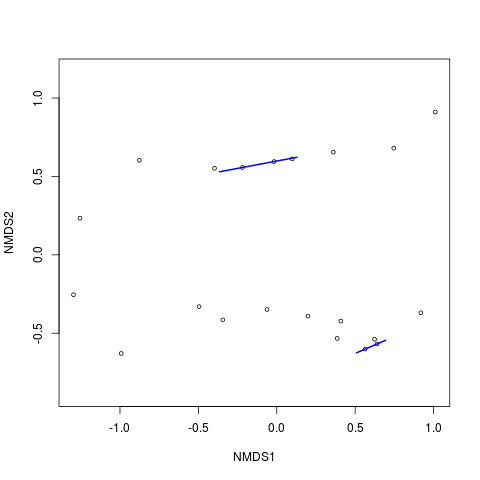

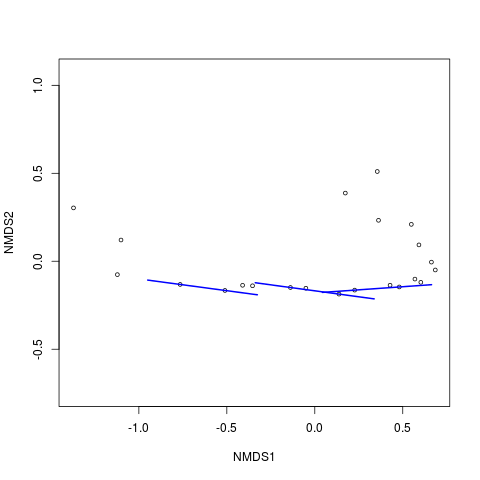

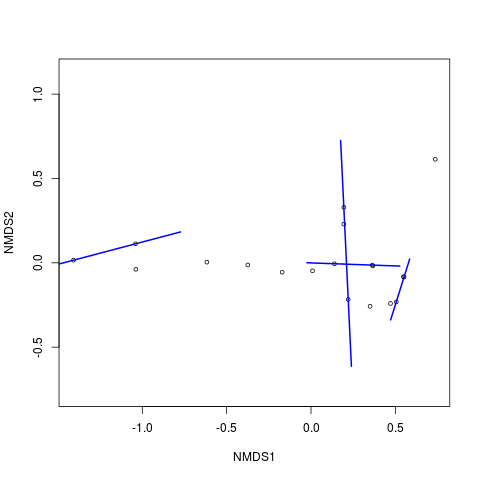

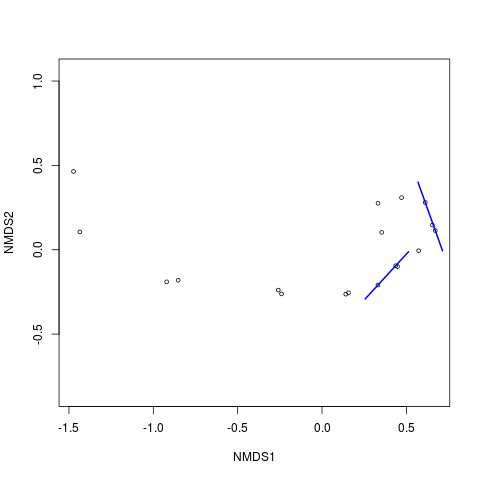

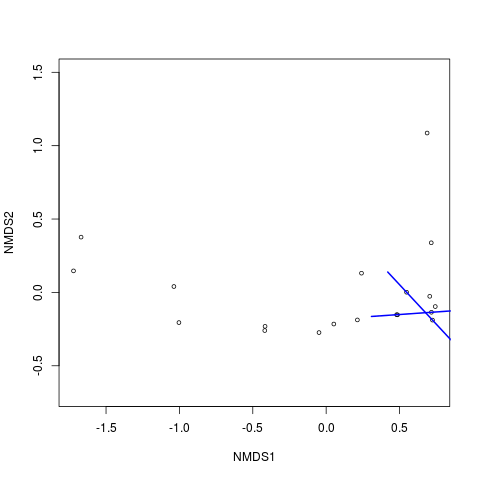

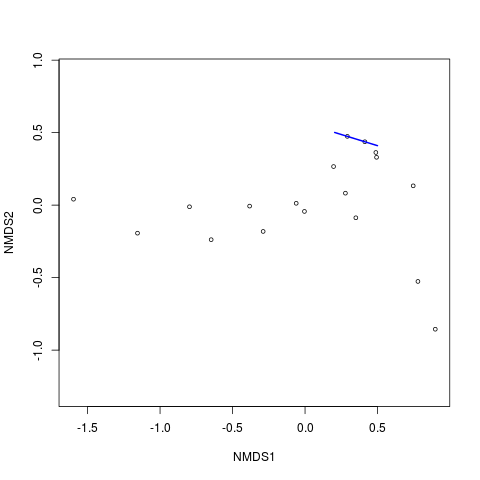

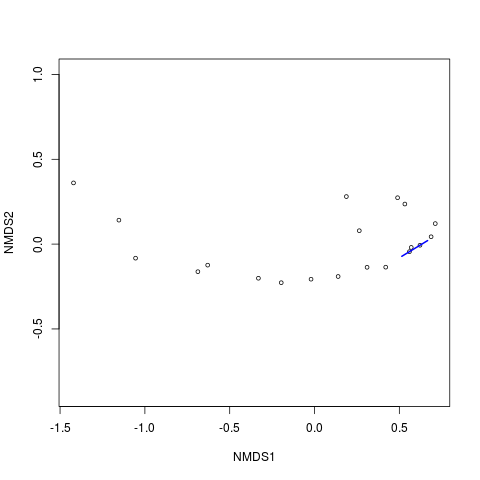

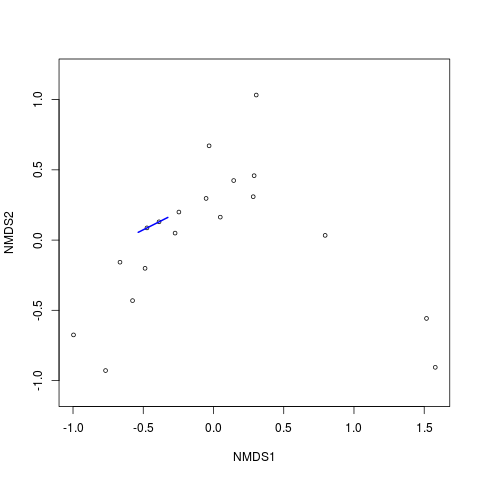

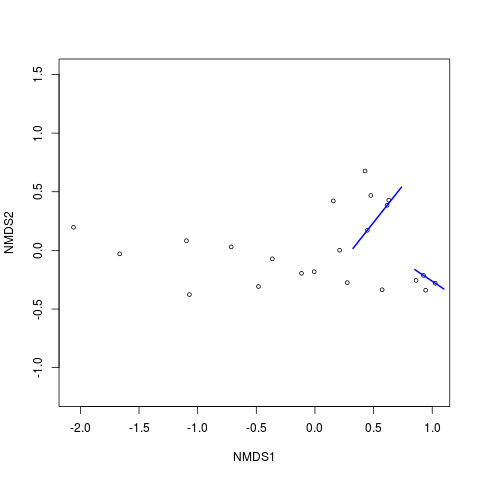

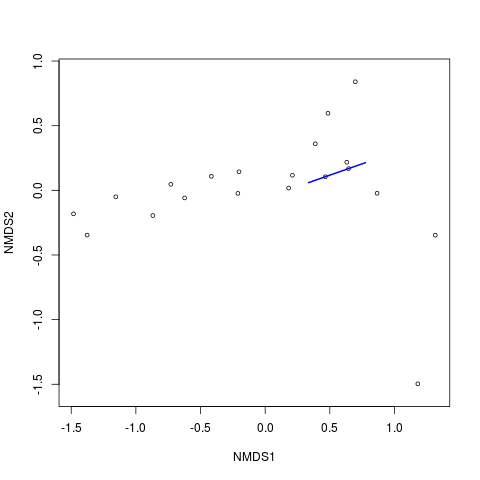

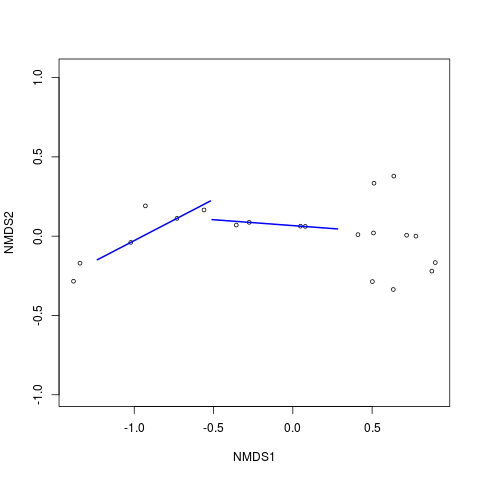

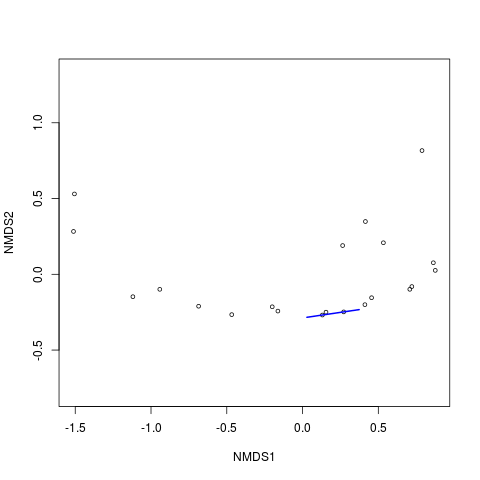

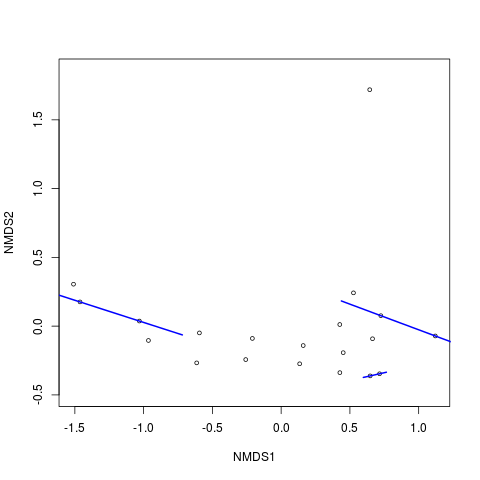

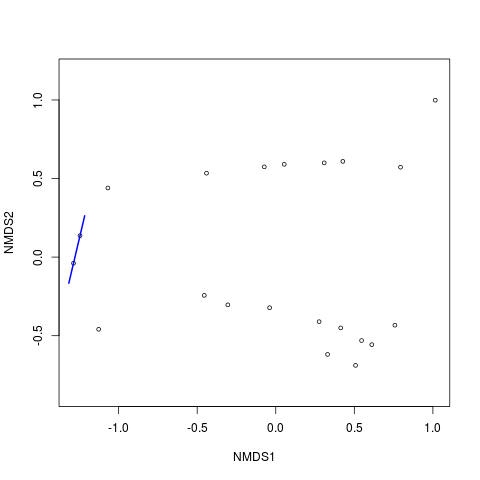

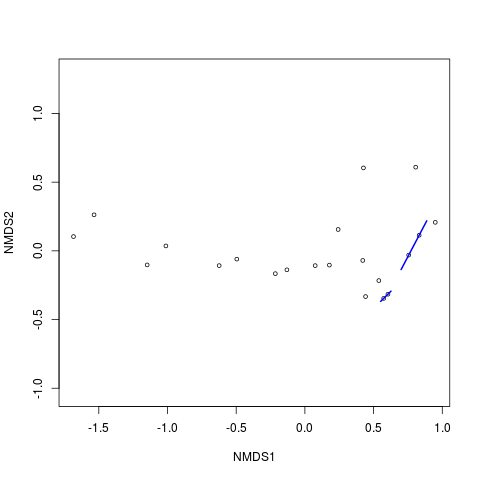

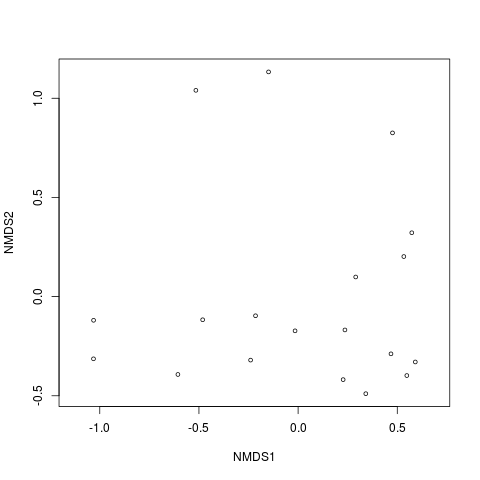

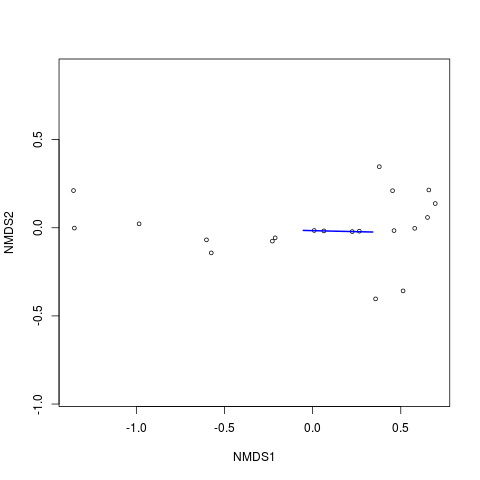

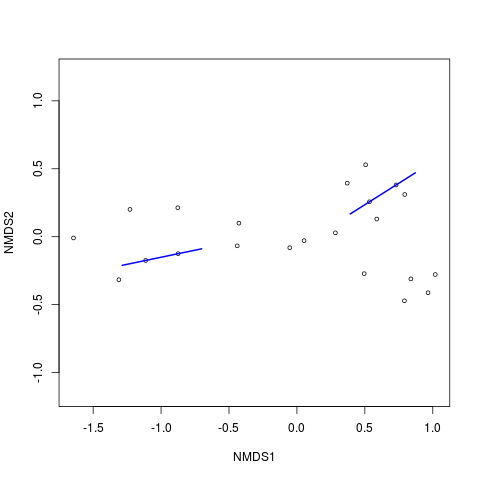

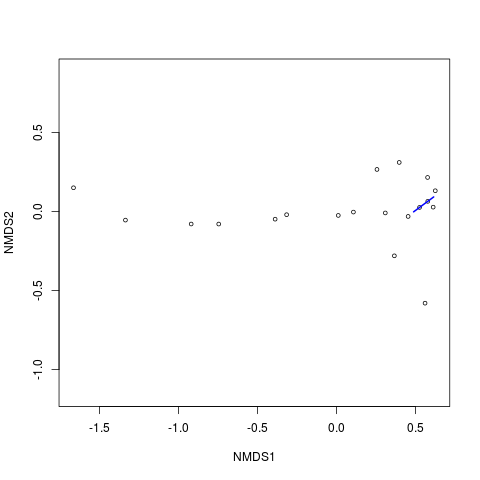

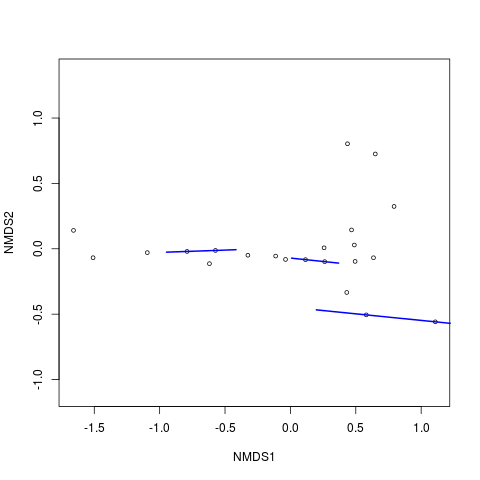

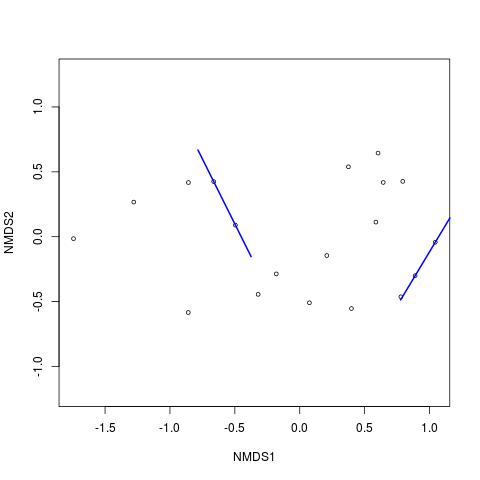

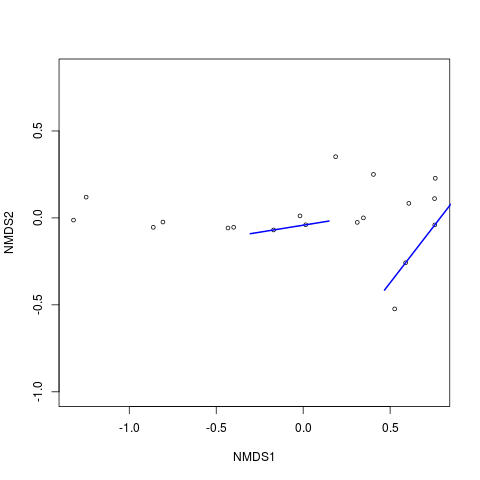

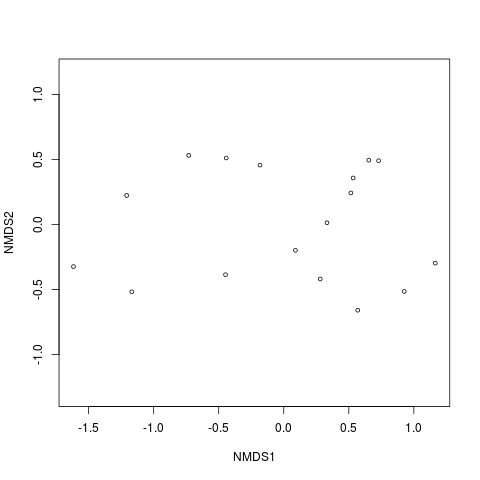

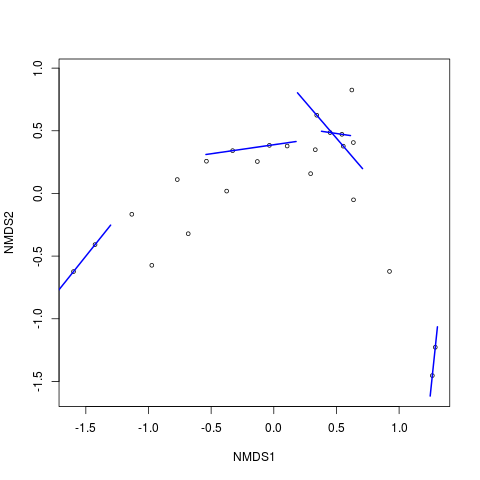

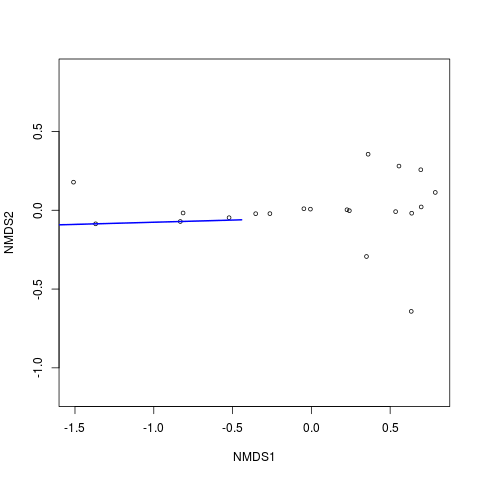

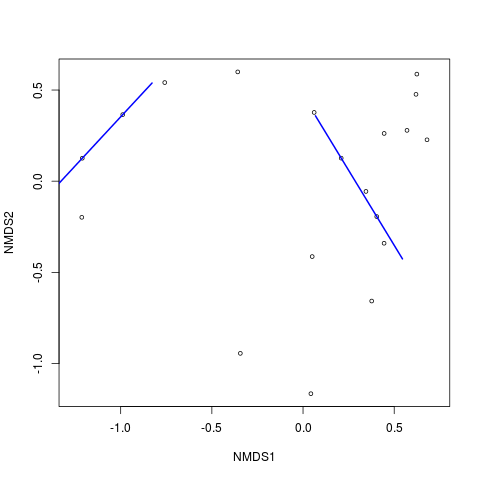

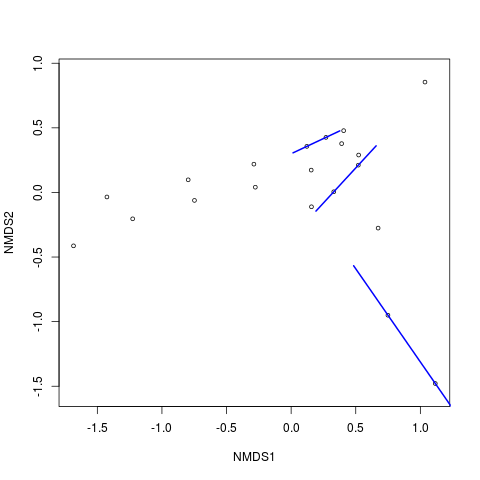

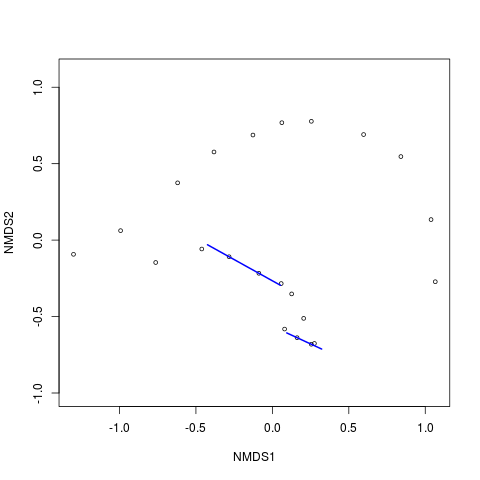

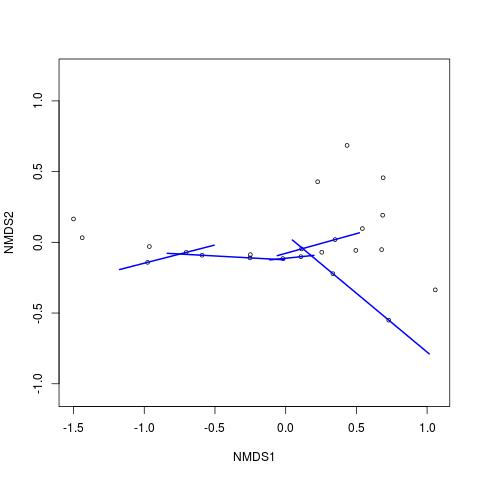

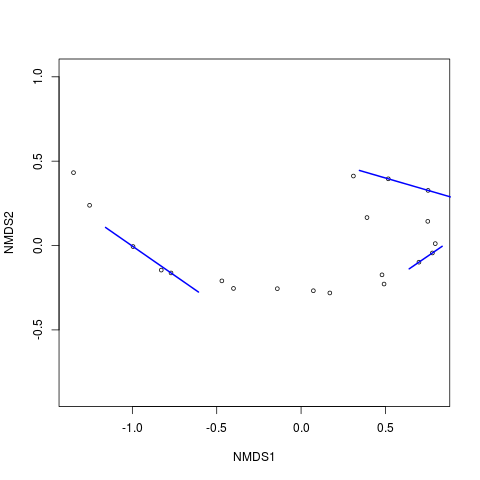

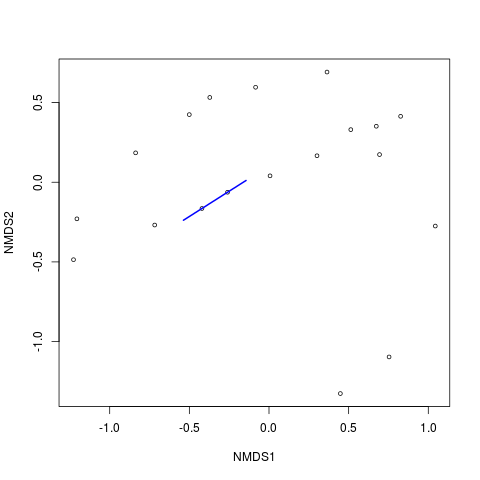

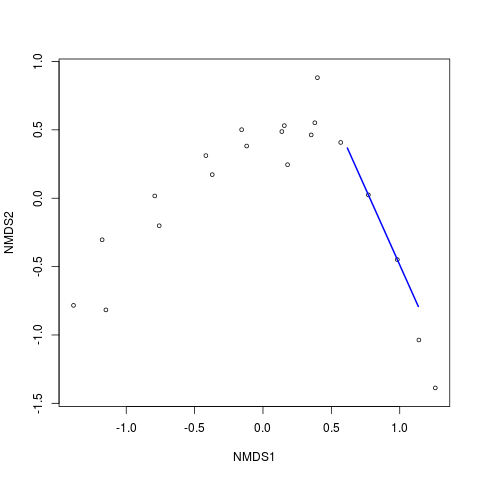

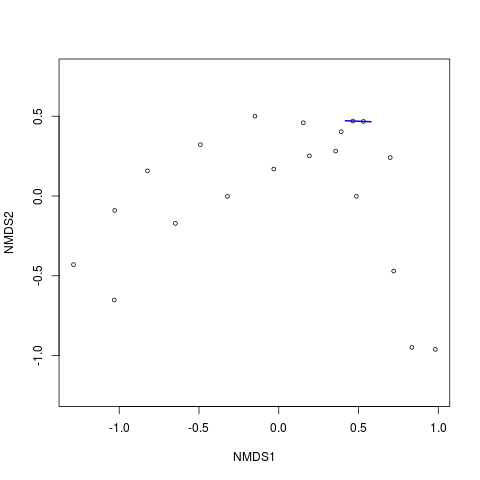

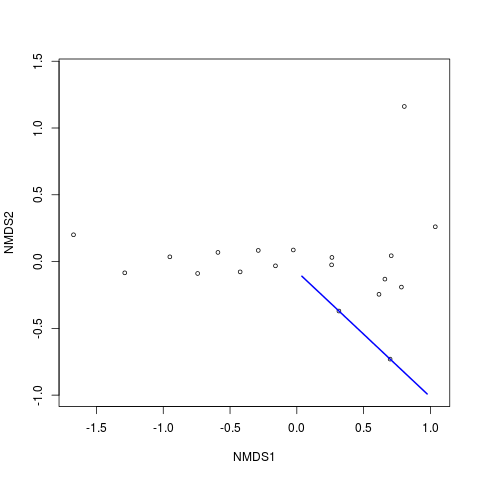

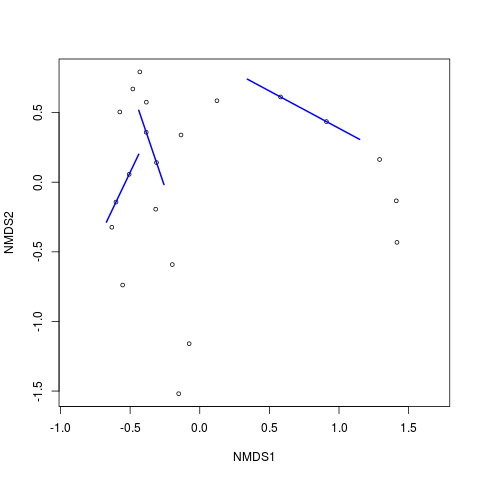

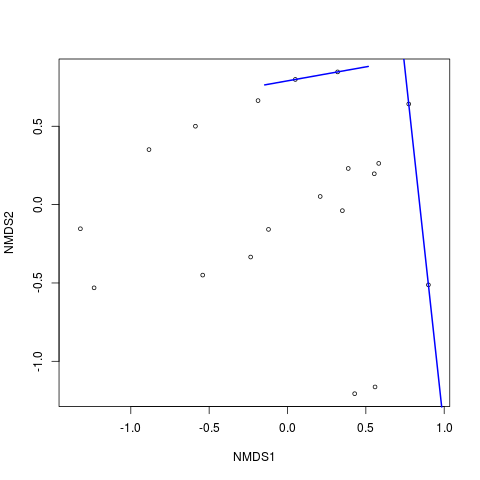

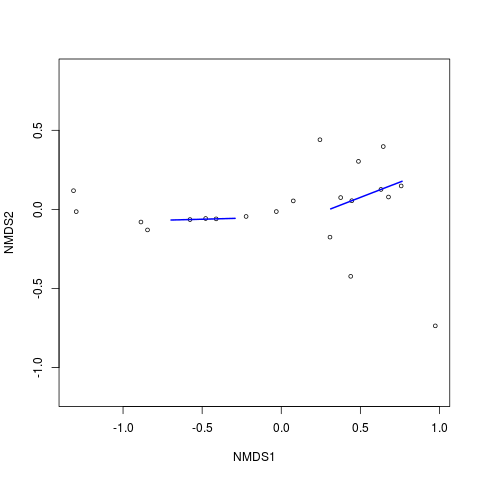

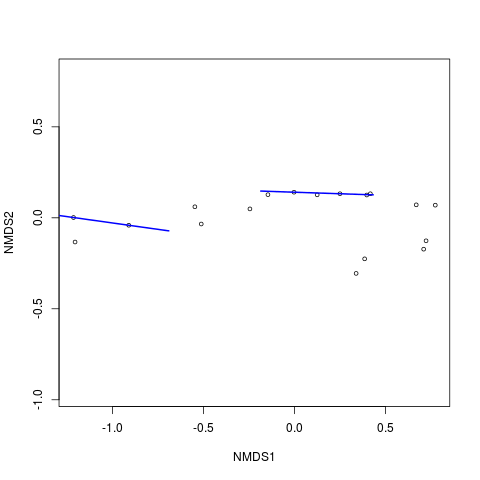

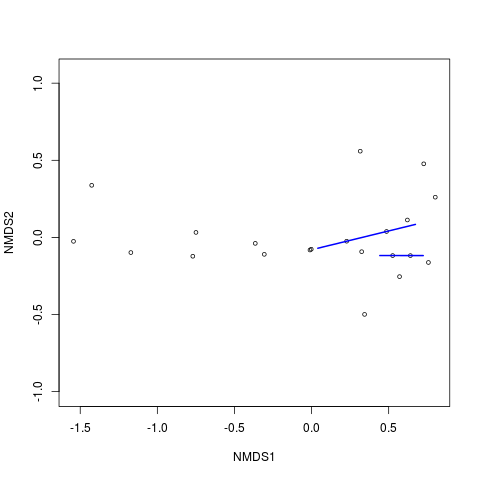

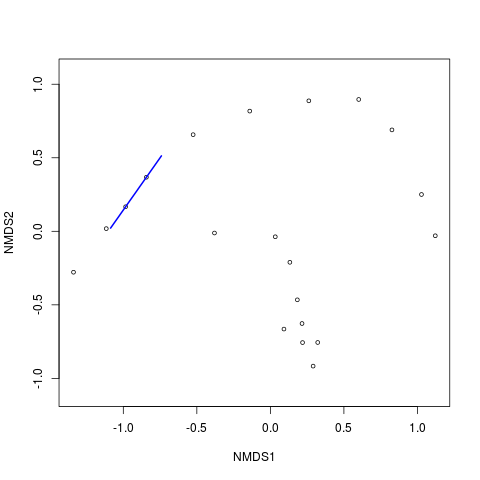

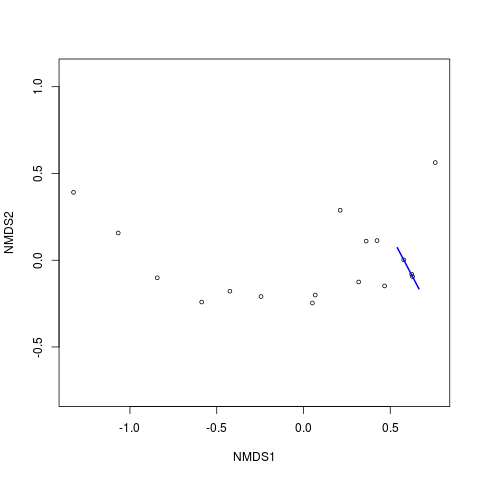

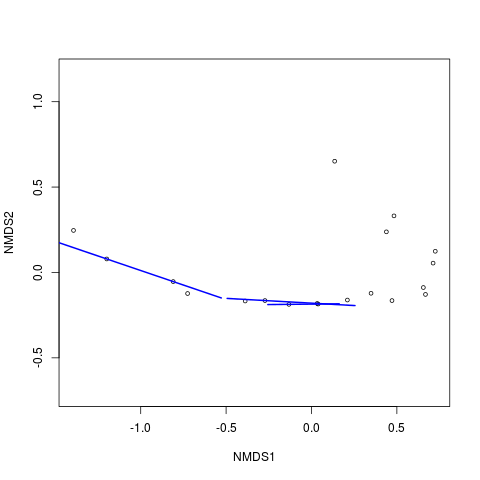

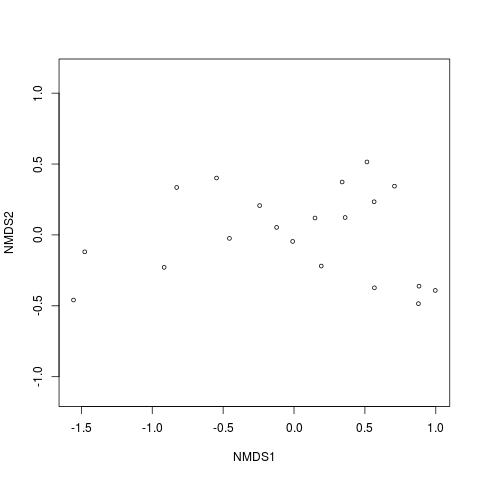

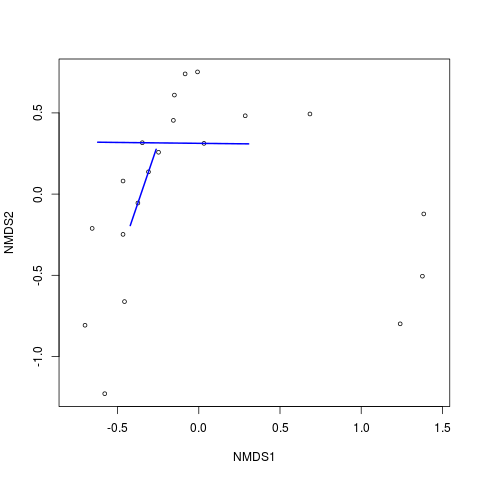

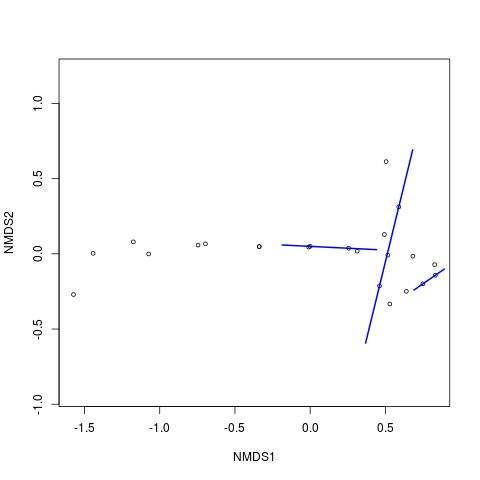

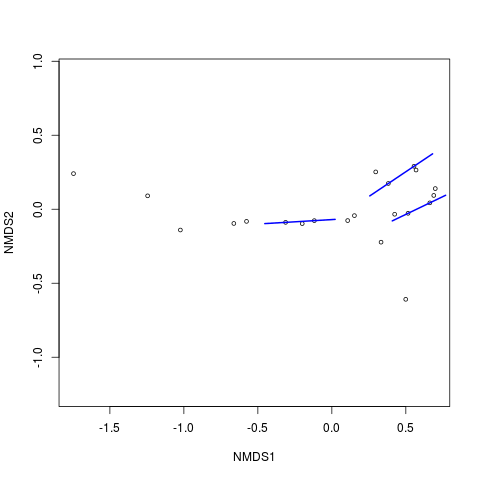

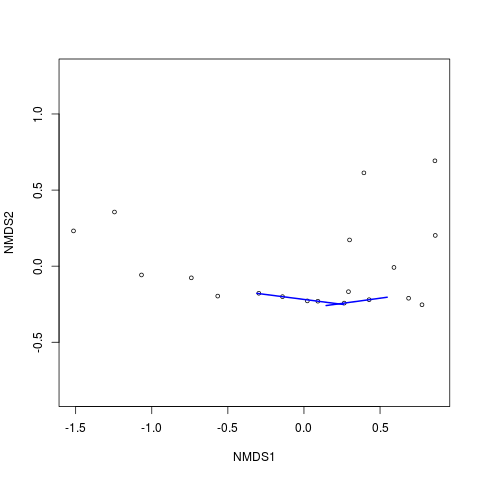

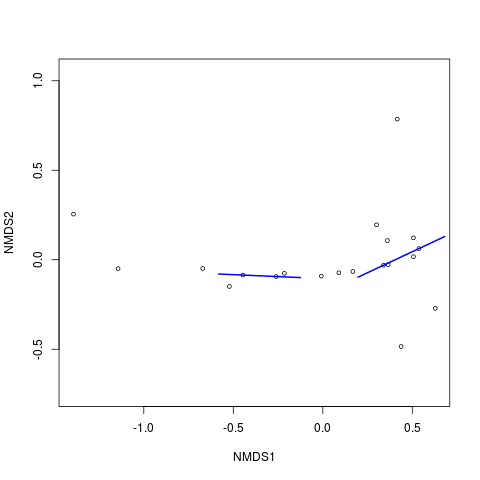

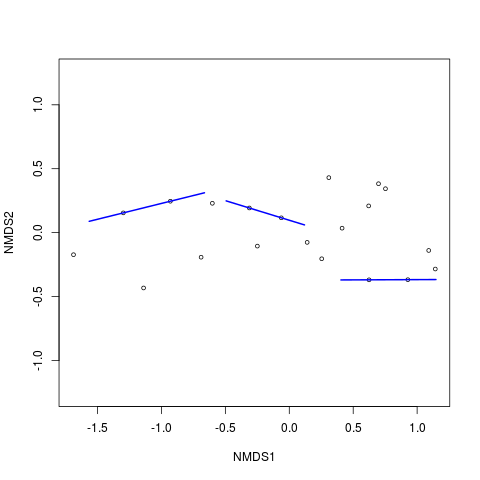

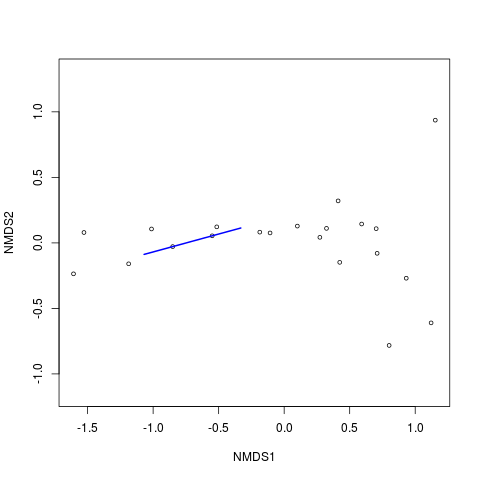

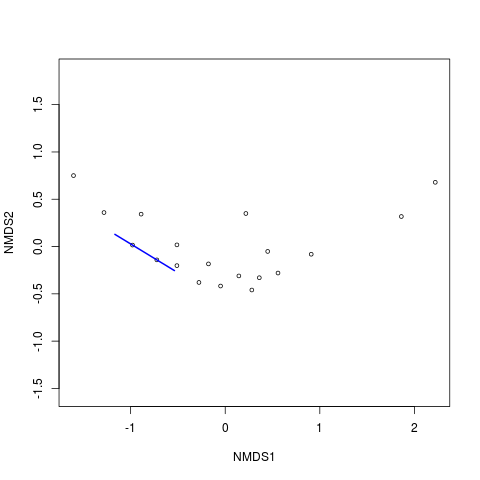

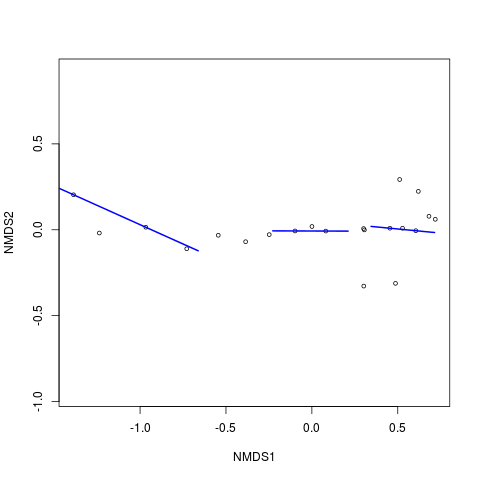

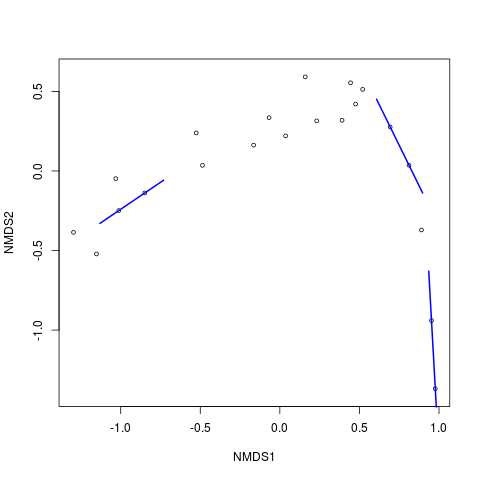

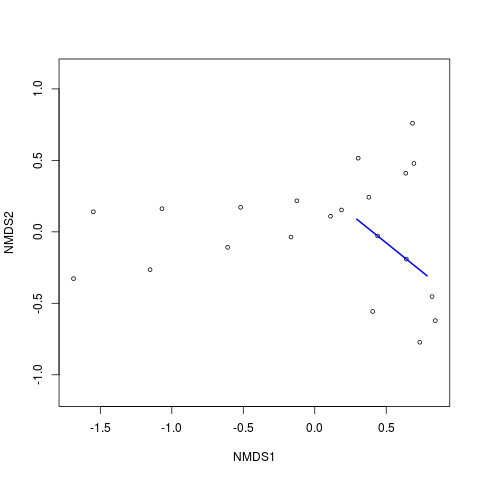

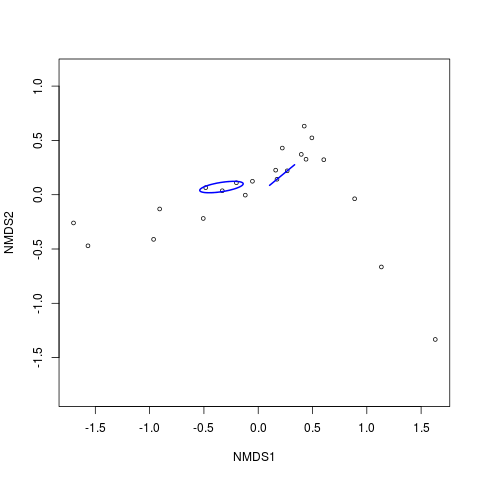

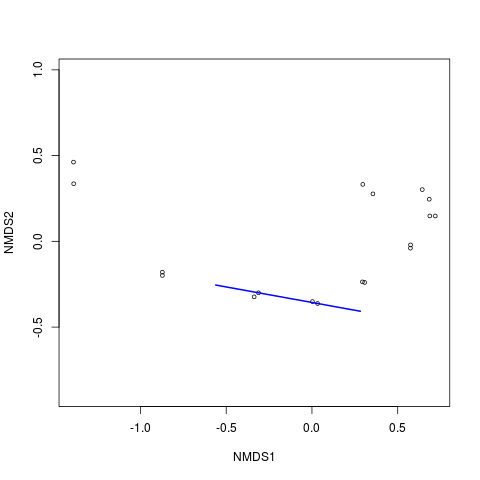

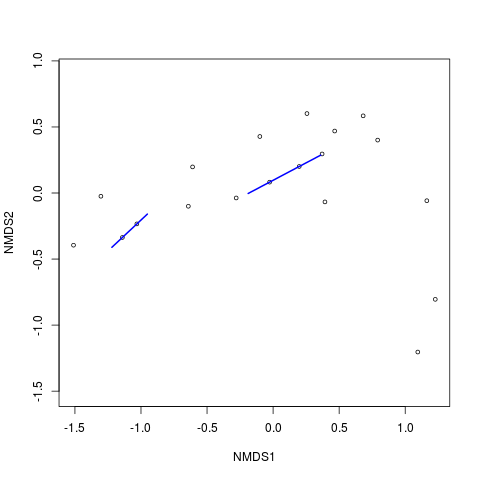

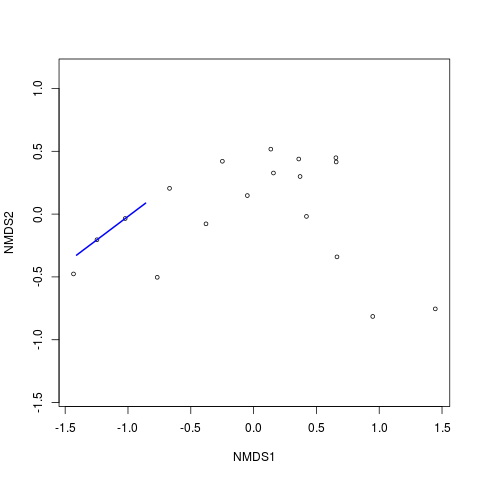

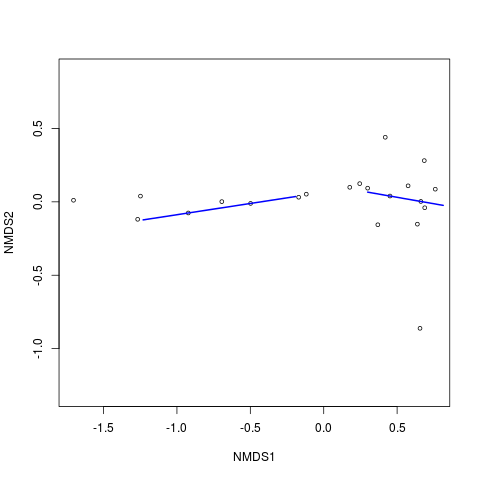

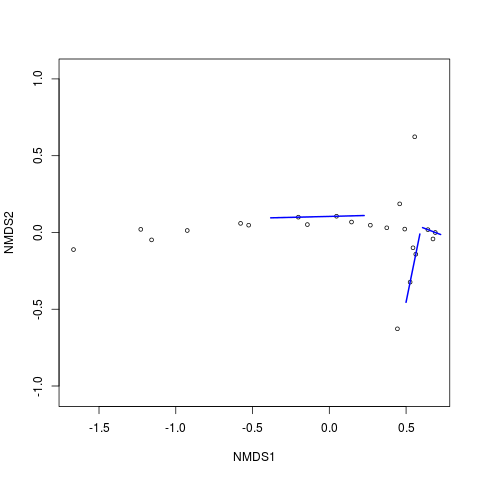

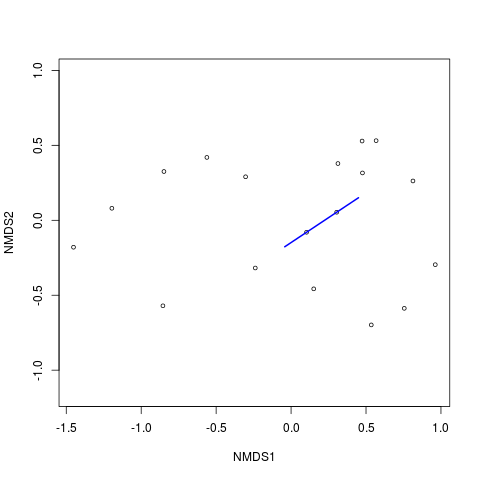

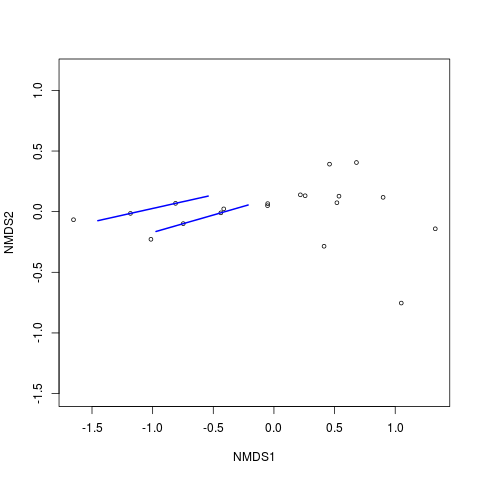

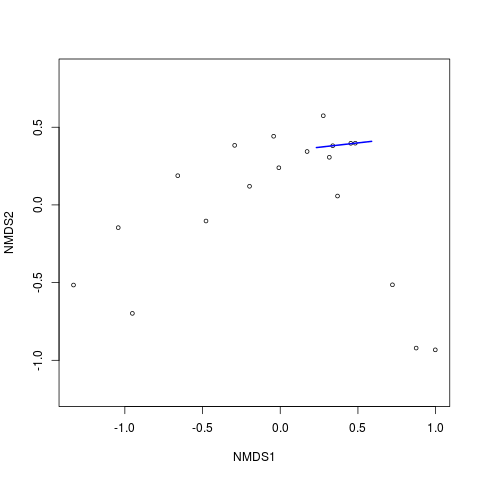

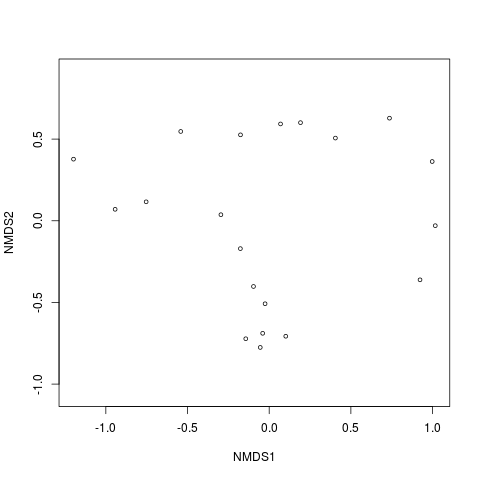

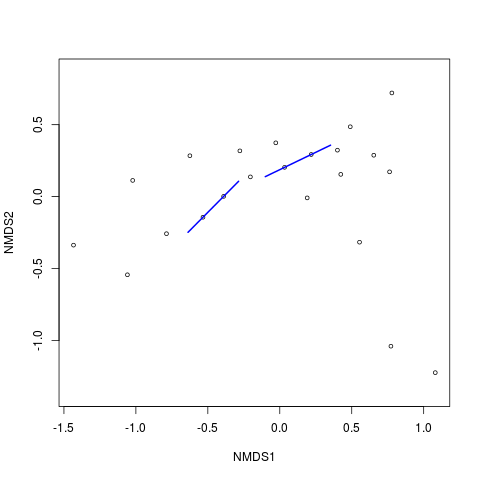

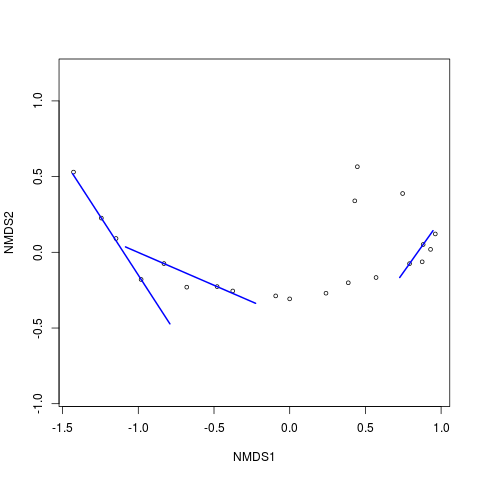

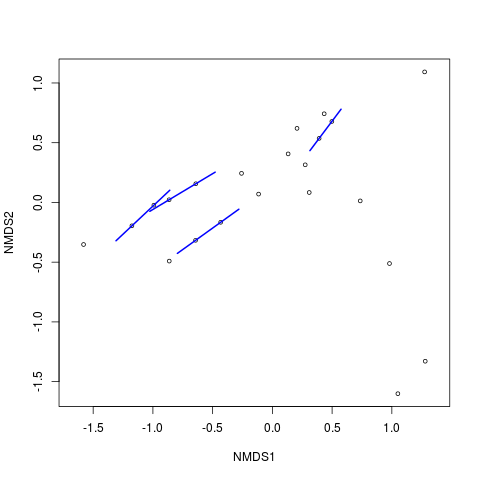

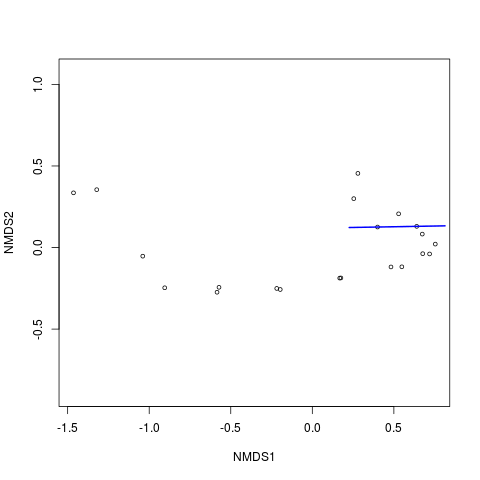

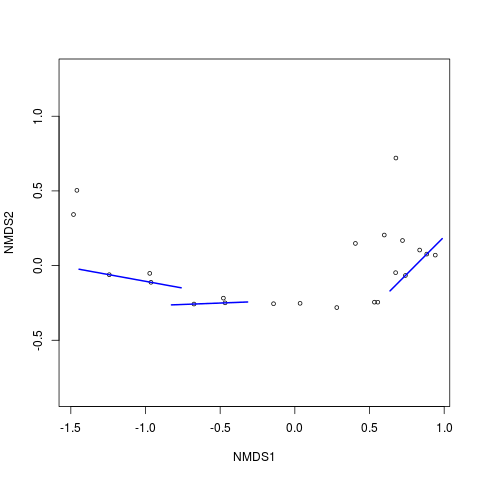

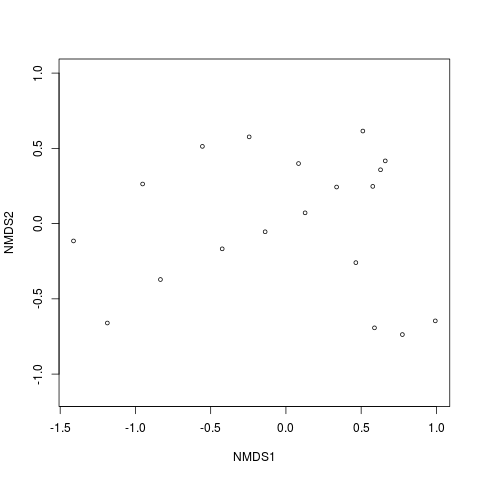

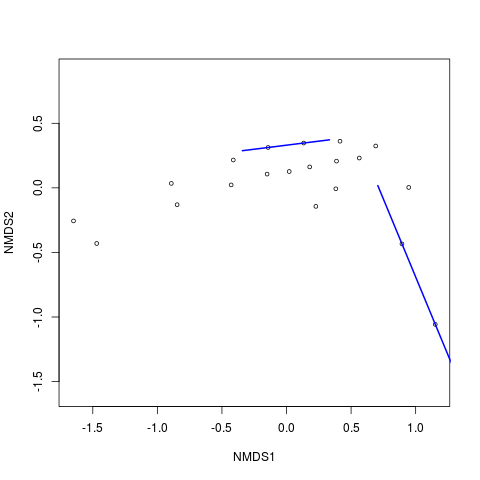

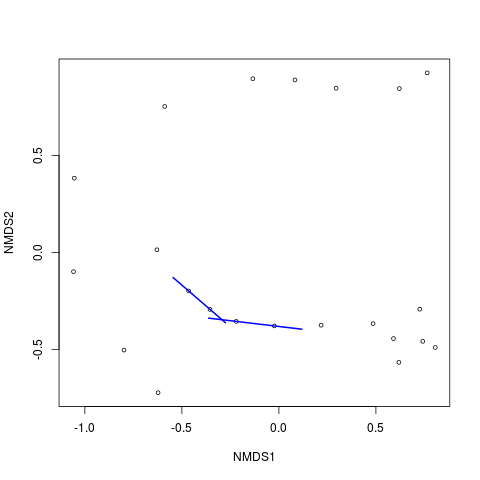

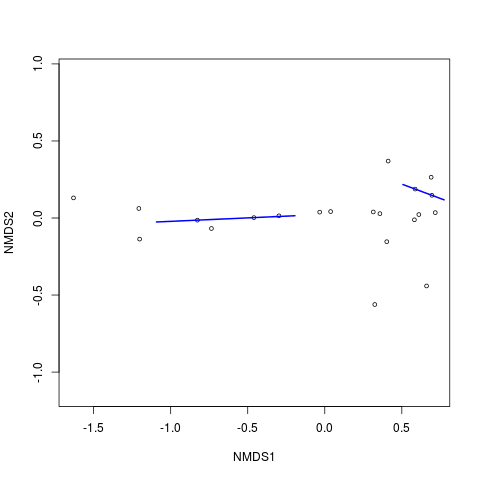

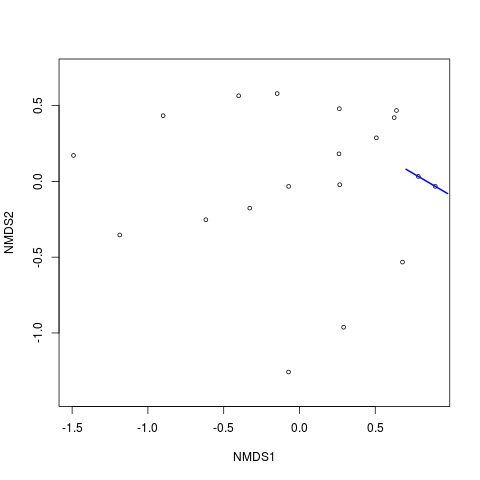

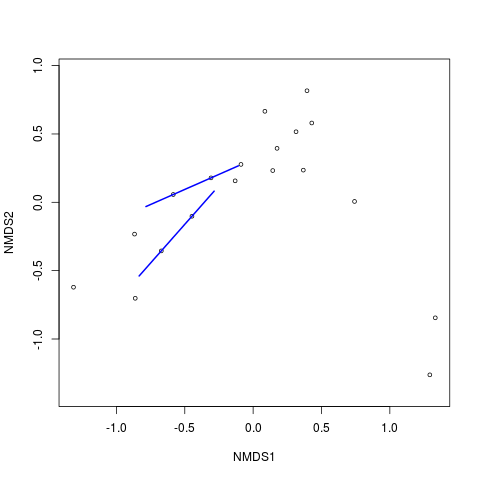

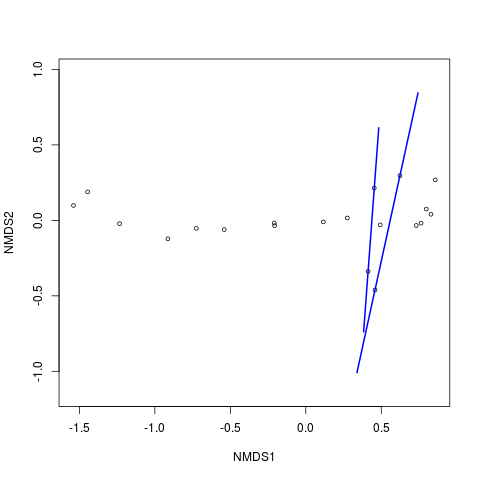

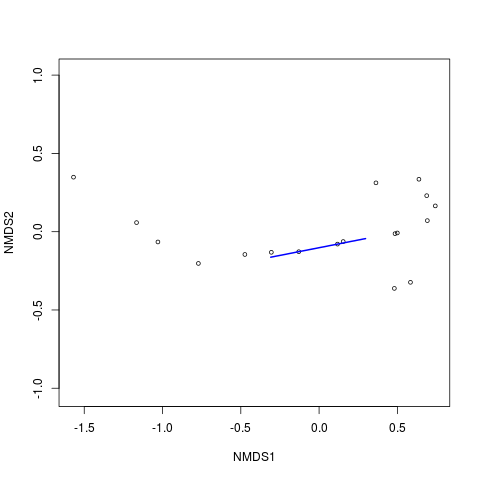

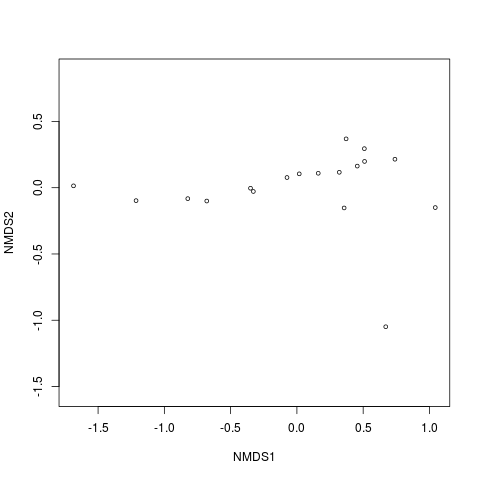

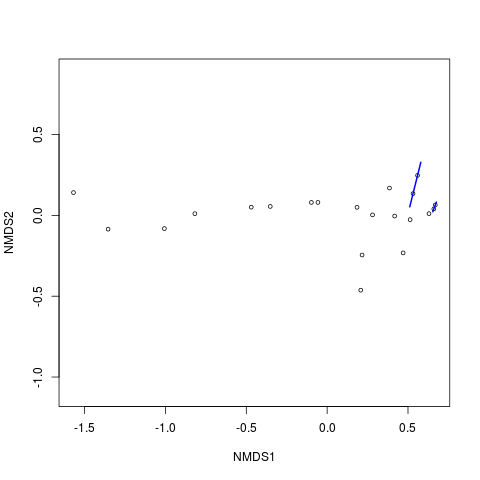

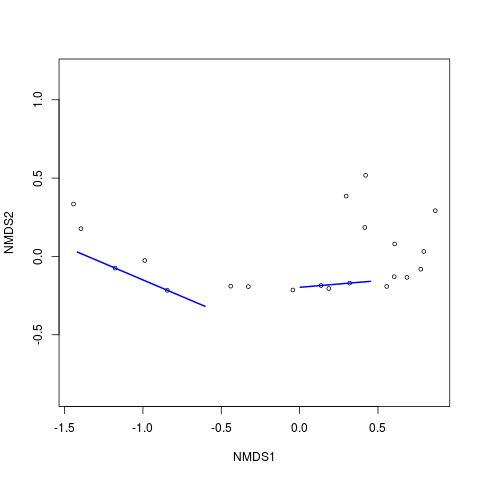

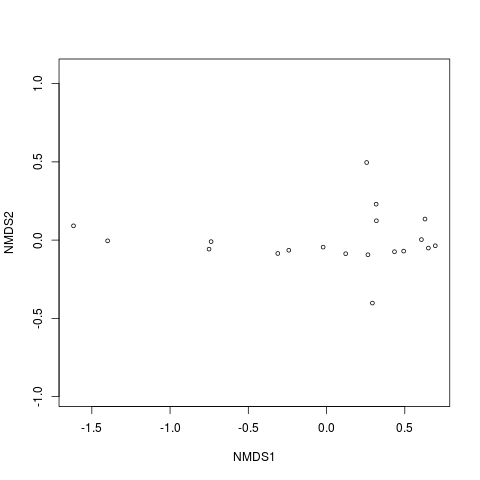

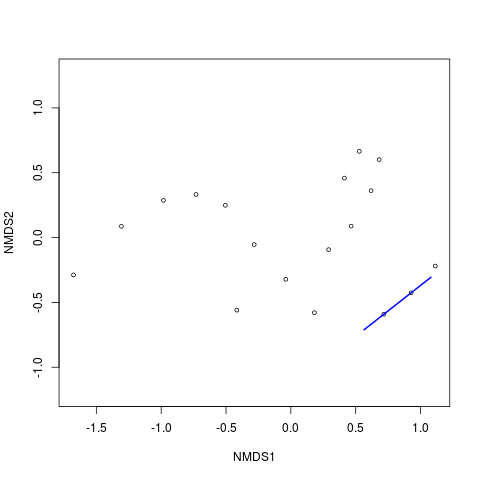

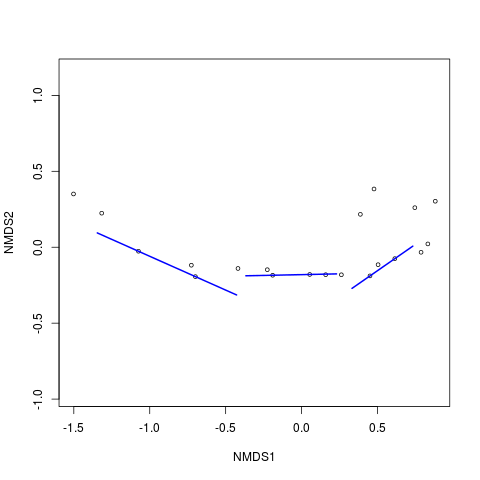

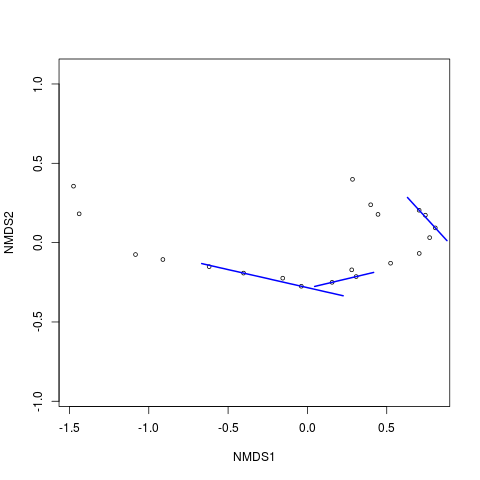

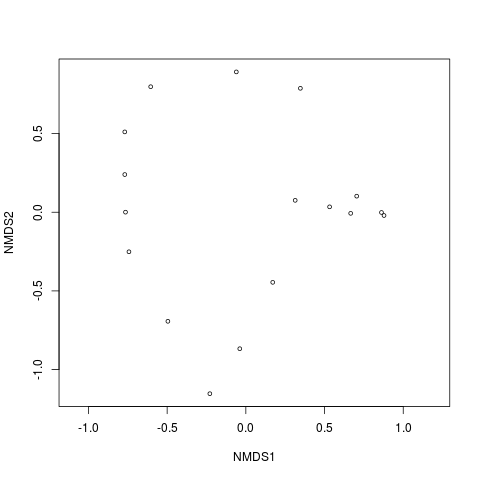

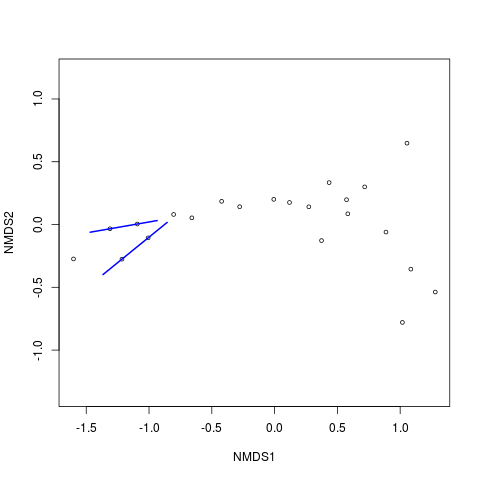

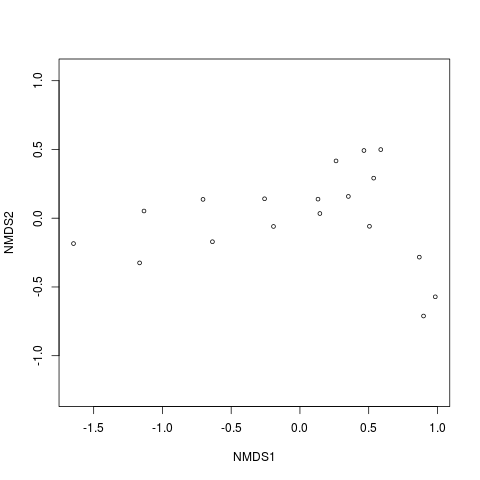

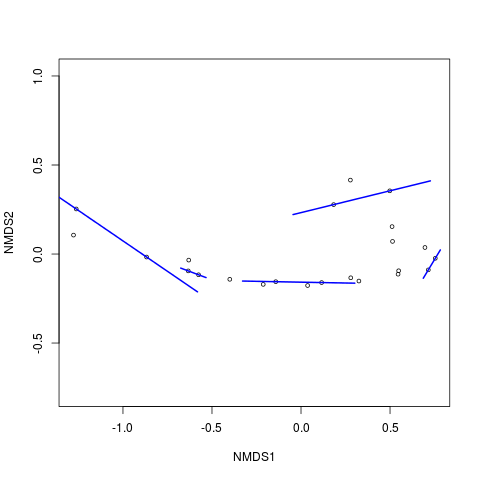

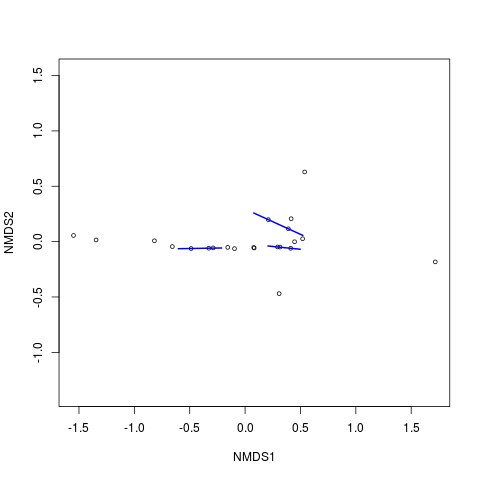

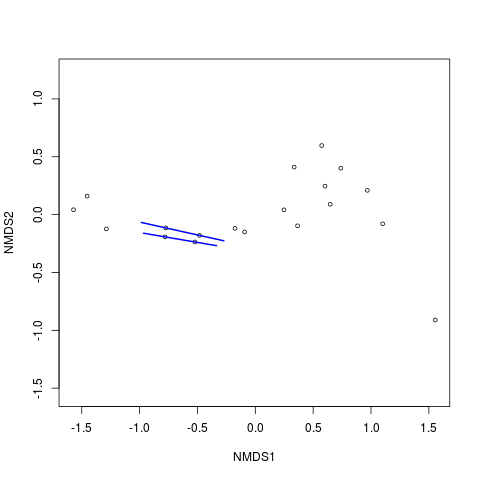

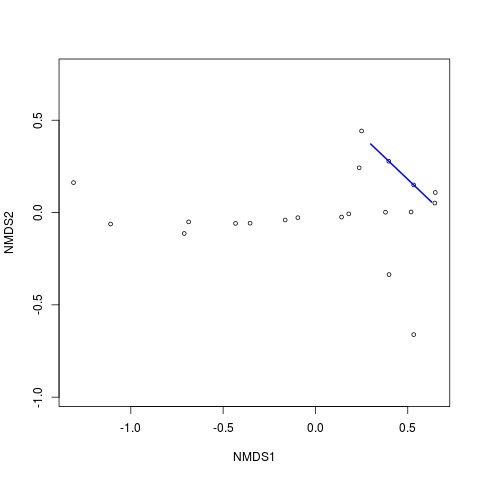

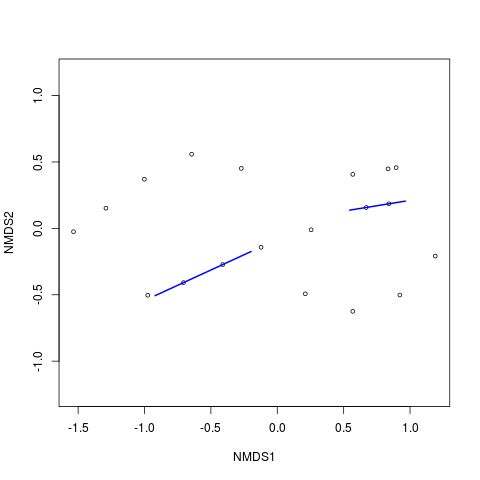

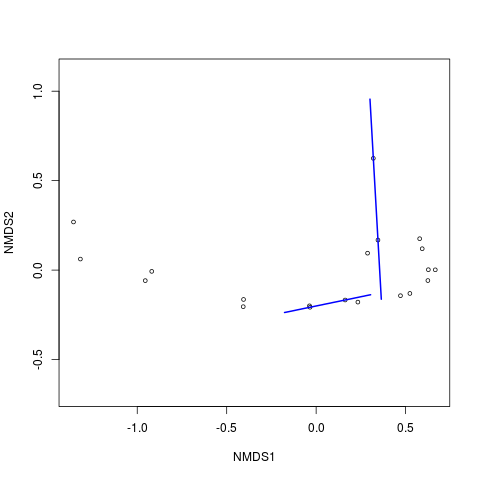

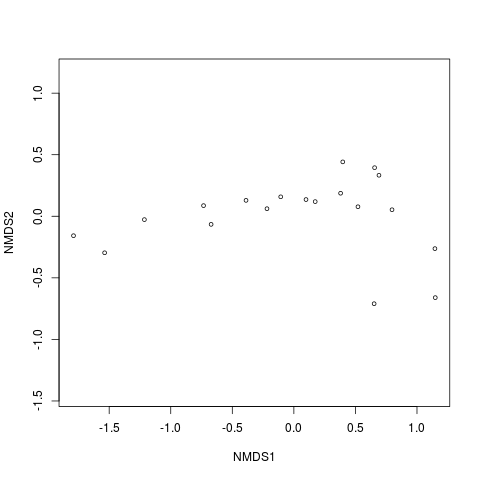

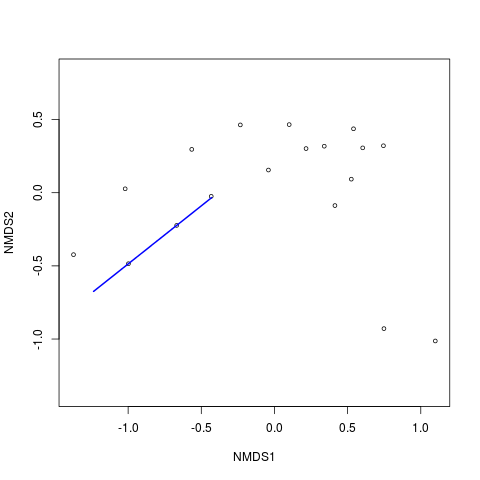

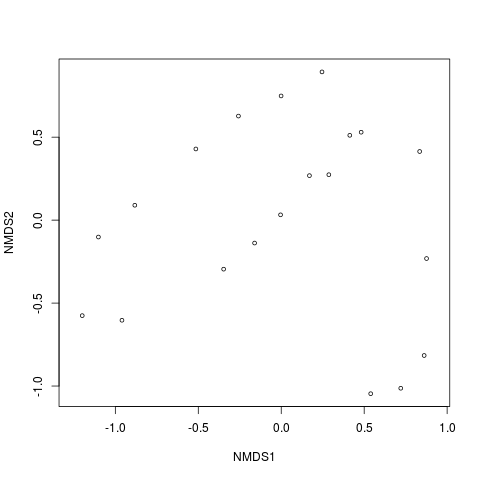

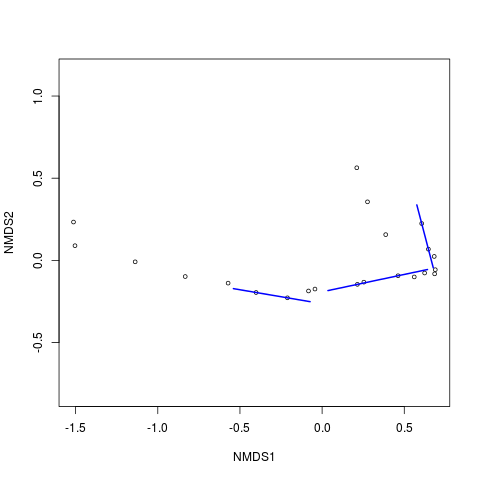

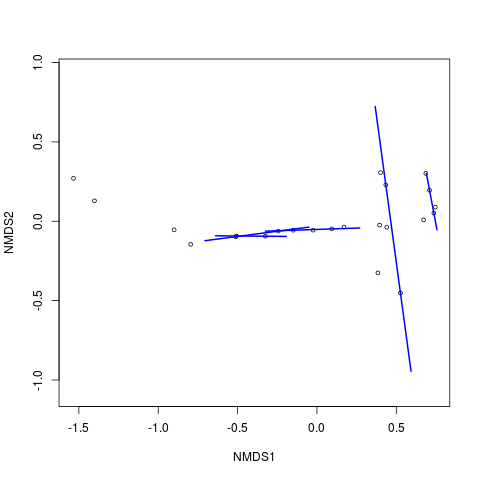

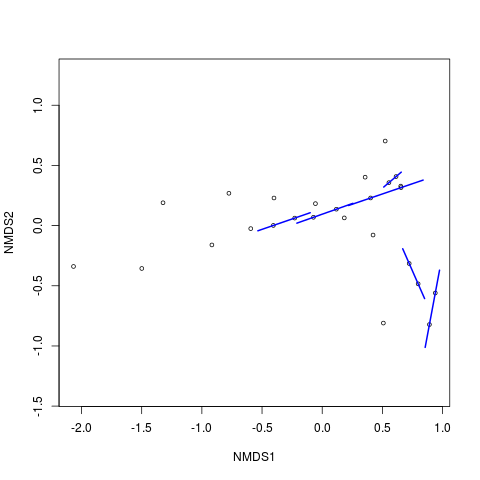

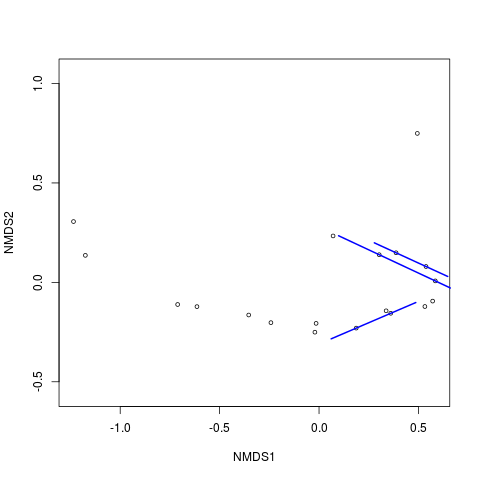

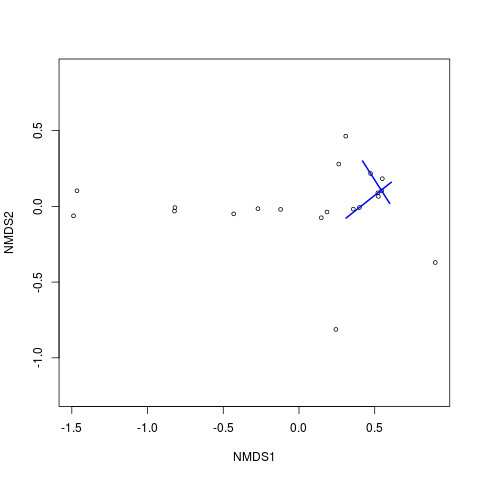

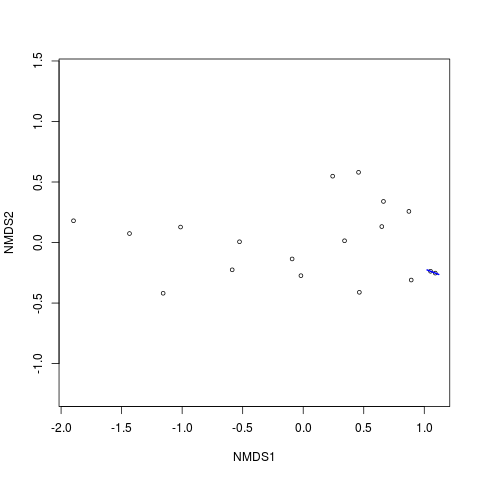

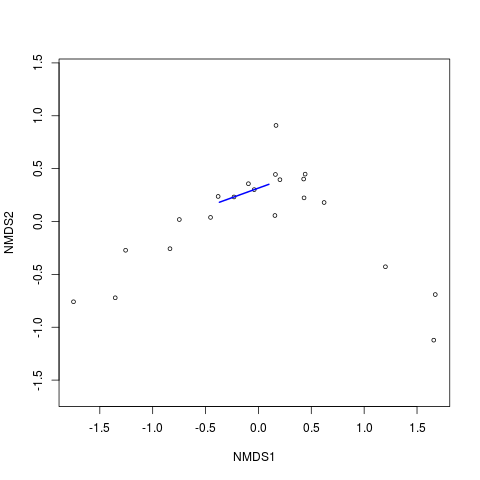

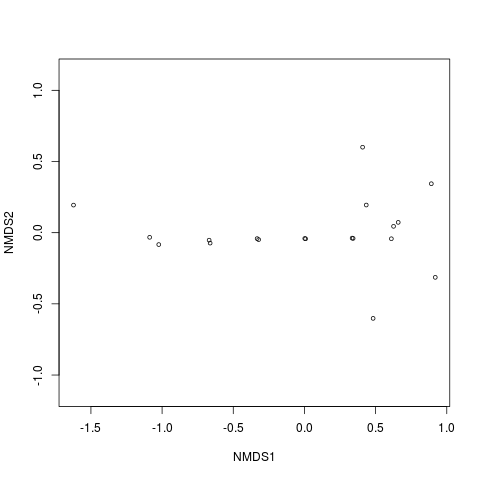

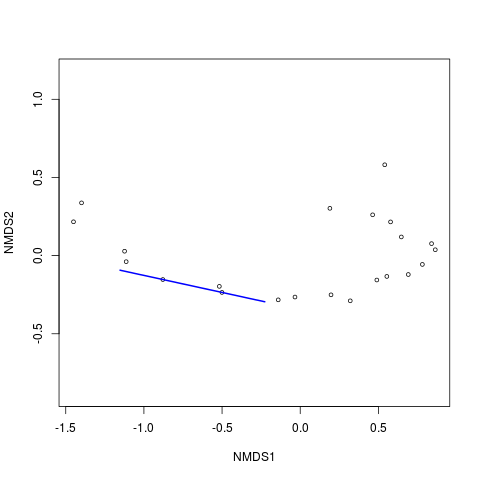

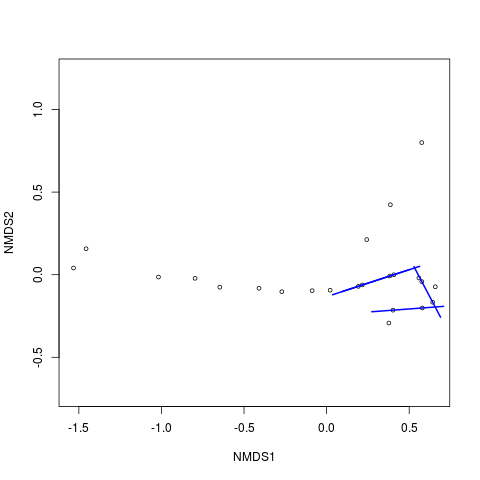

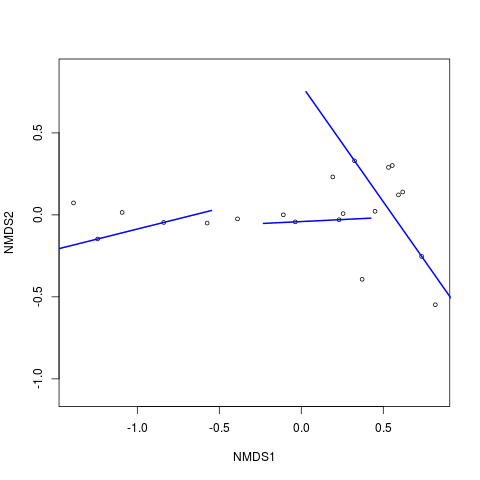

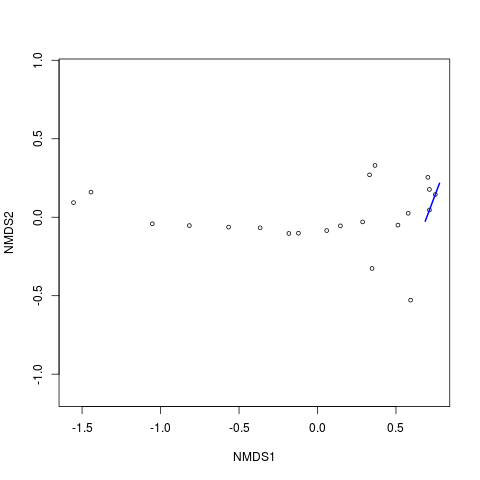

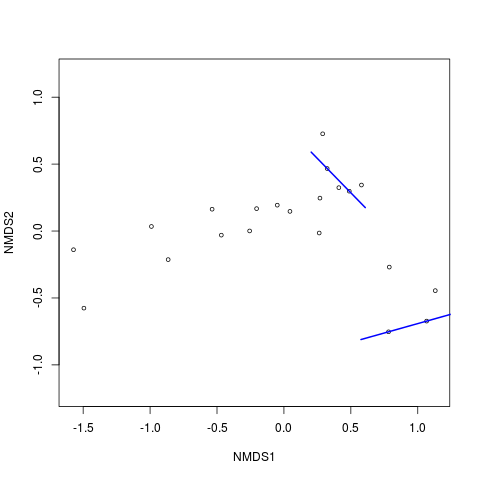

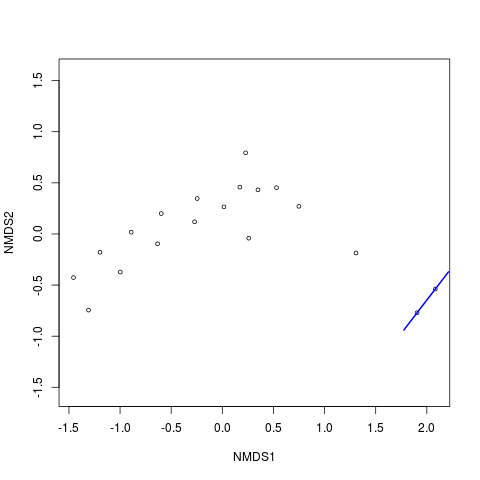

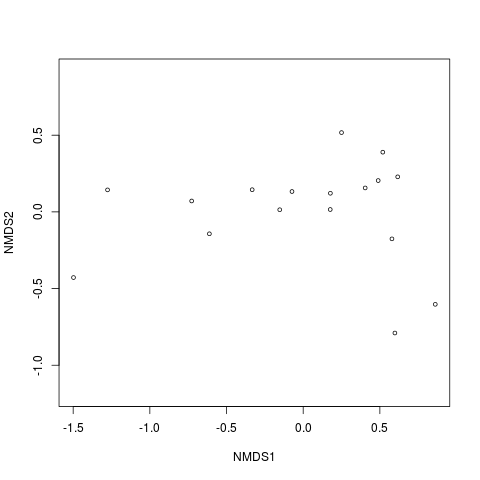

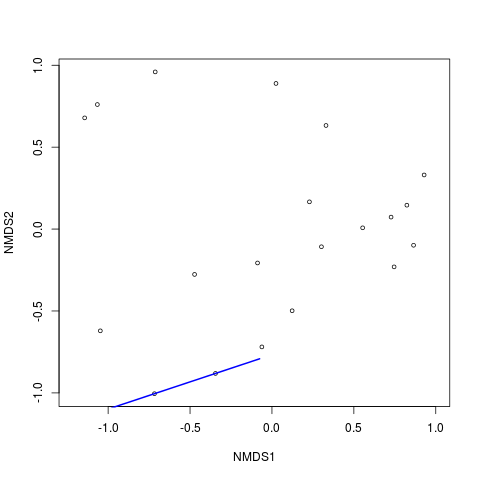

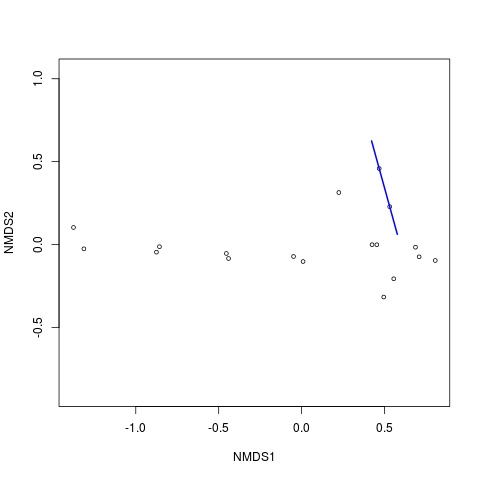

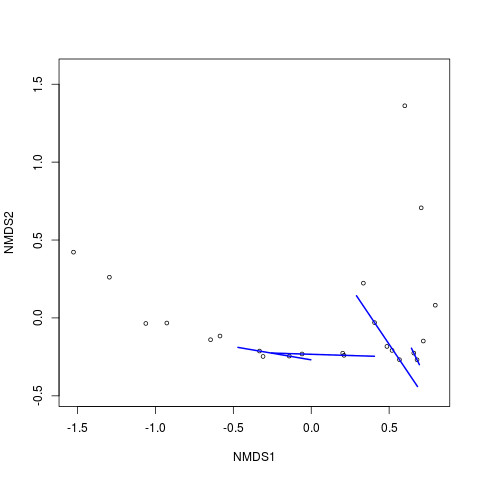

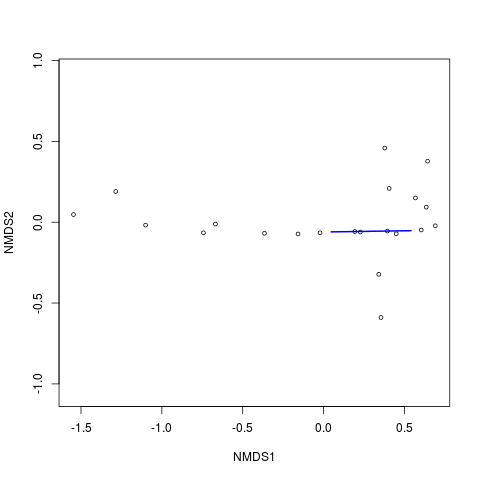

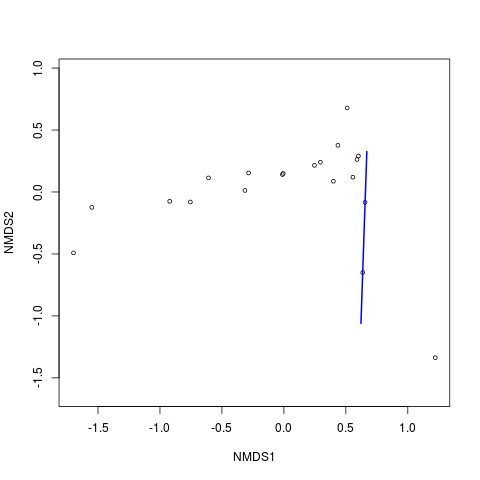

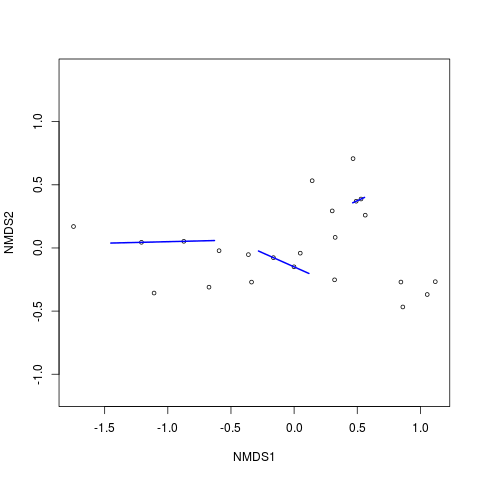

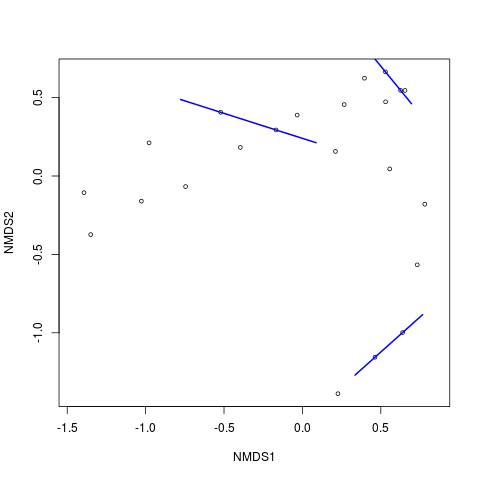

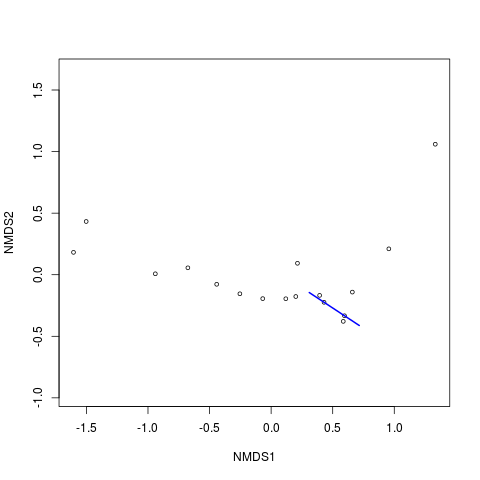

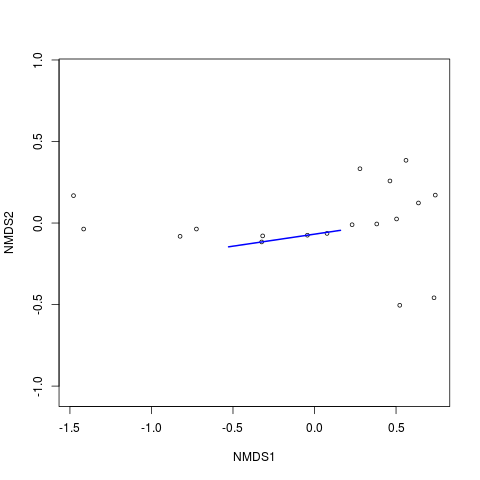

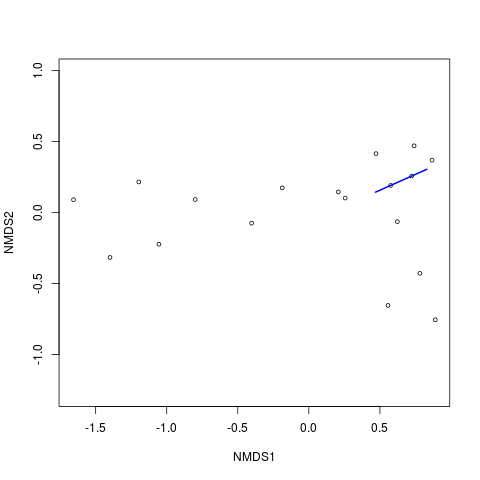

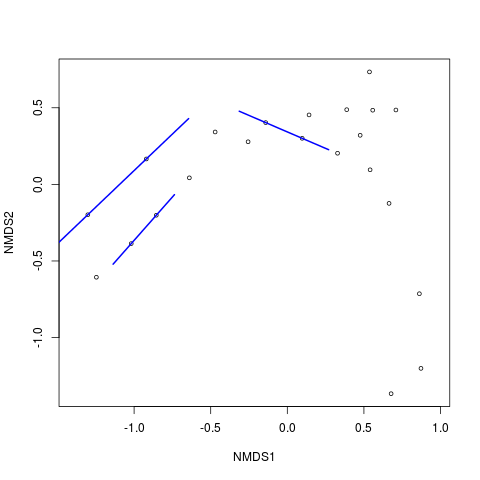

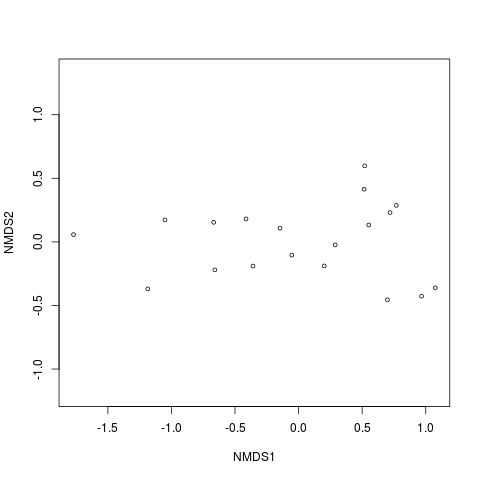

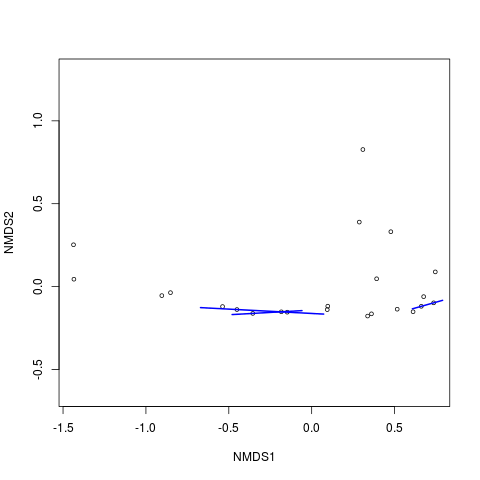

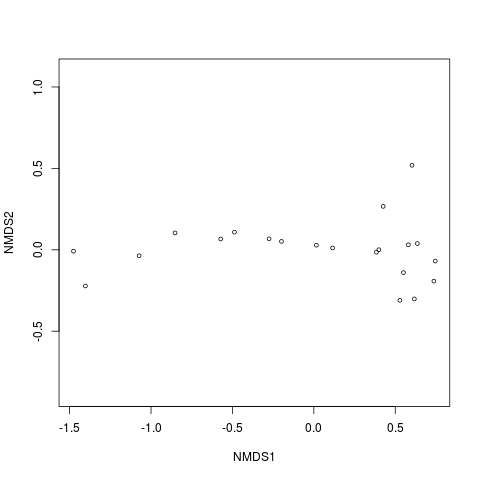

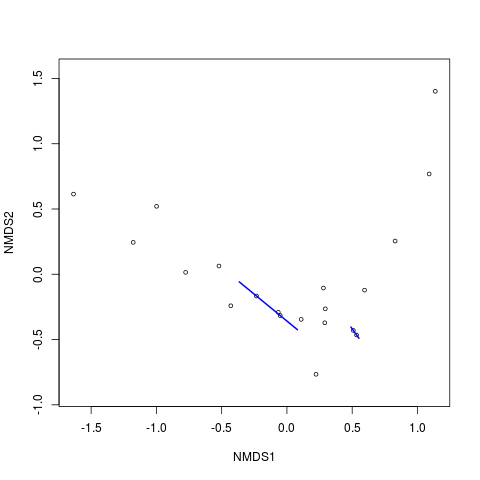

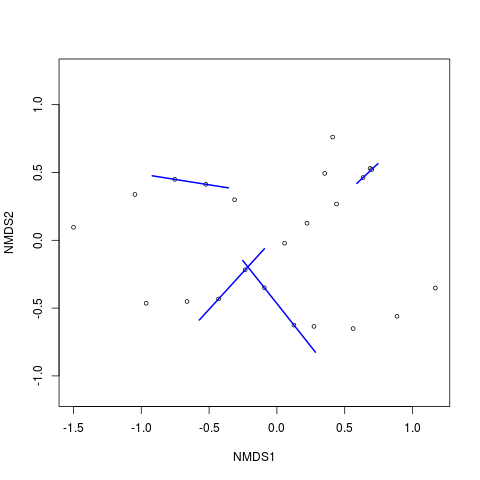

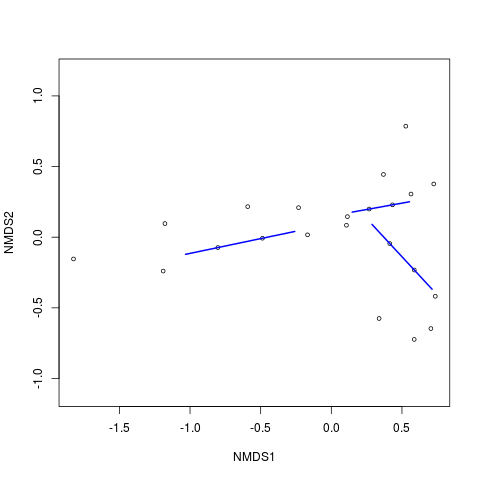

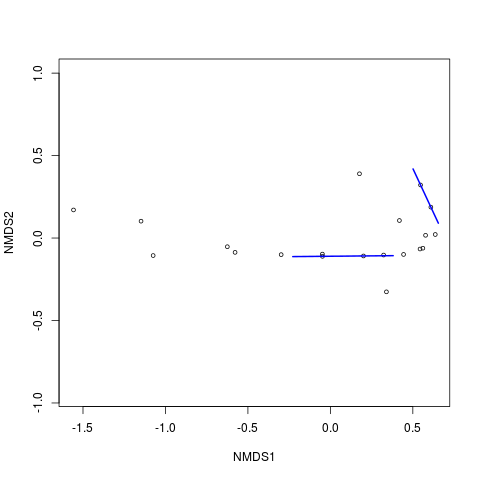

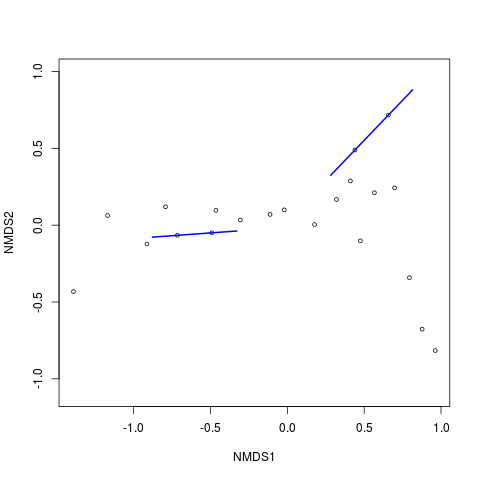

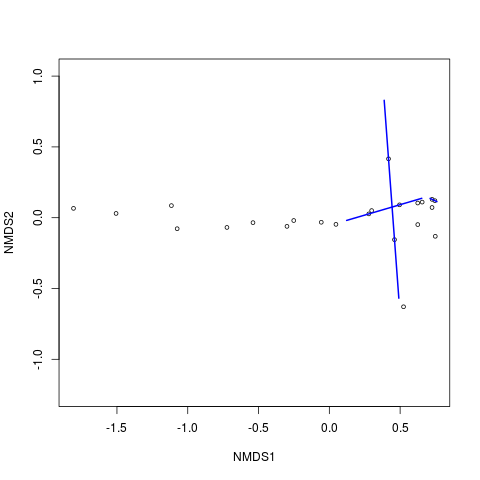

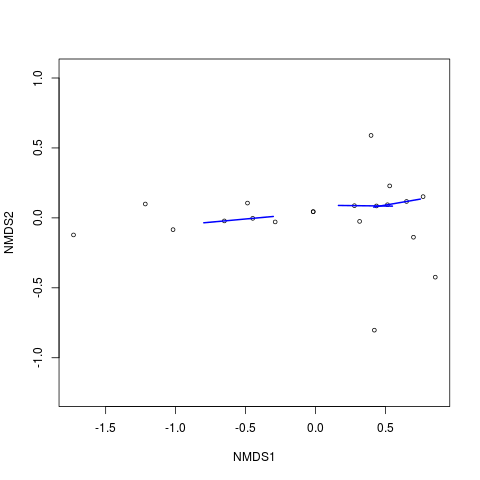

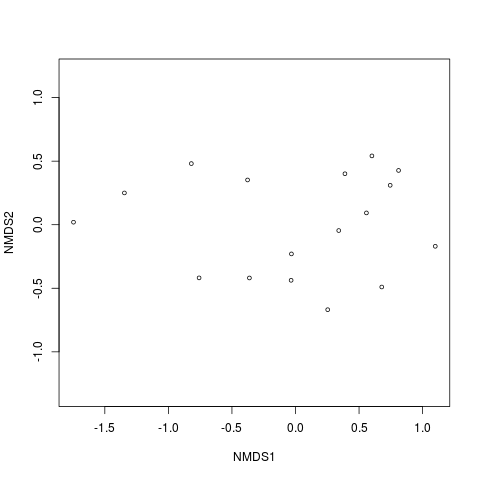

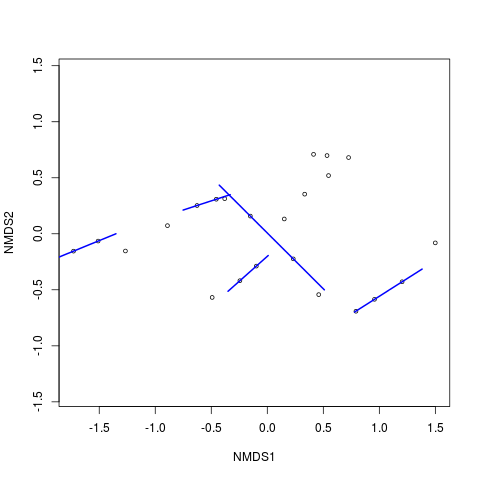

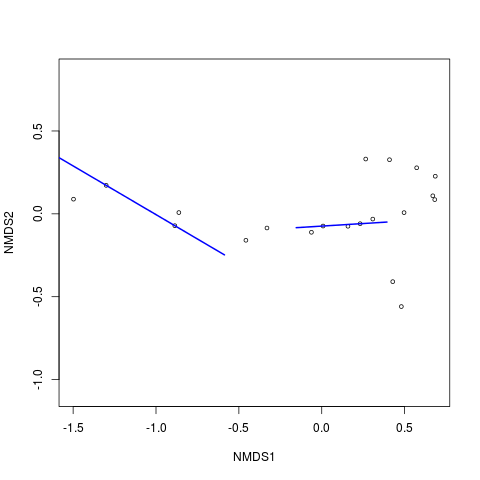

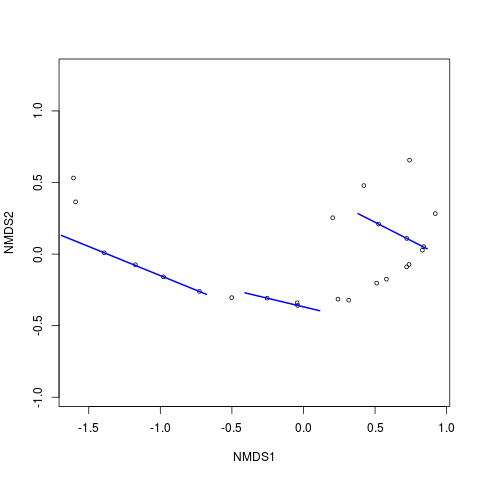

In [43]:
%%R

get.ellipse = function(x){
    meta = x$meta    
    ord = x$ord
    
    plot(ord, type = "p", display='sites')
    elps = ordiellipse(ord, meta$group, kind="se", conf=0.95, lwd=2, col="blue")

    elps = elps %>% summary %>% t %>% as.data.frame
    return(elps)
    }

tbl.elps = lapply(tbl.l.c, get.ellipse)

In [39]:
%%R

tbl = do.call(rbind, tbl.elps)
tbl %>% head

                                                              NMDS1
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.708,1.712] -1.4922898
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.712,1.716] -1.0738806
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.716,1.72]  -0.6329284
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.72,1.724]  -0.2077575
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.728,1.732]  0.3839594
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.732,1.736]  0.7478332
                                                                NMDS2
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.708,1.712]  0.144040255
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.712,1.716] -0.071715299
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.716,1.72]  -0.056693800
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.72,1.724]  -0.026088529
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.728,1.732] -0.006658269
0/10/10/OTU_n2_abs1e9_sub-norm_filt.physeq.(1.732,1.736] -0.025774021
                                  